In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score

from rdkit import Chem
# suppress rdkit warning
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_style("whitegrid")

In [2]:
def convert2cls(chir, csp_category): 
    if csp_category == '1': 
        # For polysaccharide CSPs:
        if chir < 1.15:
            y = 0
        elif chir < 1.2:
            y = 1
        elif chir < 2.1:
            y = 2
        else:
            y = 3
    elif csp_category == '2': 
        # For Pirkle CSPs:
        if chir < 1.05: 
            y = 0
        elif chir < 1.15:
            y = 1
        elif chir < 2: 
            y = 2
        else:
            y = 3
    else:
        raise Exception("The category for CSP should be 1 or 2, rather than {}.".format(csp_category))
    return y

## ChirBase

In [3]:
suppl = Chem.SDMolSupplier("./Chirality/chirbase_clean.sdf")
mols = [x for x in suppl if x is not None]

In [4]:
df_dict = {'SMILES': [], 'MB': [], 'CSP_category': [], 'K2/K1': [], 'Y': []}

for mol in mols: 
    if mol.HasProp('csp_no'):
        mb = mol.GetProp('csp_no')
    else:
        mb = 'unknown'
    smiles = Chem.MolToSmiles(mol)
    chir = round(float(mol.GetProp('k2/k1')), 4)
    y = convert2cls(chir, mol.GetProp('mobile_phase_category'))
    
    df_dict['SMILES'].append(smiles)
    df_dict['K2/K1'].append(chir)
    df_dict['MB'].append(mb)
    df_dict['CSP_category'].append(mol.GetProp('mobile_phase_category'))
    df_dict['Y'].append(y)

df = pd.DataFrame.from_dict(df_dict)

In [5]:
df['isomer_SMILES'] = df['SMILES']
df['SMILES'] = df['SMILES'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))

In [6]:
df['MB'] = df['MB'].astype(int)
MB_dict = {91423: 'Chiralpak IB', 91119: 'Chirobiotic TAG', 90879: 'Chirobiotic T', 90704: 'Chirobiotic V', 90589: 'Whelk-O', 
           90357: 'Cyclobond I RN', 90246: 'Chiralcel OJ (Lux Cellulose-3)', 90211: 'Pirkle (R or S)-DNBPG', 
           45173: 'Chiralcel OD (Lux Cellulose-1)', 45167: 'Chiralpak AS', 44869: 'Chiralcel OB',
           23735: 'Chiralpak AD', 15723: 'Chirobiotic R', 394: 'Chiral-AGP', 91518: 'Chiralpak IC (Sepapak 5)', 
           2: 'Cyclobond I', 45172: 'Chiralpak IA', 3575: 'Ultron-ES-OVM',}
df['Column'] = df['MB'].apply(lambda x: MB_dict[x])

In [7]:
df

,SMILES,MB,CSP_category,K2/K1,Y,isomer_SMILES,Column
0,CCC(=O)OC(C)c1ccccc1,2,1,1.0100,0,CCC(=O)O[C@@H](C)c1ccccc1,Cyclobond I
1,CC(=O)OC(C)c1ccccc1,2,1,1.0300,0,CC(=O)O[C@@H](C)c1ccccc1,Cyclobond I
2,O=C(O)C(Cl)c1ccccc1,2,1,1.0300,0,O=C(O)[C@@H](Cl)c1ccccc1,Cyclobond I
3,CCCC(C(N)=O)c1ccc(O)c(O)c1,2,1,1.3100,2,CCC[C@@H](C(N)=O)c1ccc(O)c(O)c1,Cyclobond I
4,COc1ccccc1C(C)O,2,1,1.0400,0,COc1ccccc1[C@H](C)O,Cyclobond I
...,...,...,...,...,...,...,...
76790,CCOc1ccccc1OCCNC(C)Cc1ccc(OC)c(S(N)(=O)=O)c1,45173,2,1.1843,2,CCOc1ccccc1OCCN[C@@H](C)Cc1ccc(OC)c(S(N)(=O)=O)c1,Chiralcel OD (Lux Cellulose-1)
76791,CCOc1ccccc1OCCNC(C)Cc1ccc(OC)c(S(N)(=O)=O)c1,23735,2,1.8069,2,CCOc1ccccc1OCCN[C@@H](C)Cc1ccc(OC)c(S(N)(=O)=O)c1,Chiralpak AD
76792,CCCS(=O)c1ccc2[nH]c(NC(=O)OC)nc2c1,45172,1,2.1600,3,CCC[S@@](=O)c1ccc2[nH]c(NC(=O)OC)nc2c1,Chiralpak IA
76793,NC(=S)N1N=C(c2ccc(-c3ccccc3)cc2)CC1c1ccccc1,90246,2,5.0000,3,NC(=S)N1N=C(c2ccc(-c3ccccc3)cc2)C[C@@H]1c1ccccc1,Chiralcel OJ (Lux Cellulose-3)


## CMRT

In [8]:
df_rt = pd.read_csv('./Chirality/cmrt_all_column.csv', index_col=0)

df_rt['isomer_SMILES'] = df_rt['SMILES']
df_rt['SMILES'] = df_rt['SMILES'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))

# df_rt = df_rt.sort_values(['index', 'RT'], ascending=False)

df_rt = df_rt[df_rt['RT'] != 0]
df_rt = df_rt.groupby(['index']).filter(lambda x: len(x) == 2)

In [9]:
df_rt

,index,SMILES,RT,Speed,i-PrOH_proportion,Literature,Column,isomer_SMILES
0,0,COC(=O)N(C)C(Cc1ccccc1)B1OC(C)(C)C(C)(C)O1,2.14,0.5,0.05,10.1039/C9SC04534A,OJ3,O=C(OC)N(C)[C@@H](B1OC(C)(C)C(C)(C)O1)CC2=CC=C...
1,0,COC(=O)N(C)C(Cc1ccccc1)B1OC(C)(C)C(C)(C)O1,1.81,0.5,0.05,10.1039/C9SC04534A,OJ3,O=C(OC)N(C)[C@H](B1OC(C)(C)C(C)(C)O1)CC2=CC=CC=C2
3,2,Cc1ccc(S(=O)(=O)CC(C)c2ccc(C(F)(F)F)cc2)cc1,2.13,0.5,0.30,10.1039/C8QO01291A,IA,C[C@H](C[S](=O)(=O)c1ccc(C)cc1)c2ccc(cc2)C(F)(F)F
4,2,Cc1ccc(S(=O)(=O)CC(C)c2ccc(C(F)(F)F)cc2)cc1,2.30,0.5,0.30,10.1039/C8QO01291A,IA,C[C@@H](C[S](=O)(=O)c1ccc(C)cc1)c2ccc(cc2)C(F)...
5,3,Fc1cccc(C2NCc3ccccc3-c3ccccc32)c1,2.00,0.5,0.20,10.1039/C8SC04482A,OD3,Fc1cccc(c1)[C@@H]2NCc3ccccc3c4ccccc24
...,...,...,...,...,...,...,...,...
25860,14142,COC(=O)C(Cc1ccc2ccccc2c1)OC(=O)c1ccccc1,98.30,1.0,0.15,10.1002/adsc.201800774,OJH,COC(=O)[C@H](Cc1ccc2ccccc2c1)OC(=O)c3ccccc3
25862,14144,COc1ccc2c(c1)C(C=Cc1ccccc1)(CO)C(=O)N2COCc1ccccc1,119.10,0.8,0.05,10.31635/ccschem.019.20190064,IC3,COc1ccc2N(COCc3ccccc3)C(=O)[C@](CO)(\C=C\c4ccc...
25863,14144,COc1ccc2c(c1)C(C=Cc1ccccc1)(CO)C(=O)N2COCc1ccccc1,98.90,0.8,0.05,10.31635/ccschem.019.20190064,IC3,COc1ccc2N(COCc3ccccc3)C(=O)[C@@](CO)(\C=C\c4cc...
25864,14145,O=C1OC(OC(=O)C(c2ccccc2)c2ccccc2)c2cccc(F)c21,75.30,0.8,0.10,10.1002/anie.202012445,IC3,Fc1cccc2[C@@H](OC(=O)C(c3ccccc3)c4ccccc4)OC(=O...


In [10]:
df_rt_alpha = df_rt.groupby('index').apply(lambda x: (x['RT'].max() - 2.9) / (x['RT'].min() -2.9)).to_frame(name='K2/K1')

In [11]:
df_rt_alpha = df_rt_alpha.merge(df_rt[['index', 'SMILES', 'Column']], on='index', how='left')
df_rt_alpha = df_rt_alpha[df_rt_alpha.duplicated()]

In [12]:
df_rt_alpha

,index,K2/K1,SMILES,Column
1,0,0.697248,COC(=O)N(C)C(Cc1ccccc1)B1OC(C)(C)C(C)(C)O1,OJ3
3,2,0.779221,Cc1ccc(S(=O)(=O)CC(C)c2ccc(C(F)(F)F)cc2)cc1,IA
5,3,0.666667,Fc1cccc(C2NCc3ccccc3-c3ccccc32)c1,OD3
7,4,0.444444,Fc1ccc2c(c1)CNC(c1ccccc1)c1ccccc1-2,OD3
9,5,0.333333,Clc1ccc2c(c1)-c1ccccc1CNC2c1ccccc1,OD3
...,...,...,...,...
23429,14139,1.121803,COC(=O)CC(O)c1ccc(N(C)C)cc1,IA
23431,14140,1.043142,CN1C(=O)CCC1c1ccc(Cl)cc1,IC3
23433,14142,4.416667,COC(=O)C(Cc1ccc2ccccc2c1)OC(=O)c1ccccc1,OJH
23435,14144,1.210417,COc1ccc2c(c1)C(C=Cc1ccccc1)(CO)C(=O)N2COCc1ccccc1,IC3


## Compare

In [13]:
set(df_rt_alpha['Column'].tolist())

{'AD',
 'AD3',
 'ADH',
 'AS',
 'ASH',
 'AZ',
 'IA',
 'IAH',
 'IAU',
 'IB',
 'IC',
 'IC3',
 'ICH',
 'ID',
 'IE',
 'IF',
 'IF3',
 'IG',
 'OD',
 'OD3',
 'ODH',
 'OJ',
 'OJ3',
 'OJH',
 'OZ3'}

In [14]:
set(df['Column'].tolist())

{'Chiral-AGP',
 'Chiralcel OB',
 'Chiralcel OD (Lux Cellulose-1)',
 'Chiralcel OJ (Lux Cellulose-3)',
 'Chiralpak AD',
 'Chiralpak AS',
 'Chiralpak IA',
 'Chiralpak IB',
 'Chiralpak IC (Sepapak 5)',
 'Chirobiotic R',
 'Chirobiotic T',
 'Chirobiotic TAG',
 'Chirobiotic V',
 'Cyclobond I',
 'Cyclobond I RN',
 'Pirkle (R or S)-DNBPG',
 'Ultron-ES-OVM',
 'Whelk-O'}

In [15]:
Col_map = {'Chiralcel OD (Lux Cellulose-1)': 'OD',
          'Chiralcel OJ (Lux Cellulose-3)': 'OJ', 
          'Chiralpak AD': 'AD',
          'Chiralpak AS': 'AS',
          'Chiralpak IA': 'IA',
          'Chiralpak IB': 'IB',
          'Chiralpak IC (Sepapak 5)': 'IC',}

df['Column_map'] = df['Column'].apply(lambda x: Col_map[x] if x in Col_map.keys() else np.nan)

In [16]:
df

,SMILES,MB,CSP_category,K2/K1,Y,isomer_SMILES,Column,Column_map
0,CCC(=O)OC(C)c1ccccc1,2,1,1.0100,0,CCC(=O)O[C@@H](C)c1ccccc1,Cyclobond I,NaN
1,CC(=O)OC(C)c1ccccc1,2,1,1.0300,0,CC(=O)O[C@@H](C)c1ccccc1,Cyclobond I,NaN
2,O=C(O)C(Cl)c1ccccc1,2,1,1.0300,0,O=C(O)[C@@H](Cl)c1ccccc1,Cyclobond I,NaN
3,CCCC(C(N)=O)c1ccc(O)c(O)c1,2,1,1.3100,2,CCC[C@@H](C(N)=O)c1ccc(O)c(O)c1,Cyclobond I,NaN
4,COc1ccccc1C(C)O,2,1,1.0400,0,COc1ccccc1[C@H](C)O,Cyclobond I,NaN
...,...,...,...,...,...,...,...,...
76790,CCOc1ccccc1OCCNC(C)Cc1ccc(OC)c(S(N)(=O)=O)c1,45173,2,1.1843,2,CCOc1ccccc1OCCN[C@@H](C)Cc1ccc(OC)c(S(N)(=O)=O)c1,Chiralcel OD (Lux Cellulose-1),OD
76791,CCOc1ccccc1OCCNC(C)Cc1ccc(OC)c(S(N)(=O)=O)c1,23735,2,1.8069,2,CCOc1ccccc1OCCN[C@@H](C)Cc1ccc(OC)c(S(N)(=O)=O)c1,Chiralpak AD,AD
76792,CCCS(=O)c1ccc2[nH]c(NC(=O)OC)nc2c1,45172,1,2.1600,3,CCC[S@@](=O)c1ccc2[nH]c(NC(=O)OC)nc2c1,Chiralpak IA,IA
76793,NC(=S)N1N=C(c2ccc(-c3ccccc3)cc2)CC1c1ccccc1,90246,2,5.0000,3,NC(=S)N1N=C(c2ccc(-c3ccccc3)cc2)C[C@@H]1c1ccccc1,Chiralcel OJ (Lux Cellulose-3),OJ


In [17]:
df_all = df_rt_alpha[['SMILES', 'Column', 'K2/K1']].merge(df[['SMILES', 'Column', 'K2/K1', 'Column_map', 'CSP_category']], 
                           left_on=['Column', 'SMILES'], 
                           right_on=['Column_map', 'SMILES'], how='inner')

In [18]:
df_all['Y_x'] = df_all.apply(lambda x: convert2cls(x['K2/K1_x'], x['CSP_category']), axis=1)
df_all['Y_y'] = df_all.apply(lambda x: convert2cls(x['K2/K1_y'], x['CSP_category']), axis=1)

In [19]:
df_all

,SMILES,Column_x,K2/K1_x,Column_y,K2/K1_y,Column_map,CSP_category,Y_x,Y_y
0,CCOC(=O)C(CNC(C)=O)(Sc1ccc(C)cc1)c1ccccc1,OD,1.308036,Chiralcel OD (Lux Cellulose-1),1.3092,OD,2,2,2
1,CCOC(=O)C(C[N+](=O)[O-])(Sc1ccc(C(C)(C)C)cc1)c...,AS,1.259358,Chiralpak AS,1.2599,AS,2,2,2
2,CCOC(=O)C(C[N+](=O)[O-])(Sc1cc(C)cc(C)c1)c1ccccc1,AD,1.084337,Chiralpak AD,1.0845,AD,2,1,1
3,CCC(C#N)c1ccccc1,AS,1.340580,Chiralpak AS,1.3500,AS,2,2,2
4,CCOC(=O)C(C[N+](=O)[O-])(Sc1ccccc1C)c1ccccc1,AD,1.151104,Chiralpak AD,1.1513,AD,2,2,2
...,...,...,...,...,...,...,...,...,...
125,CCC=CC(=O)C(c1cccc(OC)c1)C(C(=O)c1ccc(Br)cc1)C...,IC,1.716418,Chiralpak IC (Sepapak 5),1.8388,IC,1,2,2
126,CCOC(=O)C1=C(C=Cc2ccccc2)OC(=O)CC1c1ccc(Cl)cc1,IA,1.190407,Chiralpak IA,1.1906,IA,1,1,1
127,C=CCC(O)COCc1ccccc1,AS,1.254545,Chiralpak AS,1.1732,AS,2,2,2
128,C=CCC(O)COCc1ccccc1,AS,1.254545,Chiralpak AS,1.2800,AS,2,2,2


In [20]:
df_all.to_csv('./compare_chirbase_cmrt.csv', index=False)
print('Save the comparison results!')

Save the comparison results!


In [21]:
len(df_all[df_all['Y_x'] == df_all['Y_y']])

116

In [22]:
len(df_all[df_all['Y_x'] == df_all['Y_y']]) / len(df_all)

0.8923076923076924

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


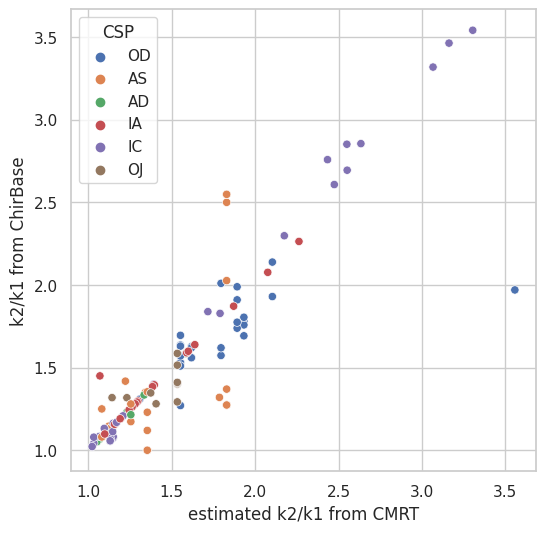

r2: 0.7732758183571495


In [24]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.scatterplot(data=df_all, x="K2/K1_x", y="K2/K1_y", hue="Column_x", ax=ax)

ax.set(xlabel='estimated k2/k1 from CMRT', ylabel='k2/k1 from ChirBase')
plt.legend(title='CSP')
plt.savefig('./compare_chirbase_cmrt.eps', dpi=600, bbox_inches='tight', format='eps')
plt.savefig('./compare_chirbase_cmrt.png', dpi=600, bbox_inches='tight')
plt.show()

print('r2:', r2_score(df_all['K2/K1_x'], df_all['K2/K1_y']))

## Extra

In [42]:
from rdkit import Chem
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers, StereoEnumerationOptions
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=False
IPythonConsole.molSize = 300,300

In [44]:
for s in df['SMILES'].tolist(): 
    m = Chem.MolFromSmiles(s)
    isomers = tuple(EnumerateStereoisomers(m))
    if len(isomers) != 2: 
        print('\n{} isomers are found!\n'.format(len(isomers)))

        for smi in sorted(Chem.MolToSmiles(x, isomericSmiles=True) for x in isomers):
            print(smi)


6 isomers are found!

CN1[C@@H]2CC[C@@H]1CC(OC(=O)[C@@H](CO)c1ccccc1)C2
CN1[C@@H]2CC[C@@H]1CC(OC(=O)[C@H](CO)c1ccccc1)C2
CN1[C@H]2CC[C@@H]1CC(OC(=O)[C@@H](CO)c1ccccc1)C2
CN1[C@H]2CC[C@@H]1CC(OC(=O)[C@H](CO)c1ccccc1)C2
CN1[C@H]2CC[C@H]1CC(OC(=O)[C@@H](CO)c1ccccc1)C2
CN1[C@H]2CC[C@H]1CC(OC(=O)[C@H](CO)c1ccccc1)C2

6 isomers are found!

CN1[C@@H]2CC[C@@H]1CC(OC(=O)[C@@H](O)c1ccccc1)C2
CN1[C@@H]2CC[C@@H]1CC(OC(=O)[C@H](O)c1ccccc1)C2
CN1[C@H]2CC[C@@H]1CC(OC(=O)[C@@H](O)c1ccccc1)C2
CN1[C@H]2CC[C@@H]1CC(OC(=O)[C@H](O)c1ccccc1)C2
CN1[C@H]2CC[C@H]1CC(OC(=O)[C@@H](O)c1ccccc1)C2
CN1[C@H]2CC[C@H]1CC(OC(=O)[C@H](O)c1ccccc1)C2

8 isomers are found!

O=C(N[C@@H]1C[C@@H]2CC[C@@H]1C2)c1ccccc1
O=C(N[C@@H]1C[C@@H]2CC[C@H]1C2)c1ccccc1
O=C(N[C@@H]1C[C@H]2CC[C@@H]1C2)c1ccccc1
O=C(N[C@@H]1C[C@H]2CC[C@H]1C2)c1ccccc1
O=C(N[C@H]1C[C@@H]2CC[C@@H]1C2)c1ccccc1
O=C(N[C@H]1C[C@@H]2CC[C@H]1C2)c1ccccc1
O=C(N[C@H]1C[C@H]2CC[C@@H]1C2)c1ccccc1
O=C(N[C@H]1C[C@H]2CC[C@H]1C2)c1ccccc1

8 isomers are found!

O=C(N[C@@H]1C[C@


4 isomers are found!

CCOC(=O)[C@@H](NC(=O)OCc1ccccc1)[C@@H](C)c1ccccc1
CCOC(=O)[C@@H](NC(=O)OCc1ccccc1)[C@H](C)c1ccccc1
CCOC(=O)[C@H](NC(=O)OCc1ccccc1)[C@@H](C)c1ccccc1
CCOC(=O)[C@H](NC(=O)OCc1ccccc1)[C@H](C)c1ccccc1

4 isomers are found!

C[C@@H](c1ccccc1)[C@@H](NC(=O)OCc1ccccc1)C(=O)OCc1ccccc1
C[C@@H](c1ccccc1)[C@H](NC(=O)OCc1ccccc1)C(=O)OCc1ccccc1
C[C@H](c1ccccc1)[C@@H](NC(=O)OCc1ccccc1)C(=O)OCc1ccccc1
C[C@H](c1ccccc1)[C@H](NC(=O)OCc1ccccc1)C(=O)OCc1ccccc1

1 isomers are found!

OC1(c2ccccc2)CCNCC1

4 isomers are found!

C[C@@H]([C@@H](O)c1ccc(O)cc1)N(C)C(=O)Oc1ccc2ccccc2c1
C[C@@H]([C@H](O)c1ccc(O)cc1)N(C)C(=O)Oc1ccc2ccccc2c1
C[C@H]([C@@H](O)c1ccc(O)cc1)N(C)C(=O)Oc1ccc2ccccc2c1
C[C@H]([C@H](O)c1ccc(O)cc1)N(C)C(=O)Oc1ccc2ccccc2c1

4 isomers are found!

C[C@@H]([C@@H](O)c1ccc(OC(=O)Oc2ccc3ccccc3c2)cc1)N(C)C(=O)Oc1ccc2ccccc2c1
C[C@@H]([C@H](O)c1ccc(OC(=O)Oc2ccc3ccccc3c2)cc1)N(C)C(=O)Oc1ccc2ccccc2c1
C[C@H]([C@@H](O)c1ccc(OC(=O)Oc2ccc3ccccc3c2)cc1)N(C)C(=O)Oc1ccc2ccccc2c1
C[C@H]([C@H](


8 isomers are found!

COC(=O)/C=C(C)/C=C/[C@@]1(O)C(C)=CC(=O)CC1(C)C
COC(=O)/C=C(C)/C=C/[C@]1(O)C(C)=CC(=O)CC1(C)C
COC(=O)/C=C(C)/C=C\[C@@]1(O)C(C)=CC(=O)CC1(C)C
COC(=O)/C=C(C)/C=C\[C@]1(O)C(C)=CC(=O)CC1(C)C
COC(=O)/C=C(C)\C=C/[C@@]1(O)C(C)=CC(=O)CC1(C)C
COC(=O)/C=C(C)\C=C/[C@]1(O)C(C)=CC(=O)CC1(C)C
COC(=O)/C=C(C)\C=C\[C@@]1(O)C(C)=CC(=O)CC1(C)C
COC(=O)/C=C(C)\C=C\[C@]1(O)C(C)=CC(=O)CC1(C)C

4 isomers are found!

O[C@@H](/C=C/c1ccccc1)c1ccco1
O[C@@H](/C=C\c1ccccc1)c1ccco1
O[C@H](/C=C/c1ccccc1)c1ccco1
O[C@H](/C=C\c1ccccc1)c1ccco1

8 isomers are found!

CCCCC[C@@H](O)/C=C/C=C/CCCCCCCC(=O)OC
CCCCC[C@@H](O)/C=C/C=C\CCCCCCCC(=O)OC
CCCCC[C@@H](O)/C=C\C=C/CCCCCCCC(=O)OC
CCCCC[C@@H](O)/C=C\C=C\CCCCCCCC(=O)OC
CCCCC[C@H](O)/C=C/C=C/CCCCCCCC(=O)OC
CCCCC[C@H](O)/C=C/C=C\CCCCCCCC(=O)OC
CCCCC[C@H](O)/C=C\C=C/CCCCCCCC(=O)OC
CCCCC[C@H](O)/C=C\C=C\CCCCCCCC(=O)OC

8 isomers are found!

CCCC/C=C/[C@@H](O)C/C=C/CCCCCCCC(=O)OC
CCCC/C=C/[C@@H](O)C/C=C\CCCCCCCC(=O)OC
CCCC/C=C/[C@H](O)C/C=C/CCCCCCCC(=O)OC
CC


6 isomers are found!

CN1[C@@H]2CC[C@@H]1CC(OC(=O)[C@@H](CO)c1ccccc1)C2
CN1[C@@H]2CC[C@@H]1CC(OC(=O)[C@H](CO)c1ccccc1)C2
CN1[C@H]2CC[C@@H]1CC(OC(=O)[C@@H](CO)c1ccccc1)C2
CN1[C@H]2CC[C@@H]1CC(OC(=O)[C@H](CO)c1ccccc1)C2
CN1[C@H]2CC[C@H]1CC(OC(=O)[C@@H](CO)c1ccccc1)C2
CN1[C@H]2CC[C@H]1CC(OC(=O)[C@H](CO)c1ccccc1)C2

4 isomers are found!

C[NH+](C)CC[C@@H](c1ccc(Cl)cc1)c1cccc[nH+]1.O=C([O-])/C=C/C(=O)[O-]
C[NH+](C)CC[C@@H](c1ccc(Cl)cc1)c1cccc[nH+]1.O=C([O-])/C=C\C(=O)[O-]
C[NH+](C)CC[C@H](c1ccc(Cl)cc1)c1cccc[nH+]1.O=C([O-])/C=C/C(=O)[O-]
C[NH+](C)CC[C@H](c1ccc(Cl)cc1)c1cccc[nH+]1.O=C([O-])/C=C\C(=O)[O-]

32 isomers are found!

CCCCC/C=C/C/C=C/C/C=C/C=C/[C@@H](O)CCCC(=O)OC
CCCCC/C=C/C/C=C/C/C=C/C=C/[C@H](O)CCCC(=O)OC
CCCCC/C=C/C/C=C/C/C=C/C=C\[C@@H](O)CCCC(=O)OC
CCCCC/C=C/C/C=C/C/C=C/C=C\[C@H](O)CCCC(=O)OC
CCCCC/C=C/C/C=C/C/C=C\C=C/[C@@H](O)CCCC(=O)OC
CCCCC/C=C/C/C=C/C/C=C\C=C/[C@H](O)CCCC(=O)OC
CCCCC/C=C/C/C=C/C/C=C\C=C\[C@@H](O)CCCC(=O)OC
CCCCC/C=C/C/C=C/C/C=C\C=C\[C@H](O)CCCC(=O)OC
CCCCC

CCCCC[C@@H](O)/C=C/C=C\C/C=C/C/C=C\CCCC(=O)OC
CCCCC[C@@H](O)/C=C/C=C\C/C=C\C/C=C/CCCC(=O)OC
CCCCC[C@@H](O)/C=C/C=C\C/C=C\C/C=C\CCCC(=O)OC
CCCCC[C@@H](O)/C=C\C=C/C/C=C/C/C=C/CCCC(=O)OC
CCCCC[C@@H](O)/C=C\C=C/C/C=C/C/C=C\CCCC(=O)OC
CCCCC[C@@H](O)/C=C\C=C/C/C=C\C/C=C/CCCC(=O)OC
CCCCC[C@@H](O)/C=C\C=C/C/C=C\C/C=C\CCCC(=O)OC
CCCCC[C@@H](O)/C=C\C=C\C/C=C/C/C=C/CCCC(=O)OC
CCCCC[C@@H](O)/C=C\C=C\C/C=C/C/C=C\CCCC(=O)OC
CCCCC[C@@H](O)/C=C\C=C\C/C=C\C/C=C/CCCC(=O)OC
CCCCC[C@@H](O)/C=C\C=C\C/C=C\C/C=C\CCCC(=O)OC
CCCCC[C@H](O)/C=C/C=C/C/C=C/C/C=C/CCCC(=O)OC
CCCCC[C@H](O)/C=C/C=C/C/C=C/C/C=C\CCCC(=O)OC
CCCCC[C@H](O)/C=C/C=C/C/C=C\C/C=C/CCCC(=O)OC
CCCCC[C@H](O)/C=C/C=C/C/C=C\C/C=C\CCCC(=O)OC
CCCCC[C@H](O)/C=C/C=C\C/C=C/C/C=C/CCCC(=O)OC
CCCCC[C@H](O)/C=C/C=C\C/C=C/C/C=C\CCCC(=O)OC
CCCCC[C@H](O)/C=C/C=C\C/C=C\C/C=C/CCCC(=O)OC
CCCCC[C@H](O)/C=C/C=C\C/C=C\C/C=C\CCCC(=O)OC
CCCCC[C@H](O)/C=C\C=C/C/C=C/C/C=C/CCCC(=O)OC
CCCCC[C@H](O)/C=C\C=C/C/C=C/C/C=C\CCCC(=O)OC
CCCCC[C@H](O)/C=C\C=C/C/C=C\C/C=C/CCCC(=O)OC


32 isomers are found!

CCCCC[C@@H](O)/C=C/C=C/C/C=C/C/C=C/CCCC(=O)OC
CCCCC[C@@H](O)/C=C/C=C/C/C=C/C/C=C\CCCC(=O)OC
CCCCC[C@@H](O)/C=C/C=C/C/C=C\C/C=C/CCCC(=O)OC
CCCCC[C@@H](O)/C=C/C=C/C/C=C\C/C=C\CCCC(=O)OC
CCCCC[C@@H](O)/C=C/C=C\C/C=C/C/C=C/CCCC(=O)OC
CCCCC[C@@H](O)/C=C/C=C\C/C=C/C/C=C\CCCC(=O)OC
CCCCC[C@@H](O)/C=C/C=C\C/C=C\C/C=C/CCCC(=O)OC
CCCCC[C@@H](O)/C=C/C=C\C/C=C\C/C=C\CCCC(=O)OC
CCCCC[C@@H](O)/C=C\C=C/C/C=C/C/C=C/CCCC(=O)OC
CCCCC[C@@H](O)/C=C\C=C/C/C=C/C/C=C\CCCC(=O)OC
CCCCC[C@@H](O)/C=C\C=C/C/C=C\C/C=C/CCCC(=O)OC
CCCCC[C@@H](O)/C=C\C=C/C/C=C\C/C=C\CCCC(=O)OC
CCCCC[C@@H](O)/C=C\C=C\C/C=C/C/C=C/CCCC(=O)OC
CCCCC[C@@H](O)/C=C\C=C\C/C=C/C/C=C\CCCC(=O)OC
CCCCC[C@@H](O)/C=C\C=C\C/C=C\C/C=C/CCCC(=O)OC
CCCCC[C@@H](O)/C=C\C=C\C/C=C\C/C=C\CCCC(=O)OC
CCCCC[C@H](O)/C=C/C=C/C/C=C/C/C=C/CCCC(=O)OC
CCCCC[C@H](O)/C=C/C=C/C/C=C/C/C=C\CCCC(=O)OC
CCCCC[C@H](O)/C=C/C=C/C/C=C\C/C=C/CCCC(=O)OC
CCCCC[C@H](O)/C=C/C=C/C/C=C\C/C=C\CCCC(=O)OC
CCCCC[C@H](O)/C=C/C=C\C/C=C/C/C=C/CCCC(=O)OC
CCCCC[C@H](O)/C


20 isomers are found!

CCCCC[N+]1(C)[C@@H]2CC(OC(=O)[C@@H](CO)c3ccccc3)C[C@@H]1[C@@H]1O[C@H]12
CCCCC[N+]1(C)[C@@H]2CC(OC(=O)[C@@H](CO)c3ccccc3)C[C@@H]1[C@H]1O[C@@H]12
CCCCC[N+]1(C)[C@@H]2CC(OC(=O)[C@@H](CO)c3ccccc3)C[C@@H]1[C@H]1O[C@H]12
CCCCC[N+]1(C)[C@@H]2CC(OC(=O)[C@H](CO)c3ccccc3)C[C@@H]1[C@@H]1O[C@H]12
CCCCC[N+]1(C)[C@@H]2CC(OC(=O)[C@H](CO)c3ccccc3)C[C@@H]1[C@H]1O[C@@H]12
CCCCC[N+]1(C)[C@@H]2CC(OC(=O)[C@H](CO)c3ccccc3)C[C@@H]1[C@H]1O[C@H]12
CCCCC[N+]1(C)[C@H]2CC(OC(=O)[C@@H](CO)c3ccccc3)C[C@@H]1[C@@H]1O[C@@H]12
CCCCC[N+]1(C)[C@H]2CC(OC(=O)[C@@H](CO)c3ccccc3)C[C@@H]1[C@@H]1O[C@H]12
CCCCC[N+]1(C)[C@H]2CC(OC(=O)[C@@H](CO)c3ccccc3)C[C@@H]1[C@H]1O[C@@H]21
CCCCC[N+]1(C)[C@H]2CC(OC(=O)[C@@H](CO)c3ccccc3)C[C@@H]1[C@H]1O[C@H]21
CCCCC[N+]1(C)[C@H]2CC(OC(=O)[C@@H](CO)c3ccccc3)C[C@H]1[C@@H]1O[C@H]12
CCCCC[N+]1(C)[C@H]2CC(OC(=O)[C@@H](CO)c3ccccc3)C[C@H]1[C@H]1O[C@@H]21
CCCCC[N+]1(C)[C@H]2CC(OC(=O)[C@@H](CO)c3ccccc3)C[C@H]1[C@H]1O[C@H]21
CCCCC[N+]1(C)[C@H]2CC(OC(=O)[C@H](CO)c3ccccc3)C[C@@H]1[C


8 isomers are found!

CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C/C(C)=C/C(=O)O
CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C/C(C)=C\C(=O)O
CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C\C(C)=C/C(=O)O
CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C\C(C)=C\C(=O)O
CC1=CC(=O)CC(C)(C)[C@]1(O)/C=C/C(C)=C/C(=O)O
CC1=CC(=O)CC(C)(C)[C@]1(O)/C=C/C(C)=C\C(=O)O
CC1=CC(=O)CC(C)(C)[C@]1(O)/C=C\C(C)=C/C(=O)O
CC1=CC(=O)CC(C)(C)[C@]1(O)/C=C\C(C)=C\C(=O)O

8 isomers are found!

Cn1cnc2c(N[C@@H]3C[C@@H]4CC[C@@H]3C4)ncnc21
Cn1cnc2c(N[C@@H]3C[C@@H]4CC[C@H]3C4)ncnc21
Cn1cnc2c(N[C@@H]3C[C@H]4CC[C@@H]3C4)ncnc21
Cn1cnc2c(N[C@@H]3C[C@H]4CC[C@H]3C4)ncnc21
Cn1cnc2c(N[C@H]3C[C@@H]4CC[C@@H]3C4)ncnc21
Cn1cnc2c(N[C@H]3C[C@@H]4CC[C@H]3C4)ncnc21
Cn1cnc2c(N[C@H]3C[C@H]4CC[C@@H]3C4)ncnc21
Cn1cnc2c(N[C@H]3C[C@H]4CC[C@H]3C4)ncnc21

4 isomers are found!

COCO/C=C/[C@@]1(C)CCCc2ccccc21
COCO/C=C/[C@]1(C)CCCc2ccccc21
COCO/C=C\[C@@]1(C)CCCc2ccccc21
COCO/C=C\[C@]1(C)CCCc2ccccc21

1024 isomers are found!

CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=C(C)/C=C/C2=C(C)C(=O)[C@@H](O)CC2


8 isomers are found!

C(=N/C[C@@H](/N=C/c1ccccc1)c1ccccc1)\c1ccccc1
C(=N/C[C@H](/N=C/c1ccccc1)c1ccccc1)\c1ccccc1
C(=N\C[C@@H](/N=C/c1ccccc1)c1ccccc1)\c1ccccc1
C(=N\C[C@@H](/N=C\c1ccccc1)c1ccccc1)\c1ccccc1
C(=N\C[C@H](/N=C/c1ccccc1)c1ccccc1)\c1ccccc1
C(=N\C[C@H](/N=C\c1ccccc1)c1ccccc1)\c1ccccc1
C(=N\[C@@H](C/N=C/c1ccccc1)c1ccccc1)\c1ccccc1
C(=N\[C@H](C/N=C/c1ccccc1)c1ccccc1)\c1ccccc1

8 isomers are found!

Cc1ccccc1/C=N/C[C@@H](/N=C/c1ccccc1C)c1ccccc1
Cc1ccccc1/C=N/C[C@H](/N=C/c1ccccc1C)c1ccccc1
Cc1ccccc1/C=N\C[C@@H](/N=C/c1ccccc1C)c1ccccc1
Cc1ccccc1/C=N\C[C@@H](/N=C\c1ccccc1C)c1ccccc1
Cc1ccccc1/C=N\C[C@H](/N=C/c1ccccc1C)c1ccccc1
Cc1ccccc1/C=N\C[C@H](/N=C\c1ccccc1C)c1ccccc1
Cc1ccccc1/C=N\[C@@H](C/N=C/c1ccccc1C)c1ccccc1
Cc1ccccc1/C=N\[C@H](C/N=C/c1ccccc1C)c1ccccc1

8 isomers are found!

Cc1cccc(/C=N/C[C@@H](/N=C/c2cccc(C)c2)c2ccccc2)c1
Cc1cccc(/C=N/C[C@H](/N=C/c2cccc(C)c2)c2ccccc2)c1
Cc1cccc(/C=N\C[C@@H](/N=C/c2cccc(C)c2)c2ccccc2)c1
Cc1cccc(/C=N\C[C@@H](/N=C\c2cccc(C)c2)c2ccccc2)c1
Cc1c


1024 isomers are found!

CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=C(C)/C=C/C2=C(C)[C@@H](OC(=O)c3ccccc3)CCC2(C)C)C(C)(C)CCC1
CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=C(C)/C=C/C2=C(C)[C@H](OC(=O)c3ccccc3)CCC2(C)C)C(C)(C)CCC1
CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=C(C)/C=C\C2=C(C)[C@@H](OC(=O)c3ccccc3)CCC2(C)C)C(C)(C)CCC1
CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=C(C)/C=C\C2=C(C)[C@H](OC(=O)c3ccccc3)CCC2(C)C)C(C)(C)CCC1
CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=C(C)\C=C/C2=C(C)[C@@H](OC(=O)c3ccccc3)CCC2(C)C)C(C)(C)CCC1
CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=C(C)\C=C/C2=C(C)[C@H](OC(=O)c3ccccc3)CCC2(C)C)C(C)(C)CCC1
CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=C(C)\C=C\C2=C(C)[C@@H](OC(=O)c3ccccc3)CCC2(C)C)C(C)(C)CCC1
CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=C(C)\C=C\C2=C(C)[C@H](OC(=O)c3ccccc3)CCC2(C)C)C(C)(C)CCC1
CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C\C=C(C)/C=C/C2=C(C)[C@@H](OC(=O)c3ccccc3)CCC2(C)C)C(C)(C)CCC1
CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/


1024 isomers are found!

CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=C(C)/C=C/C2=C(C)[C@@H](OC(=O)c3ccccc3)CCC2(C)C)C(C)(C)CCC1=O
CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=C(C)/C=C/C2=C(C)[C@H](OC(=O)c3ccccc3)CCC2(C)C)C(C)(C)CCC1=O
CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=C(C)/C=C\C2=C(C)[C@@H](OC(=O)c3ccccc3)CCC2(C)C)C(C)(C)CCC1=O
CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=C(C)/C=C\C2=C(C)[C@H](OC(=O)c3ccccc3)CCC2(C)C)C(C)(C)CCC1=O
CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=C(C)\C=C/C2=C(C)[C@@H](OC(=O)c3ccccc3)CCC2(C)C)C(C)(C)CCC1=O
CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=C(C)\C=C/C2=C(C)[C@H](OC(=O)c3ccccc3)CCC2(C)C)C(C)(C)CCC1=O
CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=C(C)\C=C\C2=C(C)[C@@H](OC(=O)c3ccccc3)CCC2(C)C)C(C)(C)CCC1=O
CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=C(C)\C=C\C2=C(C)[C@H](OC(=O)c3ccccc3)CCC2(C)C)C(C)(C)CCC1=O
CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C\C=C(C)/C=C/C2=C(C)[C@@H](OC(=O)c3ccccc3)CCC2(C)C)C(C)(C)CCC1=O
CC1=C(/C=C/C(C)


8 isomers are found!

CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C/C(C)=C/C(=O)O
CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C/C(C)=C\C(=O)O
CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C\C(C)=C/C(=O)O
CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C\C(C)=C\C(=O)O
CC1=CC(=O)CC(C)(C)[C@]1(O)/C=C/C(C)=C/C(=O)O
CC1=CC(=O)CC(C)(C)[C@]1(O)/C=C/C(C)=C\C(=O)O
CC1=CC(=O)CC(C)(C)[C@]1(O)/C=C\C(C)=C/C(=O)O
CC1=CC(=O)CC(C)(C)[C@]1(O)/C=C\C(C)=C\C(=O)O

8 isomers are found!

CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C/C(C)=C/C(=O)O
CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C/C(C)=C\C(=O)O
CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C\C(C)=C/C(=O)O
CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C\C(C)=C\C(=O)O
CC1=CC(=O)CC(C)(C)[C@]1(O)/C=C/C(C)=C/C(=O)O
CC1=CC(=O)CC(C)(C)[C@]1(O)/C=C/C(C)=C\C(=O)O
CC1=CC(=O)CC(C)(C)[C@]1(O)/C=C\C(C)=C/C(=O)O
CC1=CC(=O)CC(C)(C)[C@]1(O)/C=C\C(C)=C\C(=O)O

8 isomers are found!

COC(=O)/C=C(C)/C=C/[C@@]1(O)C(C)=CC(=O)CC1(C)C
COC(=O)/C=C(C)/C=C/[C@]1(O)C(C)=CC(=O)CC1(C)C
COC(=O)/C=C(C)/C=C\[C@@]1(O)C(C)=CC(=O)CC1(C)C
COC(=O)/C=C(C)/C=C\[C@]1(O)C(C)=CC(=O)CC1(C)C
COC(=O)/C=C(C)\C=


6 isomers are found!

O=C(OC1C[C@@H]2CC3C[C@@H](C1)N2C[C@@H]3O)c1c[nH]c2ccccc12
O=C(OC1C[C@@H]2CC3C[C@@H](C1)N2C[C@H]3O)c1c[nH]c2ccccc12
O=C(OC1C[C@@H]2CC3C[C@H](C1)N2C[C@@H]3O)c1c[nH]c2ccccc12
O=C(OC1C[C@@H]2CC3C[C@H](C1)N2C[C@H]3O)c1c[nH]c2ccccc12
O=C(OC1C[C@H]2CC3C[C@H](C1)N2C[C@@H]3O)c1c[nH]c2ccccc12
O=C(OC1C[C@H]2CC3C[C@H](C1)N2C[C@H]3O)c1c[nH]c2ccccc12

8 isomers are found!

CC(C)C[C@@H](C/N=C/c1ccccc1)/N=C/c1ccccc1
CC(C)C[C@@H](C/N=C/c1ccccc1)/N=C\c1ccccc1
CC(C)C[C@@H](C/N=C\c1ccccc1)/N=C/c1ccccc1
CC(C)C[C@@H](C/N=C\c1ccccc1)/N=C\c1ccccc1
CC(C)C[C@H](C/N=C/c1ccccc1)/N=C/c1ccccc1
CC(C)C[C@H](C/N=C/c1ccccc1)/N=C\c1ccccc1
CC(C)C[C@H](C/N=C\c1ccccc1)/N=C/c1ccccc1
CC(C)C[C@H](C/N=C\c1ccccc1)/N=C\c1ccccc1

8 isomers are found!

C(=N/C[C@@H](/N=C/c1ccccc1)c1ccccc1)\c1ccccc1
C(=N/C[C@H](/N=C/c1ccccc1)c1ccccc1)\c1ccccc1
C(=N\C[C@@H](/N=C/c1ccccc1)c1ccccc1)\c1ccccc1
C(=N\C[C@@H](/N=C\c1ccccc1)c1ccccc1)\c1ccccc1
C(=N\C[C@H](/N=C/c1ccccc1)c1ccccc1)\c1ccccc1
C(=N\C[C@H](/N=C\c1ccccc1)c1cccc


4 isomers are found!

CCOC(=O)[C@@H]1C[C@@H](c2ccccc2)OC1=O
CCOC(=O)[C@@H]1C[C@H](c2ccccc2)OC1=O
CCOC(=O)[C@H]1C[C@@H](c2ccccc2)OC1=O
CCOC(=O)[C@H]1C[C@H](c2ccccc2)OC1=O

6 isomers are found!

Cc1cccc(NC(=O)N[C@@H]2N=C(N3[C@@H](C)CCC[C@@H]3C)c3ccccc3N(C)C2=O)c1
Cc1cccc(NC(=O)N[C@@H]2N=C(N3[C@@H](C)CCC[C@H]3C)c3ccccc3N(C)C2=O)c1
Cc1cccc(NC(=O)N[C@@H]2N=C(N3[C@H](C)CCC[C@H]3C)c3ccccc3N(C)C2=O)c1
Cc1cccc(NC(=O)N[C@H]2N=C(N3[C@@H](C)CCC[C@@H]3C)c3ccccc3N(C)C2=O)c1
Cc1cccc(NC(=O)N[C@H]2N=C(N3[C@@H](C)CCC[C@H]3C)c3ccccc3N(C)C2=O)c1
Cc1cccc(NC(=O)N[C@H]2N=C(N3[C@H](C)CCC[C@H]3C)c3ccccc3N(C)C2=O)c1

6 isomers are found!

Cc1cccc(NC(=O)N[C@@H]2N=C(N3[C@@H](C)CCC[C@@H]3C)c3ccccc3N(C)C2=O)c1
Cc1cccc(NC(=O)N[C@@H]2N=C(N3[C@@H](C)CCC[C@H]3C)c3ccccc3N(C)C2=O)c1
Cc1cccc(NC(=O)N[C@@H]2N=C(N3[C@H](C)CCC[C@H]3C)c3ccccc3N(C)C2=O)c1
Cc1cccc(NC(=O)N[C@H]2N=C(N3[C@@H](C)CCC[C@@H]3C)c3ccccc3N(C)C2=O)c1
Cc1cccc(NC(=O)N[C@H]2N=C(N3[C@@H](C)CCC[C@H]3C)c3ccccc3N(C)C2=O)c1
Cc1cccc(NC(=O)N[C@H]2N=C(N3[C@H](C)CCC[


4 isomers are found!

COc1ccc([C@@H]2Sc3ccccc3N(CCN(C)C)C(=O)[C@@H]2OC(C)=O)cc1
COc1ccc([C@@H]2Sc3ccccc3N(CCN(C)C)C(=O)[C@H]2OC(C)=O)cc1
COc1ccc([C@H]2Sc3ccccc3N(CCN(C)C)C(=O)[C@@H]2OC(C)=O)cc1
COc1ccc([C@H]2Sc3ccccc3N(CCN(C)C)C(=O)[C@H]2OC(C)=O)cc1

4 isomers are found!

C[C@@]1(/C=C/[N+](=O)[O-])CCOC1=O
C[C@@]1(/C=C\[N+](=O)[O-])CCOC1=O
C[C@]1(/C=C/[N+](=O)[O-])CCOC1=O
C[C@]1(/C=C\[N+](=O)[O-])CCOC1=O

4 isomers are found!

CC[C@@]1(/C=C/[N+](=O)[O-])CCOC1=O
CC[C@@]1(/C=C\[N+](=O)[O-])CCOC1=O
CC[C@]1(/C=C/[N+](=O)[O-])CCOC1=O
CC[C@]1(/C=C\[N+](=O)[O-])CCOC1=O

4 isomers are found!

C=CC[C@@]1(/C=C/[N+](=O)[O-])CCOC1=O
C=CC[C@@]1(/C=C\[N+](=O)[O-])CCOC1=O
C=CC[C@]1(/C=C/[N+](=O)[O-])CCOC1=O
C=CC[C@]1(/C=C\[N+](=O)[O-])CCOC1=O

4 isomers are found!

CC[C@@]1(/C=C(/C)[N+](=O)[O-])CCOC1=O
CC[C@@]1(/C=C(\C)[N+](=O)[O-])CCOC1=O
CC[C@]1(/C=C(/C)[N+](=O)[O-])CCOC1=O
CC[C@]1(/C=C(\C)[N+](=O)[O-])CCOC1=O

4 isomers are found!

C=CC[C@@]1(/C=C(/C)[N+](=O)[O-])CCOC1=O
C=CC[C@@]1(/C=C(\C)[N+](=O


4 isomers are found!

C=C1C[N@@]1[C@@H](COCc1ccccc1)CC(C)C
C=C1C[N@@]1[C@H](COCc1ccccc1)CC(C)C
C=C1C[N@]1[C@@H](COCc1ccccc1)CC(C)C
C=C1C[N@]1[C@H](COCc1ccccc1)CC(C)C

8 isomers are found!

O=C1OCCN1C(=O)[C@@H]1C[C@@H]2C=C[C@@H]1C2
O=C1OCCN1C(=O)[C@@H]1C[C@@H]2C=C[C@H]1C2
O=C1OCCN1C(=O)[C@@H]1C[C@H]2C=C[C@@H]1C2
O=C1OCCN1C(=O)[C@@H]1C[C@H]2C=C[C@H]1C2
O=C1OCCN1C(=O)[C@H]1C[C@@H]2C=C[C@@H]1C2
O=C1OCCN1C(=O)[C@H]1C[C@@H]2C=C[C@H]1C2
O=C1OCCN1C(=O)[C@H]1C[C@H]2C=C[C@@H]1C2
O=C1OCCN1C(=O)[C@H]1C[C@H]2C=C[C@H]1C2

8 isomers are found!

O=C1OCCN1C(=O)[C@@H]1C[C@@H]2C=C[C@@H]1C2
O=C1OCCN1C(=O)[C@@H]1C[C@@H]2C=C[C@H]1C2
O=C1OCCN1C(=O)[C@@H]1C[C@H]2C=C[C@@H]1C2
O=C1OCCN1C(=O)[C@@H]1C[C@H]2C=C[C@H]1C2
O=C1OCCN1C(=O)[C@H]1C[C@@H]2C=C[C@@H]1C2
O=C1OCCN1C(=O)[C@H]1C[C@@H]2C=C[C@H]1C2
O=C1OCCN1C(=O)[C@H]1C[C@H]2C=C[C@@H]1C2
O=C1OCCN1C(=O)[C@H]1C[C@H]2C=C[C@H]1C2

4 isomers are found!

CC(C)OC(=O)CC(=O)C[C@@H](O)/C=C/c1ccccc1
CC(C)OC(=O)CC(=O)C[C@@H](O)/C=C\c1ccccc1
CC(C)OC(=O)CC(=O)C[C@H](O)/C=C/c1c


4 isomers are found!

C=C[C@@H](O)/C(C)=C/C
C=C[C@@H](O)/C(C)=C\C
C=C[C@H](O)/C(C)=C/C
C=C[C@H](O)/C(C)=C\C

4 isomers are found!

C=C[C@@H](O)/C=C/c1ccccc1
C=C[C@@H](O)/C=C\c1ccccc1
C=C[C@H](O)/C=C/c1ccccc1
C=C[C@H](O)/C=C\c1ccccc1

8 isomers are found!

C/C=C/[C@@H](O)/C=C/c1ccccc1
C/C=C/[C@@H](O)/C=C\c1ccccc1
C/C=C/[C@H](O)/C=C/c1ccccc1
C/C=C/[C@H](O)/C=C\c1ccccc1
C/C=C\[C@@H](O)/C=C/c1ccccc1
C/C=C\[C@@H](O)/C=C\c1ccccc1
C/C=C\[C@H](O)/C=C/c1ccccc1
C/C=C\[C@H](O)/C=C\c1ccccc1

4 isomers are found!

CC[C@@H](O)/C=C/c1ccccc1
CC[C@@H](O)/C=C\c1ccccc1
CC[C@H](O)/C=C/c1ccccc1
CC[C@H](O)/C=C\c1ccccc1

4 isomers are found!

CC(=O)O[C@@H](/C=C/c1ccccc1)c1ccccc1
CC(=O)O[C@@H](/C=C\c1ccccc1)c1ccccc1
CC(=O)O[C@H](/C=C/c1ccccc1)c1ccccc1
CC(=O)O[C@H](/C=C\c1ccccc1)c1ccccc1

4 isomers are found!

CC(=O)O/N=C1/CCCC[C@@H]1c1ccccc1
CC(=O)O/N=C1/CCCC[C@H]1c1ccccc1
CC(=O)O/N=C1\CCCC[C@@H]1c1ccccc1
CC(=O)O/N=C1\CCCC[C@H]1c1ccccc1

4 isomers are found!

CC1(C)C[C@@H](c2ccccc2)CC/C1=N/OC(=O)CCCCc1ccccc1


4 isomers are found!

Cc1ccc(S(=O)(=O)[N@@]2C[C@@H]2c2ccccc2)cc1
Cc1ccc(S(=O)(=O)[N@@]2C[C@H]2c2ccccc2)cc1
Cc1ccc(S(=O)(=O)[N@]2C[C@@H]2c2ccccc2)cc1
Cc1ccc(S(=O)(=O)[N@]2C[C@H]2c2ccccc2)cc1

4 isomers are found!

C[C@@H](NS(=O)(=O)c1ccc(/N=N/c2ccc(N(C)C)cc2)cc1)C(=O)O
C[C@@H](NS(=O)(=O)c1ccc(/N=N\c2ccc(N(C)C)cc2)cc1)C(=O)O
C[C@H](NS(=O)(=O)c1ccc(/N=N/c2ccc(N(C)C)cc2)cc1)C(=O)O
C[C@H](NS(=O)(=O)c1ccc(/N=N\c2ccc(N(C)C)cc2)cc1)C(=O)O

4 isomers are found!

C[C@@H](NS(=O)(=O)c1ccc(/N=N/c2ccc(N(C)C)cc2)cc1)C(=O)O
C[C@@H](NS(=O)(=O)c1ccc(/N=N\c2ccc(N(C)C)cc2)cc1)C(=O)O
C[C@H](NS(=O)(=O)c1ccc(/N=N/c2ccc(N(C)C)cc2)cc1)C(=O)O
C[C@H](NS(=O)(=O)c1ccc(/N=N\c2ccc(N(C)C)cc2)cc1)C(=O)O

4 isomers are found!

C[C@@H](NS(=O)(=O)c1ccc(/N=N/c2ccc(N(C)C)cc2)cc1)C(=O)O
C[C@@H](NS(=O)(=O)c1ccc(/N=N\c2ccc(N(C)C)cc2)cc1)C(=O)O
C[C@H](NS(=O)(=O)c1ccc(/N=N/c2ccc(N(C)C)cc2)cc1)C(=O)O
C[C@H](NS(=O)(=O)c1ccc(/N=N\c2ccc(N(C)C)cc2)cc1)C(=O)O

4 isomers are found!

C[C@@H](NS(=O)(=O)c1ccc(/N=N/c2ccc(N(C)C)cc2)cc1)C(


4 isomers are found!

C[C@@H](O)/C=C/c1ccc(Cl)cc1
C[C@@H](O)/C=C\c1ccc(Cl)cc1
C[C@H](O)/C=C/c1ccc(Cl)cc1
C[C@H](O)/C=C\c1ccc(Cl)cc1

4 isomers are found!

CC(=O)O[C@@H](C)/C=C/c1ccc(Cl)cc1
CC(=O)O[C@@H](C)/C=C\c1ccc(Cl)cc1
CC(=O)O[C@H](C)/C=C/c1ccc(Cl)cc1
CC(=O)O[C@H](C)/C=C\c1ccc(Cl)cc1

4 isomers are found!

CCCC[C@@H](/C=C/c1ccccc1)NC(=O)OCc1ccccc1
CCCC[C@@H](/C=C\c1ccccc1)NC(=O)OCc1ccccc1
CCCC[C@H](/C=C/c1ccccc1)NC(=O)OCc1ccccc1
CCCC[C@H](/C=C\c1ccccc1)NC(=O)OCc1ccccc1

4 isomers are found!

C[C@@H](/C=C/c1ccccc1)NC(=O)OCc1ccccc1
C[C@@H](/C=C\c1ccccc1)NC(=O)OCc1ccccc1
C[C@H](/C=C/c1ccccc1)NC(=O)OCc1ccccc1
C[C@H](/C=C\c1ccccc1)NC(=O)OCc1ccccc1

4 isomers are found!

CC[C@@H](C)[C@@H](NC(=O)OC(C)(C)C)C(=O)O
CC[C@@H](C)[C@H](NC(=O)OC(C)(C)C)C(=O)O
CC[C@H](C)[C@@H](NC(=O)OC(C)(C)C)C(=O)O
CC[C@H](C)[C@H](NC(=O)OC(C)(C)C)C(=O)O

4 isomers are found!

CC[C@@H](C)[C@@H](NC(=O)OC(C)(C)C)C(=O)O
CC[C@@H](C)[C@H](NC(=O)OC(C)(C)C)C(=O)O
CC[C@H](C)[C@@H](NC(=O)OC(C)(C)C)C(=O)O
CC[C@H](C)[C@H](N


4 isomers are found!

C=C(CCCCC)C[C@@H](O)/C=C/c1ccccc1
C=C(CCCCC)C[C@@H](O)/C=C\c1ccccc1
C=C(CCCCC)C[C@H](O)/C=C/c1ccccc1
C=C(CCCCC)C[C@H](O)/C=C\c1ccccc1

8 isomers are found!

CC(=O)C[C@@H](C1=C(O)[C@@H]2C=CC=C[C@@H]2OC1=O)c1ccc(Cl)cc1
CC(=O)C[C@@H](C1=C(O)[C@@H]2C=CC=C[C@H]2OC1=O)c1ccc(Cl)cc1
CC(=O)C[C@@H](C1=C(O)[C@H]2C=CC=C[C@@H]2OC1=O)c1ccc(Cl)cc1
CC(=O)C[C@@H](C1=C(O)[C@H]2C=CC=C[C@H]2OC1=O)c1ccc(Cl)cc1
CC(=O)C[C@H](C1=C(O)[C@@H]2C=CC=C[C@@H]2OC1=O)c1ccc(Cl)cc1
CC(=O)C[C@H](C1=C(O)[C@@H]2C=CC=C[C@H]2OC1=O)c1ccc(Cl)cc1
CC(=O)C[C@H](C1=C(O)[C@H]2C=CC=C[C@@H]2OC1=O)c1ccc(Cl)cc1
CC(=O)C[C@H](C1=C(O)[C@H]2C=CC=C[C@H]2OC1=O)c1ccc(Cl)cc1

8 isomers are found!

CC(=O)C[C@@H](C1=C(O)[C@@H]2C=CC=C[C@@H]2OC1=O)c1ccc(Cl)cc1
CC(=O)C[C@@H](C1=C(O)[C@@H]2C=CC=C[C@H]2OC1=O)c1ccc(Cl)cc1
CC(=O)C[C@@H](C1=C(O)[C@H]2C=CC=C[C@@H]2OC1=O)c1ccc(Cl)cc1
CC(=O)C[C@@H](C1=C(O)[C@H]2C=CC=C[C@H]2OC1=O)c1ccc(Cl)cc1
CC(=O)C[C@H](C1=C(O)[C@@H]2C=CC=C[C@@H]2OC1=O)c1ccc(Cl)cc1
CC(=O)C[C@H](C1=C(O)[C@@H]2C=CC=C[


4 isomers are found!

CCCC(=O)Oc1cccc2c1C[C@@H]1O[C@@H]1C2
CCCC(=O)Oc1cccc2c1C[C@@H]1O[C@H]1C2
CCCC(=O)Oc1cccc2c1C[C@H]1O[C@@H]1C2
CCCC(=O)Oc1cccc2c1C[C@H]1O[C@H]1C2

1 isomers are found!

O=C1OS2(OC(=O)c3cccc4cccc2c34)c2cccc3cccc1c23

4 isomers are found!

O[C@@H](/C=C/c1ccccc1)c1ccccc1
O[C@@H](/C=C\c1ccccc1)c1ccccc1
O[C@H](/C=C/c1ccccc1)c1ccccc1
O[C@H](/C=C\c1ccccc1)c1ccccc1

4 isomers are found!

C/C=C/[C@@H](O)c1ccccc1
C/C=C/[C@H](O)c1ccccc1
C/C=C\[C@@H](O)c1ccccc1
C/C=C\[C@H](O)c1ccccc1

8 isomers are found!

COc1ccc(OCCC[N@@H+](C)CCOc2ccc3c(c2)OCO3)c([C@@H]2Sc3ccccc3N(C)C2=O)c1.O=C([O-])/C=C/C(=O)O
COc1ccc(OCCC[N@@H+](C)CCOc2ccc3c(c2)OCO3)c([C@@H]2Sc3ccccc3N(C)C2=O)c1.O=C([O-])/C=C\C(=O)O
COc1ccc(OCCC[N@@H+](C)CCOc2ccc3c(c2)OCO3)c([C@H]2Sc3ccccc3N(C)C2=O)c1.O=C([O-])/C=C/C(=O)O
COc1ccc(OCCC[N@@H+](C)CCOc2ccc3c(c2)OCO3)c([C@H]2Sc3ccccc3N(C)C2=O)c1.O=C([O-])/C=C\C(=O)O
COc1ccc(OCCC[N@H+](C)CCOc2ccc3c(c2)OCO3)c([C@@H]2Sc3ccccc3N(C)C2=O)c1.O=C([O-])/C=C/C(=O)O
COc1ccc(OCCC[N@H+](C)C


4 isomers are found!

O=C1NC(=O)[C@@]23CCCc4cccc(c42)C(=O)[C@@H]13
O=C1NC(=O)[C@@]23CCCc4cccc(c42)C(=O)[C@H]13
O=C1NC(=O)[C@]23CCCc4cccc(c42)C(=O)[C@@H]13
O=C1NC(=O)[C@]23CCCc4cccc(c42)C(=O)[C@H]13

4 isomers are found!

O=C1NC(=O)[C@@]23CCCc4cccc(c42)C(=O)[C@@H]13
O=C1NC(=O)[C@@]23CCCc4cccc(c42)C(=O)[C@H]13
O=C1NC(=O)[C@]23CCCc4cccc(c42)C(=O)[C@@H]13
O=C1NC(=O)[C@]23CCCc4cccc(c42)C(=O)[C@H]13

4 isomers are found!

O=C1NC(=O)[C@@]23CCCc4cccc(c42)C(=O)[C@@H]13
O=C1NC(=O)[C@@]23CCCc4cccc(c42)C(=O)[C@H]13
O=C1NC(=O)[C@]23CCCc4cccc(c42)C(=O)[C@@H]13
O=C1NC(=O)[C@]23CCCc4cccc(c42)C(=O)[C@H]13

4 isomers are found!

CC(C)(C)S(=O)(=O)[C@@H](/C=C/c1ccccc1)c1ccccc1
CC(C)(C)S(=O)(=O)[C@@H](/C=C\c1ccccc1)c1ccccc1
CC(C)(C)S(=O)(=O)[C@H](/C=C/c1ccccc1)c1ccccc1
CC(C)(C)S(=O)(=O)[C@H](/C=C\c1ccccc1)c1ccccc1

4 isomers are found!

CCOC(=O)O[C@@H](/C=C/c1ccccc1)c1ccccc1
CCOC(=O)O[C@@H](/C=C\c1ccccc1)c1ccccc1
CCOC(=O)O[C@H](/C=C/c1ccccc1)c1ccccc1
CCOC(=O)O[C@H](/C=C\c1ccccc1)c1ccccc1

4 isomers are fo


1 isomers are found!

B[PH](OC)(c1ccccc1)c1cccc2ccccc12

1 isomers are found!

B[PH](OC)(c1ccccc1)c1ccc2ccccc2c1

1 isomers are found!

B[PH](OC)(c1ccccc1)c1ccccc1OC

1 isomers are found!

B[PH](OC)(c1ccccc1)c1ccccc1-c1ccccc1

1 isomers are found!

B[PH](OC)(c1ccccc1)c1c2ccccc2cc2ccccc12

4 isomers are found!

CC[C@@H](O)/C=C/c1ccccc1
CC[C@@H](O)/C=C\c1ccccc1
CC[C@H](O)/C=C/c1ccccc1
CC[C@H](O)/C=C\c1ccccc1

4 isomers are found!

Nc1ncnc2c1ncn2/C=C1/C[C@@H]1CO
Nc1ncnc2c1ncn2/C=C1/C[C@H]1CO
Nc1ncnc2c1ncn2/C=C1\C[C@@H]1CO
Nc1ncnc2c1ncn2/C=C1\C[C@H]1CO

4 isomers are found!

Nc1ncnc2c1ncn2/C=C1/C[C@@H]1CO
Nc1ncnc2c1ncn2/C=C1/C[C@H]1CO
Nc1ncnc2c1ncn2/C=C1\C[C@@H]1CO
Nc1ncnc2c1ncn2/C=C1\C[C@H]1CO

4 isomers are found!

COC(=O)C(C(=O)OC)[C@@H](/C=C/c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@@H](/C=C\c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@H](/C=C/c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@H](/C=C\c1ccccc1)c1ccccc1

4 isomers are found!

CCCC[C@@H](O)/C=C/c1ccccc1
CCCC[C@@H](O)/C=C\c1ccccc1
CCCC[C@H](O)/


4 isomers are found!

CC[C@@H](O)/C=C/c1ccccc1
CC[C@@H](O)/C=C\c1ccccc1
CC[C@H](O)/C=C/c1ccccc1
CC[C@H](O)/C=C\c1ccccc1

4 isomers are found!

O[C@@H](/C=C/c1ccccc1)c1ccccc1
O[C@@H](/C=C\c1ccccc1)c1ccccc1
O[C@H](/C=C/c1ccccc1)c1ccccc1
O[C@H](/C=C\c1ccccc1)c1ccccc1

4 isomers are found!

C[C@@H](O)/C=C/c1ccccc1
C[C@@H](O)/C=C\c1ccccc1
C[C@H](O)/C=C/c1ccccc1
C[C@H](O)/C=C\c1ccccc1

4 isomers are found!

C(=C/[C@@H](NCc1ccccc1)c1ccccc1)\c1ccccc1
C(=C/[C@H](NCc1ccccc1)c1ccccc1)\c1ccccc1
C(=C\[C@@H](NCc1ccccc1)c1ccccc1)\c1ccccc1
C(=C\[C@H](NCc1ccccc1)c1ccccc1)\c1ccccc1

4 isomers are found!

Clc1ccccc1/C=C/[C@@H](NCc1ccccc1)c1ccccc1Cl
Clc1ccccc1/C=C/[C@H](NCc1ccccc1)c1ccccc1Cl
Clc1ccccc1/C=C\[C@@H](NCc1ccccc1)c1ccccc1Cl
Clc1ccccc1/C=C\[C@H](NCc1ccccc1)c1ccccc1Cl

4 isomers are found!

Brc1ccccc1/C=C/[C@@H](NCc1ccccc1)c1ccccc1Br
Brc1ccccc1/C=C/[C@H](NCc1ccccc1)c1ccccc1Br
Brc1ccccc1/C=C\[C@@H](NCc1ccccc1)c1ccccc1Br
Brc1ccccc1/C=C\[C@H](NCc1ccccc1)c1ccccc1Br

4 isomers are found!

O=C1c2ccccc


4 isomers are found!

O=C(/C=C/c1ccc(O)c(O)c1)O[C@@H](Cc1ccc(O)c(O)c1)C(=O)O
O=C(/C=C/c1ccc(O)c(O)c1)O[C@H](Cc1ccc(O)c(O)c1)C(=O)O
O=C(/C=C\c1ccc(O)c(O)c1)O[C@@H](Cc1ccc(O)c(O)c1)C(=O)O
O=C(/C=C\c1ccc(O)c(O)c1)O[C@H](Cc1ccc(O)c(O)c1)C(=O)O

4 isomers are found!

O=C(/C=C/c1ccc(O)c(O)c1)O[C@@H](Cc1ccc(O)c(O)c1)C(=O)O
O=C(/C=C/c1ccc(O)c(O)c1)O[C@H](Cc1ccc(O)c(O)c1)C(=O)O
O=C(/C=C\c1ccc(O)c(O)c1)O[C@@H](Cc1ccc(O)c(O)c1)C(=O)O
O=C(/C=C\c1ccc(O)c(O)c1)O[C@H](Cc1ccc(O)c(O)c1)C(=O)O

4 isomers are found!

CCOC(=O)/C=C1/S[C@@H](N2CCCCC2)C(=O)N1CC
CCOC(=O)/C=C1/S[C@H](N2CCCCC2)C(=O)N1CC
CCOC(=O)/C=C1\S[C@@H](N2CCCCC2)C(=O)N1CC
CCOC(=O)/C=C1\S[C@H](N2CCCCC2)C(=O)N1CC

8 isomers are found!

CC(=O)C[C@@H](C1=C(O)[C@@H]2C=CC=C[C@@H]2OC1=O)c1ccc(Cl)cc1
CC(=O)C[C@@H](C1=C(O)[C@@H]2C=CC=C[C@H]2OC1=O)c1ccc(Cl)cc1
CC(=O)C[C@@H](C1=C(O)[C@H]2C=CC=C[C@@H]2OC1=O)c1ccc(Cl)cc1
CC(=O)C[C@@H](C1=C(O)[C@H]2C=CC=C[C@H]2OC1=O)c1ccc(Cl)cc1
CC(=O)C[C@H](C1=C(O)[C@@H]2C=CC=C[C@@H]2OC1=O)c1ccc(Cl)cc1
CC(=O)C[C@H](C1


CCOP(=O)(OCC)c1cc2c(cc1O)C1(CC2(C)C)CC(C)(C)c2cc(P(=O)(OCC)OCC)c(O)cc21

1 isomers are found!

CCOP(=O)(OCC)c1cc2c3cc1Oc1cccc(c1)Oc1cc4c(cc1P(=O)(OCC)OCC)C(C)(C)CC34CC2(C)C

1 isomers are found!

CCOP(=O)(OCC)c1cc2c3cc1Oc1cc(c(C)cc1C)Oc1cc4c(cc1P(=O)(OCC)OCC)C(C)(C)CC34CC2(C)C

1 isomers are found!

CCOP(=O)(OCC)c1cc2c3cc1Oc1cc(c(C)cc1C)Oc1cc4c(cc1P(=O)(OCC)OCC)C(C)(C)CC34CC2(C)C

1 isomers are found!

CCOP(=O)(OCC)c1cc2c3cc1Oc1cccc(n1)Oc1cc4c(cc1P(=O)(OCC)OCC)C(C)(C)CC34CC2(C)C

1 isomers are found!

CCOP(=O)(OCC)c1cc2c3cc1Oc1cccc(n1)Oc1cc4c(cc1P(=O)(OCC)OCC)C(C)(C)CC34CC2(C)C

1 isomers are found!

CCOP(=O)(OCC)c1cc2c3cc1Oc1c(C)cc(C)c(c1C)Oc1cc4c(cc1P(=O)(OCC)OCC)C(C)(C)CC34CC2(C)C

1 isomers are found!

CCOP(=O)(OCC)c1cc2c3cc1Oc1c(C)cc(C)c(c1C)Oc1cc4c(cc1P(=O)(OCC)OCC)C(C)(C)CC34CC2(C)C

1 isomers are found!

CCOP(=O)(OCC)c1cc2c3cc1Oc1ccc(cc1)Oc1cc4c(cc1P(=O)(OCC)OCC)C(C)(C)CC34CC2(C)C

1 isomers are found!

CCOP(=O)(OCC)c1cc2c3cc1Oc1ccc(cc1)Oc1cc4c(cc1P(=O)(OCC)OCC)C(C)(C)CC34CC2(


4 isomers are found!

COC(=O)c1ccccc1CC[C@@H](O)c1cccc(/C=C/c2ccc3ccc(Cl)cc3n2)c1
COC(=O)c1ccccc1CC[C@@H](O)c1cccc(/C=C\c2ccc3ccc(Cl)cc3n2)c1
COC(=O)c1ccccc1CC[C@H](O)c1cccc(/C=C/c2ccc3ccc(Cl)cc3n2)c1
COC(=O)c1ccccc1CC[C@H](O)c1cccc(/C=C\c2ccc3ccc(Cl)cc3n2)c1

4 isomers are found!

COC(=O)C(C)(C)[C@@H](O)/C=C/c1ccccc1
COC(=O)C(C)(C)[C@@H](O)/C=C\c1ccccc1
COC(=O)C(C)(C)[C@H](O)/C=C/c1ccccc1
COC(=O)C(C)(C)[C@H](O)/C=C\c1ccccc1

4 isomers are found!

CC/C=C/[C@@H](O)c1ccccc1
CC/C=C/[C@H](O)c1ccccc1
CC/C=C\[C@@H](O)c1ccccc1
CC/C=C\[C@H](O)c1ccccc1

4 isomers are found!

C[C@@H](O)/C=C/c1ccccc1
C[C@@H](O)/C=C\c1ccccc1
C[C@H](O)/C=C/c1ccccc1
C[C@H](O)/C=C\c1ccccc1

4 isomers are found!

C/C(=N/[S@@](=O)C(C)(C)C)C(C)C
C/C(=N/[S@](=O)C(C)(C)C)C(C)C
C/C(=N\[S@@](=O)C(C)(C)C)C(C)C
C/C(=N\[S@](=O)C(C)(C)C)C(C)C

4 isomers are found!

C/C(=N/[S@@](=O)C(C)(C)C)c1ccccc1
C/C(=N/[S@](=O)C(C)(C)C)c1ccccc1
C/C(=N\[S@@](=O)C(C)(C)C)c1ccccc1
C/C(=N\[S@](=O)C(C)(C)C)c1ccccc1

4 isomers are found!

COC(=O)

C[C@H]1S/C(=N\C(C)(C)C)N(C)N=C1c1ccccc1

4 isomers are found!

C[C@@H]1S/C(=N/C(C)(C)C)N(C)N=C1c1ccccc1
C[C@@H]1S/C(=N\C(C)(C)C)N(C)N=C1c1ccccc1
C[C@H]1S/C(=N/C(C)(C)C)N(C)N=C1c1ccccc1
C[C@H]1S/C(=N\C(C)(C)C)N(C)N=C1c1ccccc1

4 isomers are found!

C[C@@H]1S/C(=N/C(C)(C)C)N(C)N=C1c1ccccc1
C[C@@H]1S/C(=N\C(C)(C)C)N(C)N=C1c1ccccc1
C[C@H]1S/C(=N/C(C)(C)C)N(C)N=C1c1ccccc1
C[C@H]1S/C(=N\C(C)(C)C)N(C)N=C1c1ccccc1

4 isomers are found!

O=C(/C=C/c1ccccc1)C(F)(F)[C@@H](O)c1ccccc1
O=C(/C=C/c1ccccc1)C(F)(F)[C@H](O)c1ccccc1
O=C(/C=C\c1ccccc1)C(F)(F)[C@@H](O)c1ccccc1
O=C(/C=C\c1ccccc1)C(F)(F)[C@H](O)c1ccccc1

4 isomers are found!

COC(=O)C[C@@H](/C=C/C(C)C)c1ccccc1
COC(=O)C[C@@H](/C=C\C(C)C)c1ccccc1
COC(=O)C[C@H](/C=C/C(C)C)c1ccccc1
COC(=O)C[C@H](/C=C\C(C)C)c1ccccc1

4 isomers are found!

COC(=O)C(C(=O)OC)[C@@H](/C=C/c1ccccc1)C(C)C
COC(=O)C(C(=O)OC)[C@@H](/C=C\c1ccccc1)C(C)C
COC(=O)C(C(=O)OC)[C@H](/C=C/c1ccccc1)C(C)C
COC(=O)C(C(=O)OC)[C@H](/C=C\c1ccccc1)C(C)C

4 isomers are found!

CC(=O)O[C@@H](/C


128 isomers are found!

CC/C=C/C/C=C/C/C=C/C/C=C/C/C=C/C/C=C/CCC(=O)OC[C@@H](COC(=O)CCCCCCC)OC(=O)CCCCCCC
CC/C=C/C/C=C/C/C=C/C/C=C/C/C=C/C/C=C/CCC(=O)OC[C@H](COC(=O)CCCCCCC)OC(=O)CCCCCCC
CC/C=C/C/C=C/C/C=C/C/C=C/C/C=C/C/C=C\CCC(=O)OC[C@@H](COC(=O)CCCCCCC)OC(=O)CCCCCCC
CC/C=C/C/C=C/C/C=C/C/C=C/C/C=C/C/C=C\CCC(=O)OC[C@H](COC(=O)CCCCCCC)OC(=O)CCCCCCC
CC/C=C/C/C=C/C/C=C/C/C=C/C/C=C\C/C=C/CCC(=O)OC[C@@H](COC(=O)CCCCCCC)OC(=O)CCCCCCC
CC/C=C/C/C=C/C/C=C/C/C=C/C/C=C\C/C=C/CCC(=O)OC[C@H](COC(=O)CCCCCCC)OC(=O)CCCCCCC
CC/C=C/C/C=C/C/C=C/C/C=C/C/C=C\C/C=C\CCC(=O)OC[C@@H](COC(=O)CCCCCCC)OC(=O)CCCCCCC
CC/C=C/C/C=C/C/C=C/C/C=C/C/C=C\C/C=C\CCC(=O)OC[C@H](COC(=O)CCCCCCC)OC(=O)CCCCCCC
CC/C=C/C/C=C/C/C=C/C/C=C\C/C=C/C/C=C/CCC(=O)OC[C@@H](COC(=O)CCCCCCC)OC(=O)CCCCCCC
CC/C=C/C/C=C/C/C=C/C/C=C\C/C=C/C/C=C/CCC(=O)OC[C@H](COC(=O)CCCCCCC)OC(=O)CCCCCCC
CC/C=C/C/C=C/C/C=C/C/C=C\C/C=C/C/C=C\CCC(=O)OC[C@@H](COC(=O)CCCCCCC)OC(=O)CCCCCCC
CC/C=C/C/C=C/C/C=C/C/C=C\C/C=C/C/C=C\CCC(=O)OC[C@H](COC(=O)CCCCCCC)OC(=O)CCCCC


4 isomers are found!

CCC1=C(C(=O)OC)[C@@H](c2cccc(OC)c2)n2c(s/c(=C/c3ccc(Cl)cc3)c2=O)=N1
CCC1=C(C(=O)OC)[C@@H](c2cccc(OC)c2)n2c(s/c(=C\c3ccc(Cl)cc3)c2=O)=N1
CCC1=C(C(=O)OC)[C@H](c2cccc(OC)c2)n2c(s/c(=C/c3ccc(Cl)cc3)c2=O)=N1
CCC1=C(C(=O)OC)[C@H](c2cccc(OC)c2)n2c(s/c(=C\c3ccc(Cl)cc3)c2=O)=N1

4 isomers are found!

CCOC(=O)/N=C(/NCCCc1c[nH]cn1)NCC[C@@H](c1ccc(F)cc1)c1ccccn1
CCOC(=O)/N=C(/NCCCc1c[nH]cn1)NCC[C@H](c1ccc(F)cc1)c1ccccn1
CCOC(=O)/N=C(\NCCCc1c[nH]cn1)NCC[C@@H](c1ccc(F)cc1)c1ccccn1
CCOC(=O)/N=C(\NCCCc1c[nH]cn1)NCC[C@H](c1ccc(F)cc1)c1ccccn1

4 isomers are found!

CCOC(=O)/N=C(/NCCCc1c[nH]cn1)NCC[C@@H](c1ccc(F)cc1)c1ccccn1
CCOC(=O)/N=C(/NCCCc1c[nH]cn1)NCC[C@H](c1ccc(F)cc1)c1ccccn1
CCOC(=O)/N=C(\NCCCc1c[nH]cn1)NCC[C@@H](c1ccc(F)cc1)c1ccccn1
CCOC(=O)/N=C(\NCCCc1c[nH]cn1)NCC[C@H](c1ccc(F)cc1)c1ccccn1

4 isomers are found!

CCOC(=O)/N=C(/NCCCc1c[nH]cn1)NCC[C@@H](c1ccc(F)cc1)c1ccccn1
CCOC(=O)/N=C(/NCCCc1c[nH]cn1)NCC[C@H](c1ccc(F)cc1)c1ccccn1
CCOC(=O)/N=C(\NCCCc1c[nH]cn1)NCC[C@@H](c1cc


4 isomers are found!

COP(=O)(OC)O/C(C)=C/C(=O)O[C@@H](C)c1ccccc1
COP(=O)(OC)O/C(C)=C/C(=O)O[C@H](C)c1ccccc1
COP(=O)(OC)O/C(C)=C\C(=O)O[C@@H](C)c1ccccc1
COP(=O)(OC)O/C(C)=C\C(=O)O[C@H](C)c1ccccc1

4 isomers are found!

COP(=O)(OC)O/C(C)=C/C(=O)O[C@@H](C)c1ccccc1
COP(=O)(OC)O/C(C)=C/C(=O)O[C@H](C)c1ccccc1
COP(=O)(OC)O/C(C)=C\C(=O)O[C@@H](C)c1ccccc1
COP(=O)(OC)O/C(C)=C\C(=O)O[C@H](C)c1ccccc1

4 isomers are found!

O=S(=O)(c1cccc2ccccc12)[N@@]1[C@@H](c2ccccc2)C1(c1ccccc1)c1ccccc1
O=S(=O)(c1cccc2ccccc12)[N@@]1[C@H](c2ccccc2)C1(c1ccccc1)c1ccccc1
O=S(=O)(c1cccc2ccccc12)[N@]1[C@@H](c2ccccc2)C1(c1ccccc1)c1ccccc1
O=S(=O)(c1cccc2ccccc12)[N@]1[C@H](c2ccccc2)C1(c1ccccc1)c1ccccc1

4 isomers are found!

COC(=O)C1=C(C)N=c2s/c(=C/c3ccccc3)c(=O)n2[C@@H]1c1ccccc1
COC(=O)C1=C(C)N=c2s/c(=C/c3ccccc3)c(=O)n2[C@H]1c1ccccc1
COC(=O)C1=C(C)N=c2s/c(=C\c3ccccc3)c(=O)n2[C@@H]1c1ccccc1
COC(=O)C1=C(C)N=c2s/c(=C\c3ccccc3)c(=O)n2[C@H]1c1ccccc1

4 isomers are found!

COC(=O)C1=C(C)N=c2s/c(=C/c3ccc(C)cc3)c(=O)n2[C@@H]1


4 isomers are found!

CCOP(=O)(OCC)c1ccc(C(=O)O[C@@H](CCc2ccccc2C(=O)OC)c2cccc(/C=C/c3ccc4ccc(Cl)cc4n3)c2)cc1
CCOP(=O)(OCC)c1ccc(C(=O)O[C@@H](CCc2ccccc2C(=O)OC)c2cccc(/C=C\c3ccc4ccc(Cl)cc4n3)c2)cc1
CCOP(=O)(OCC)c1ccc(C(=O)O[C@H](CCc2ccccc2C(=O)OC)c2cccc(/C=C/c3ccc4ccc(Cl)cc4n3)c2)cc1
CCOP(=O)(OCC)c1ccc(C(=O)O[C@H](CCc2ccccc2C(=O)OC)c2cccc(/C=C\c3ccc4ccc(Cl)cc4n3)c2)cc1

4 isomers are found!

COC(=O)c1ccccc1CC[C@@H](OC(=O)C(C)(C)C)c1cccc(/C=C/c2ccc3ccc(Cl)cc3n2)c1
COC(=O)c1ccccc1CC[C@@H](OC(=O)C(C)(C)C)c1cccc(/C=C\c2ccc3ccc(Cl)cc3n2)c1
COC(=O)c1ccccc1CC[C@H](OC(=O)C(C)(C)C)c1cccc(/C=C/c2ccc3ccc(Cl)cc3n2)c1
COC(=O)c1ccccc1CC[C@H](OC(=O)C(C)(C)C)c1cccc(/C=C\c2ccc3ccc(Cl)cc3n2)c1

4 isomers are found!

O=C(O)/C=C/[S@@](=O)c1ccccc1
O=C(O)/C=C/[S@](=O)c1ccccc1
O=C(O)/C=C\[S@@](=O)c1ccccc1
O=C(O)/C=C\[S@](=O)c1ccccc1

4 isomers are found!

O=C(O)/C=C/[S@@](=O)c1ccccc1
O=C(O)/C=C/[S@](=O)c1ccccc1
O=C(O)/C=C\[S@@](=O)c1ccccc1
O=C(O)/C=C\[S@](=O)c1ccccc1

4 isomers are found!

O=C(O)/C=C/[S@@](

CCCCC/C=C/C=C/[C@H](O)C/C=C/C/C=C/CCCC(=O)OC
CCCCC/C=C/C=C/[C@H](O)C/C=C/C/C=C\CCCC(=O)OC
CCCCC/C=C/C=C/[C@H](O)C/C=C\C/C=C/CCCC(=O)OC
CCCCC/C=C/C=C/[C@H](O)C/C=C\C/C=C\CCCC(=O)OC
CCCCC/C=C/C=C\[C@@H](O)C/C=C/C/C=C/CCCC(=O)OC
CCCCC/C=C/C=C\[C@@H](O)C/C=C/C/C=C\CCCC(=O)OC
CCCCC/C=C/C=C\[C@@H](O)C/C=C\C/C=C/CCCC(=O)OC
CCCCC/C=C/C=C\[C@@H](O)C/C=C\C/C=C\CCCC(=O)OC
CCCCC/C=C/C=C\[C@H](O)C/C=C/C/C=C/CCCC(=O)OC
CCCCC/C=C/C=C\[C@H](O)C/C=C/C/C=C\CCCC(=O)OC
CCCCC/C=C/C=C\[C@H](O)C/C=C\C/C=C/CCCC(=O)OC
CCCCC/C=C/C=C\[C@H](O)C/C=C\C/C=C\CCCC(=O)OC
CCCCC/C=C\C=C/[C@@H](O)C/C=C/C/C=C/CCCC(=O)OC
CCCCC/C=C\C=C/[C@@H](O)C/C=C/C/C=C\CCCC(=O)OC
CCCCC/C=C\C=C/[C@@H](O)C/C=C\C/C=C/CCCC(=O)OC
CCCCC/C=C\C=C/[C@@H](O)C/C=C\C/C=C\CCCC(=O)OC
CCCCC/C=C\C=C/[C@H](O)C/C=C/C/C=C/CCCC(=O)OC
CCCCC/C=C\C=C/[C@H](O)C/C=C/C/C=C\CCCC(=O)OC
CCCCC/C=C\C=C/[C@H](O)C/C=C\C/C=C/CCCC(=O)OC
CCCCC/C=C\C=C/[C@H](O)C/C=C\C/C=C\CCCC(=O)OC
CCCCC/C=C\C=C\[C@@H](O)C/C=C/C/C=C/CCCC(=O)OC
CCCCC/C=C\C=C\[C@@H](O)C/C=C/C/C=C\CCCC(=O)OC


CC(C)(C)OC(=O)N1CCC[C@H]1/C=C/c1ccccc1
CC(C)(C)OC(=O)N1CCC[C@H]1/C=C\c1ccccc1

4 isomers are found!

CCOC(=O)/C=C/[C@@H]1CCCN1C(=O)OC(C)(C)C
CCOC(=O)/C=C/[C@H]1CCCN1C(=O)OC(C)(C)C
CCOC(=O)/C=C\[C@@H]1CCCN1C(=O)OC(C)(C)C
CCOC(=O)/C=C\[C@H]1CCCN1C(=O)OC(C)(C)C

4 isomers are found!

CCOC(=O)/C=C/[C@@H]1CCCN1C(=O)OC(C)(C)C
CCOC(=O)/C=C/[C@H]1CCCN1C(=O)OC(C)(C)C
CCOC(=O)/C=C\[C@@H]1CCCN1C(=O)OC(C)(C)C
CCOC(=O)/C=C\[C@H]1CCCN1C(=O)OC(C)(C)C

6 isomers are found!

CN1[C@@H]2CC[C@@H]1CC(OC(=O)[C@@H](CO)c1ccccc1)C2
CN1[C@@H]2CC[C@@H]1CC(OC(=O)[C@H](CO)c1ccccc1)C2
CN1[C@H]2CC[C@@H]1CC(OC(=O)[C@@H](CO)c1ccccc1)C2
CN1[C@H]2CC[C@@H]1CC(OC(=O)[C@H](CO)c1ccccc1)C2
CN1[C@H]2CC[C@H]1CC(OC(=O)[C@@H](CO)c1ccccc1)C2
CN1[C@H]2CC[C@H]1CC(OC(=O)[C@H](CO)c1ccccc1)C2

6 isomers are found!

CN1[C@@H]2CC[C@@H]1CC(OC(=O)[C@@H](CO)c1ccccc1)C2
CN1[C@@H]2CC[C@@H]1CC(OC(=O)[C@H](CO)c1ccccc1)C2
CN1[C@H]2CC[C@@H]1CC(OC(=O)[C@@H](CO)c1ccccc1)C2
CN1[C@H]2CC[C@@H]1CC(OC(=O)[C@H](CO)c1ccccc1)C2
CN1[C@H]2CC[C@H]1CC(OC(=O)[


4 isomers are found!

C=C[C@@H]1COC(=O)/C1=C(/C)OC(C)=O
C=C[C@@H]1COC(=O)/C1=C(\C)OC(C)=O
C=C[C@H]1COC(=O)/C1=C(/C)OC(C)=O
C=C[C@H]1COC(=O)/C1=C(\C)OC(C)=O

4 isomers are found!

C=C[C@@H]1COC(=O)/C1=C(/CCC)OC(C)=O
C=C[C@@H]1COC(=O)/C1=C(\CCC)OC(C)=O
C=C[C@H]1COC(=O)/C1=C(/CCC)OC(C)=O
C=C[C@H]1COC(=O)/C1=C(\CCC)OC(C)=O

4 isomers are found!

C=C[C@@H]1COC(=O)/C1=C(/CCCCC(C)C)OC(C)=O
C=C[C@@H]1COC(=O)/C1=C(\CCCCC(C)C)OC(C)=O
C=C[C@H]1COC(=O)/C1=C(/CCCCC(C)C)OC(C)=O
C=C[C@H]1COC(=O)/C1=C(\CCCCC(C)C)OC(C)=O

4 isomers are found!

C=C[C@@H]1COC(=O)/C1=C(/COC)OC(C)=O
C=C[C@@H]1COC(=O)/C1=C(\COC)OC(C)=O
C=C[C@H]1COC(=O)/C1=C(/COC)OC(C)=O
C=C[C@H]1COC(=O)/C1=C(\COC)OC(C)=O

4 isomers are found!

COC(=O)C(C(=O)OC)[C@@H](/C=C/c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@@H](/C=C\c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@H](/C=C/c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@H](/C=C\c1ccccc1)c1ccccc1

4 isomers are found!

O=CN(C=O)[C@@H](/C=C/c1ccccc1)c1ccccc1
O=CN(C=O)[C@@H](/C=C\c1ccccc1)c1ccccc1
O=CN(C=O)[C@H]

CCCC(=O)/C(=C\I)[C@@H](O)CC(C)C
CCCC(=O)/C(=C\I)[C@H](O)CC(C)C

4 isomers are found!

CC[C@@H](O)/C(=C/I)C(=O)c1ccccc1
CC[C@@H](O)/C(=C\I)C(=O)c1ccccc1
CC[C@H](O)/C(=C/I)C(=O)c1ccccc1
CC[C@H](O)/C(=C\I)C(=O)c1ccccc1

4 isomers are found!

CCC[C@@H](O)/C(=C/I)C(=O)c1ccccc1
CCC[C@@H](O)/C(=C\I)C(=O)c1ccccc1
CCC[C@H](O)/C(=C/I)C(=O)c1ccccc1
CCC[C@H](O)/C(=C\I)C(=O)c1ccccc1

4 isomers are found!

CCC[C@@H](O)/C(=C/I)C(=O)c1ccccc1
CCC[C@@H](O)/C(=C\I)C(=O)c1ccccc1
CCC[C@H](O)/C(=C/I)C(=O)c1ccccc1
CCC[C@H](O)/C(=C\I)C(=O)c1ccccc1

4 isomers are found!

Cc1ccc(C(=O)/C(=C/I)[C@@H](O)CC(C)C)cc1
Cc1ccc(C(=O)/C(=C/I)[C@H](O)CC(C)C)cc1
Cc1ccc(C(=O)/C(=C\I)[C@@H](O)CC(C)C)cc1
Cc1ccc(C(=O)/C(=C\I)[C@H](O)CC(C)C)cc1

4 isomers are found!

CC(C)C[C@@H](O)/C(=C/I)C(=O)c1ccccc1
CC(C)C[C@@H](O)/C(=C\I)C(=O)c1ccccc1
CC(C)C[C@H](O)/C(=C/I)C(=O)c1ccccc1
CC(C)C[C@H](O)/C(=C\I)C(=O)c1ccccc1

4 isomers are found!

C[C@@H](O)/C=C/c1ccccc1
C[C@@H](O)/C=C\c1ccccc1
C[C@H](O)/C=C/c1ccccc1
C[C@H](O)/C=C\c1ccccc1

4 


4 isomers are found!

Cc1ccc(S(=O)(=O)/N=[S@@](/C)c2ccccc2)cc1
Cc1ccc(S(=O)(=O)/N=[S@@](\C)c2ccccc2)cc1
Cc1ccc(S(=O)(=O)/N=[S@](/C)c2ccccc2)cc1
Cc1ccc(S(=O)(=O)/N=[S@](\C)c2ccccc2)cc1

4 isomers are found!

Cc1ccc(S(=O)(=O)/N=[S@@](/C)c2ccccc2)cc1
Cc1ccc(S(=O)(=O)/N=[S@@](\C)c2ccccc2)cc1
Cc1ccc(S(=O)(=O)/N=[S@](/C)c2ccccc2)cc1
Cc1ccc(S(=O)(=O)/N=[S@](\C)c2ccccc2)cc1

4 isomers are found!

Cc1ccc(S(=O)(=O)/N=[S@@](/Cc2ccccc2)c2ccccc2)cc1
Cc1ccc(S(=O)(=O)/N=[S@@](\Cc2ccccc2)c2ccccc2)cc1
Cc1ccc(S(=O)(=O)/N=[S@](/Cc2ccccc2)c2ccccc2)cc1
Cc1ccc(S(=O)(=O)/N=[S@](\Cc2ccccc2)c2ccccc2)cc1

4 isomers are found!

Cc1ccc(S(=O)(=O)/N=[S@@](/Cc2ccccc2)c2ccccc2)cc1
Cc1ccc(S(=O)(=O)/N=[S@@](\Cc2ccccc2)c2ccccc2)cc1
Cc1ccc(S(=O)(=O)/N=[S@](/Cc2ccccc2)c2ccccc2)cc1
Cc1ccc(S(=O)(=O)/N=[S@](\Cc2ccccc2)c2ccccc2)cc1

4 isomers are found!

Cc1ccc(S(=O)(=O)/N=[S@@](/CCc2ccccc2)c2ccccc2)cc1
Cc1ccc(S(=O)(=O)/N=[S@@](\CCc2ccccc2)c2ccccc2)cc1
Cc1ccc(S(=O)(=O)/N=[S@](/CCc2ccccc2)c2ccccc2)cc1
Cc1ccc(S(=O)(=O)/N=[S@](


4 isomers are found!

Cc1cc(=O)oc2c(C)c3c(cc12)C[C@@H](/C=C/c1ccccc1)O3
Cc1cc(=O)oc2c(C)c3c(cc12)C[C@@H](/C=C\c1ccccc1)O3
Cc1cc(=O)oc2c(C)c3c(cc12)C[C@H](/C=C/c1ccccc1)O3
Cc1cc(=O)oc2c(C)c3c(cc12)C[C@H](/C=C\c1ccccc1)O3

4 isomers are found!

Cc1cc(=O)oc2c(C)c3c(cc12)C[C@@H](/C=C/c1ccccc1)O3
Cc1cc(=O)oc2c(C)c3c(cc12)C[C@@H](/C=C\c1ccccc1)O3
Cc1cc(=O)oc2c(C)c3c(cc12)C[C@H](/C=C/c1ccccc1)O3
Cc1cc(=O)oc2c(C)c3c(cc12)C[C@H](/C=C\c1ccccc1)O3

4 isomers are found!

Cc1cc(=O)oc2c(C)c3c(cc12)C[C@@H](/C=C/c1ccccc1)O3
Cc1cc(=O)oc2c(C)c3c(cc12)C[C@@H](/C=C\c1ccccc1)O3
Cc1cc(=O)oc2c(C)c3c(cc12)C[C@H](/C=C/c1ccccc1)O3
Cc1cc(=O)oc2c(C)c3c(cc12)C[C@H](/C=C\c1ccccc1)O3

4 isomers are found!

Cc1cc(=O)oc2c(C)c3c(cc12)C[C@@H](/C=C/c1ccccc1)O3
Cc1cc(=O)oc2c(C)c3c(cc12)C[C@@H](/C=C\c1ccccc1)O3
Cc1cc(=O)oc2c(C)c3c(cc12)C[C@H](/C=C/c1ccccc1)O3
Cc1cc(=O)oc2c(C)c3c(cc12)C[C@H](/C=C\c1ccccc1)O3

4 isomers are found!

Cc1cc(=O)oc2c(C)c3c(cc12)C[C@@H](/C=C/c1ccccc1)O3
Cc1cc(=O)oc2c(C)c3c(cc12)C[C@@H](/C=C\c1ccc


4 isomers are found!

N#C[C@@H](O)/C=C/c1ccccc1
N#C[C@@H](O)/C=C\c1ccccc1
N#C[C@H](O)/C=C/c1ccccc1
N#C[C@H](O)/C=C\c1ccccc1

8 isomers are found!

C/C=C/C=C/[C@@H](O)C#N
C/C=C/C=C/[C@H](O)C#N
C/C=C/C=C\[C@@H](O)C#N
C/C=C/C=C\[C@H](O)C#N
C/C=C\C=C/[C@@H](O)C#N
C/C=C\C=C/[C@H](O)C#N
C/C=C\C=C\[C@@H](O)C#N
C/C=C\C=C\[C@H](O)C#N

8 isomers are found!

C/C=C/C=C/[C@@H](O)C#N
C/C=C/C=C/[C@H](O)C#N
C/C=C/C=C\[C@@H](O)C#N
C/C=C/C=C\[C@H](O)C#N
C/C=C\C=C/[C@@H](O)C#N
C/C=C\C=C/[C@H](O)C#N
C/C=C\C=C\[C@@H](O)C#N
C/C=C\C=C\[C@H](O)C#N

32 isomers are found!

CCCCC/C=C/C/C=C/C=C/[C@@H](O)C/C=C/CCCC(=O)OC
CCCCC/C=C/C/C=C/C=C/[C@@H](O)C/C=C\CCCC(=O)OC
CCCCC/C=C/C/C=C/C=C/[C@H](O)C/C=C/CCCC(=O)OC
CCCCC/C=C/C/C=C/C=C/[C@H](O)C/C=C\CCCC(=O)OC
CCCCC/C=C/C/C=C/C=C\[C@@H](O)C/C=C/CCCC(=O)OC
CCCCC/C=C/C/C=C/C=C\[C@@H](O)C/C=C\CCCC(=O)OC
CCCCC/C=C/C/C=C/C=C\[C@H](O)C/C=C/CCCC(=O)OC
CCCCC/C=C/C/C=C/C=C\[C@H](O)C/C=C\CCCC(=O)OC
CCCCC/C=C/C/C=C\C=C/[C@@H](O)C/C=C/CCCC(=O)OC
CCCCC/C=C/C/C=C\C=C/[C@@H](O)C/C=C\


4 isomers are found!

CCCCCCC[C@@H](O)/C(=C/c1ccccc1)P(=O)(c1ccccc1)c1ccccc1
CCCCCCC[C@@H](O)/C(=C\c1ccccc1)P(=O)(c1ccccc1)c1ccccc1
CCCCCCC[C@H](O)/C(=C/c1ccccc1)P(=O)(c1ccccc1)c1ccccc1
CCCCCCC[C@H](O)/C(=C\c1ccccc1)P(=O)(c1ccccc1)c1ccccc1

4 isomers are found!

CCCCC(=O)N1[C@@H](c2ccccc2)[C@@H](c2ccccc2)OC1(C)C
CCCCC(=O)N1[C@@H](c2ccccc2)[C@H](c2ccccc2)OC1(C)C
CCCCC(=O)N1[C@H](c2ccccc2)[C@@H](c2ccccc2)OC1(C)C
CCCCC(=O)N1[C@H](c2ccccc2)[C@H](c2ccccc2)OC1(C)C

4 isomers are found!

C(=C/[C@@H](NCc1ccccc1)c1ccccc1)\c1ccccc1
C(=C/[C@H](NCc1ccccc1)c1ccccc1)\c1ccccc1
C(=C\[C@@H](NCc1ccccc1)c1ccccc1)\c1ccccc1
C(=C\[C@H](NCc1ccccc1)c1ccccc1)\c1ccccc1

4 isomers are found!

Cc1ccc(S(=O)(=O)N[C@@H](/C=C/c2ccccc2)c2ccccc2)cc1
Cc1ccc(S(=O)(=O)N[C@@H](/C=C\c2ccccc2)c2ccccc2)cc1
Cc1ccc(S(=O)(=O)N[C@H](/C=C/c2ccccc2)c2ccccc2)cc1
Cc1ccc(S(=O)(=O)N[C@H](/C=C\c2ccccc2)c2ccccc2)cc1

4 isomers are found!

C(=C/[C@@H](c1ccccc1)N1CCCC1)\c1ccccc1
C(=C/[C@H](c1ccccc1)N1CCCC1)\c1ccccc1
C(=C\[C@@H](c1ccccc1)N


4 isomers are found!

COC(=O)C(C(=O)OC)[C@@H](/C=C/c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@@H](/C=C\c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@H](/C=C/c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@H](/C=C\c1ccccc1)c1ccccc1

4 isomers are found!

C=C[C@@H](/C=C/c1ccccc1)NCc1ccccc1
C=C[C@@H](/C=C\c1ccccc1)NCc1ccccc1
C=C[C@H](/C=C/c1ccccc1)NCc1ccccc1
C=C[C@H](/C=C\c1ccccc1)NCc1ccccc1

4 isomers are found!

C=C[C@@H](/C=C/CCOCc1ccc(OC)cc1)NCc1ccccc1
C=C[C@@H](/C=C\CCOCc1ccc(OC)cc1)NCc1ccccc1
C=C[C@H](/C=C/CCOCc1ccc(OC)cc1)NCc1ccccc1
C=C[C@H](/C=C\CCOCc1ccc(OC)cc1)NCc1ccccc1

4 isomers are found!

C=C[C@@H](/C=C/c1ccccc1)C(C(=O)OC)C(=O)OC
C=C[C@@H](/C=C\c1ccccc1)C(C(=O)OC)C(=O)OC
C=C[C@H](/C=C/c1ccccc1)C(C(=O)OC)C(=O)OC
C=C[C@H](/C=C\c1ccccc1)C(C(=O)OC)C(=O)OC

4 isomers are found!

C=C[C@@H](/C=C/CCOCc1ccc(OC)cc1)C(C(=O)OC)C(=O)OC
C=C[C@@H](/C=C\CCOCc1ccc(OC)cc1)C(C(=O)OC)C(=O)OC
C=C[C@H](/C=C/CCOCc1ccc(OC)cc1)C(C(=O)OC)C(=O)OC
C=C[C@H](/C=C\CCOCc1ccc(OC)cc1)C(C(=O)OC)C(=O)OC

4 isomers are found!

CCOC

COC(=O)/C=C1\CN(S(=O)(=O)c2ccc(C)cc2)C[C@]12CC=CCCCC2

4 isomers are found!

COC(=O)/C=C1/CN(S(=O)(=O)c2ccc(C)cc2)C[C@@]12C=CCCCCCCCCCCCC2
COC(=O)/C=C1/CN(S(=O)(=O)c2ccc(C)cc2)C[C@]12C=CCCCCCCCCCCCC2
COC(=O)/C=C1\CN(S(=O)(=O)c2ccc(C)cc2)C[C@@]12C=CCCCCCCCCCCCC2
COC(=O)/C=C1\CN(S(=O)(=O)c2ccc(C)cc2)C[C@]12C=CCCCCCCCCCCCC2

4 isomers are found!

C[C@@H](/C=C/c1ccccc1)c1ccccc1
C[C@@H](/C=C\c1ccccc1)c1ccccc1
C[C@H](/C=C/c1ccccc1)c1ccccc1
C[C@H](/C=C\c1ccccc1)c1ccccc1

4 isomers are found!

O=C1C=CO[C@@H](/C=C/c2ccccc2)C1
O=C1C=CO[C@@H](/C=C\c2ccccc2)C1
O=C1C=CO[C@H](/C=C/c2ccccc2)C1
O=C1C=CO[C@H](/C=C\c2ccccc2)C1

4 isomers are found!

C=CC[C@@H](O)/C=C/c1ccccc1
C=CC[C@@H](O)/C=C\c1ccccc1
C=CC[C@H](O)/C=C/c1ccccc1
C=CC[C@H](O)/C=C\c1ccccc1

4 isomers are found!

CCC/C=C(/CCC)[C@@H](O)c1ccccc1
CCC/C=C(/CCC)[C@H](O)c1ccccc1
CCC/C=C(\CCC)[C@@H](O)c1ccccc1
CCC/C=C(\CCC)[C@H](O)c1ccccc1

4 isomers are found!

COC(=O)C(C(=O)OC)[C@@H](/C=C/c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@@H](/C=C\c1ccccc1)c


4 isomers are found!

CC1=C(CC(=O)O)c2cc(F)ccc2/C1=C/c1ccc([S@@](C)=O)cc1
CC1=C(CC(=O)O)c2cc(F)ccc2/C1=C/c1ccc([S@](C)=O)cc1
CC1=C(CC(=O)O)c2cc(F)ccc2/C1=C\c1ccc([S@@](C)=O)cc1
CC1=C(CC(=O)O)c2cc(F)ccc2/C1=C\c1ccc([S@](C)=O)cc1

4 isomers are found!

CC(C)(C)[C@@H](O)/C(=C/c1ccc(Cl)cc1Cl)n1cncn1
CC(C)(C)[C@@H](O)/C(=C\c1ccc(Cl)cc1Cl)n1cncn1
CC(C)(C)[C@H](O)/C(=C/c1ccc(Cl)cc1Cl)n1cncn1
CC(C)(C)[C@H](O)/C(=C\c1ccc(Cl)cc1Cl)n1cncn1

4 isomers are found!

CC(C)(C)[C@@H](O)/C(=C/c1ccc(Cl)cc1Cl)n1cncn1
CC(C)(C)[C@@H](O)/C(=C\c1ccc(Cl)cc1Cl)n1cncn1
CC(C)(C)[C@H](O)/C(=C/c1ccc(Cl)cc1Cl)n1cncn1
CC(C)(C)[C@H](O)/C(=C\c1ccc(Cl)cc1Cl)n1cncn1

4 isomers are found!

CC(C)(C)[C@@H](O)/C(=C/c1ccc(Cl)cc1Cl)n1cncn1
CC(C)(C)[C@@H](O)/C(=C\c1ccc(Cl)cc1Cl)n1cncn1
CC(C)(C)[C@H](O)/C(=C/c1ccc(Cl)cc1Cl)n1cncn1
CC(C)(C)[C@H](O)/C(=C\c1ccc(Cl)cc1Cl)n1cncn1

4 isomers are found!

CC(C)(C)[C@@H](O)/C(=C/c1ccc(Cl)cc1Cl)n1cncn1
CC(C)(C)[C@@H](O)/C(=C\c1ccc(Cl)cc1Cl)n1cncn1
CC(C)(C)[C@H](O)/C(=C/c1ccc(Cl)cc1Cl)n1cn


C(=C/[C@@H](NCc1ccccc1)c1ccccc1)\c1ccccc1
C(=C/[C@H](NCc1ccccc1)c1ccccc1)\c1ccccc1
C(=C\[C@@H](NCc1ccccc1)c1ccccc1)\c1ccccc1
C(=C\[C@H](NCc1ccccc1)c1ccccc1)\c1ccccc1

4 isomers are found!

CCOC(=O)C[C@@H](O)/C(C)=C/c1csc(C)n1
CCOC(=O)C[C@@H](O)/C(C)=C\c1csc(C)n1
CCOC(=O)C[C@H](O)/C(C)=C/c1csc(C)n1
CCOC(=O)C[C@H](O)/C(C)=C\c1csc(C)n1

4 isomers are found!

COC(=O)C[C@@H](O)/C(C)=C/c1csc(C)n1
COC(=O)C[C@@H](O)/C(C)=C\c1csc(C)n1
COC(=O)C[C@H](O)/C(C)=C/c1csc(C)n1
COC(=O)C[C@H](O)/C(C)=C\c1csc(C)n1

4 isomers are found!

C=CC[C@@H](O)/C=C/c1ccccc1
C=CC[C@@H](O)/C=C\c1ccccc1
C=CC[C@H](O)/C=C/c1ccccc1
C=CC[C@H](O)/C=C\c1ccccc1

4 isomers are found!

COC(=O)[C@@H](O)/C=C/c1ccccc1
COC(=O)[C@@H](O)/C=C\c1ccccc1
COC(=O)[C@H](O)/C=C/c1ccccc1
COC(=O)[C@H](O)/C=C\c1ccccc1

4 isomers are found!

CCOC(=O)[C@@H](O)/C=C/c1ccccc1
CCOC(=O)[C@@H](O)/C=C\c1ccccc1
CCOC(=O)[C@H](O)/C=C/c1ccccc1
CCOC(=O)[C@H](O)/C=C\c1ccccc1

4 isomers are found!

COC(=O)[C@@H](O)/C=C/c1ccc(Cl)cc1
COC(=O)[C@@H](O)/C=C\c1ccc(


4 isomers are found!

N#C[C@@H](/C=C/c1ccccc1)NC(c1ccccc1)c1ccccc1
N#C[C@@H](/C=C\c1ccccc1)NC(c1ccccc1)c1ccccc1
N#C[C@H](/C=C/c1ccccc1)NC(c1ccccc1)c1ccccc1
N#C[C@H](/C=C\c1ccccc1)NC(c1ccccc1)c1ccccc1

4 isomers are found!

C=C(C)C[C@@H](O)/C=C/c1ccccc1
C=C(C)C[C@@H](O)/C=C\c1ccccc1
C=C(C)C[C@H](O)/C=C/c1ccccc1
C=C(C)C[C@H](O)/C=C\c1ccccc1

4 isomers are found!

C=C(C)C[C@@H](/C=C/CCC)OC(=O)c1ccccc1
C=C(C)C[C@@H](/C=C\CCC)OC(=O)c1ccccc1
C=C(C)C[C@H](/C=C/CCC)OC(=O)c1ccccc1
C=C(C)C[C@H](/C=C\CCC)OC(=O)c1ccccc1

4 isomers are found!

CCOC(=O)C(O)(C(=O)OCC)[C@@H](C)/C=[N+](/[O-])C(C)(C)C
CCOC(=O)C(O)(C(=O)OCC)[C@@H](C)/C=[N+](\[O-])C(C)(C)C
CCOC(=O)C(O)(C(=O)OCC)[C@H](C)/C=[N+](/[O-])C(C)(C)C
CCOC(=O)C(O)(C(=O)OCC)[C@H](C)/C=[N+](\[O-])C(C)(C)C

4 isomers are found!

CCOC(=O)C(O)(C(=O)OCC)[C@@H](/C=[N+](/[O-])C(C)(C)C)CC
CCOC(=O)C(O)(C(=O)OCC)[C@@H](/C=[N+](\[O-])C(C)(C)C)CC
CCOC(=O)C(O)(C(=O)OCC)[C@H](/C=[N+](/[O-])C(C)(C)C)CC
CCOC(=O)C(O)(C(=O)OCC)[C@H](/C=[N+](\[O-])C(C)(C)C)CC

4 isom


4 isomers are found!

CC1(C)CCC(C)(C)c2cc([C@@H]3CCCc4oc(/C=C/C(=O)O)cc43)ccc21
CC1(C)CCC(C)(C)c2cc([C@@H]3CCCc4oc(/C=C\C(=O)O)cc43)ccc21
CC1(C)CCC(C)(C)c2cc([C@H]3CCCc4oc(/C=C/C(=O)O)cc43)ccc21
CC1(C)CCC(C)(C)c2cc([C@H]3CCCc4oc(/C=C\C(=O)O)cc43)ccc21

8 isomers are found!

CCOC(=O)[C@@](Cc1ccccc1)(C(=O)OC)[C@@H](/C=C/c1ccccc1)c1ccccc1
CCOC(=O)[C@@](Cc1ccccc1)(C(=O)OC)[C@@H](/C=C\c1ccccc1)c1ccccc1
CCOC(=O)[C@@](Cc1ccccc1)(C(=O)OC)[C@H](/C=C/c1ccccc1)c1ccccc1
CCOC(=O)[C@@](Cc1ccccc1)(C(=O)OC)[C@H](/C=C\c1ccccc1)c1ccccc1
CCOC(=O)[C@](Cc1ccccc1)(C(=O)OC)[C@@H](/C=C/c1ccccc1)c1ccccc1
CCOC(=O)[C@](Cc1ccccc1)(C(=O)OC)[C@@H](/C=C\c1ccccc1)c1ccccc1
CCOC(=O)[C@](Cc1ccccc1)(C(=O)OC)[C@H](/C=C/c1ccccc1)c1ccccc1
CCOC(=O)[C@](Cc1ccccc1)(C(=O)OC)[C@H](/C=C\c1ccccc1)c1ccccc1

8 isomers are found!

CCCC[C@@](C(=O)OC)(C(=O)OCC)[C@@H](/C=C/c1ccccc1)c1ccccc1
CCCC[C@@](C(=O)OC)(C(=O)OCC)[C@@H](/C=C\c1ccccc1)c1ccccc1
CCCC[C@@](C(=O)OC)(C(=O)OCC)[C@H](/C=C/c1ccccc1)c1ccccc1
CCCC[C@@](C(=O)OC)(C(=O)OCC)[C@H


4 isomers are found!

COC(=O)C(C(=O)OC)[C@@H](/C=C/c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@@H](/C=C\c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@H](/C=C/c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@H](/C=C\c1ccccc1)c1ccccc1

4 isomers are found!

C(=C/[C@@H](NCc1ccccc1)c1ccccc1)\c1ccccc1
C(=C/[C@H](NCc1ccccc1)c1ccccc1)\c1ccccc1
C(=C\[C@@H](NCc1ccccc1)c1ccccc1)\c1ccccc1
C(=C\[C@H](NCc1ccccc1)c1ccccc1)\c1ccccc1

4 isomers are found!

COC(=O)C(C(=O)OC)[C@@H](/C=C/c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@@H](/C=C\c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@H](/C=C/c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@H](/C=C\c1ccccc1)c1ccccc1

4 isomers are found!

CCOC(=O)/C=C1/C[C@@H](C(=O)OCC)Oc2c(OC)cccc21
CCOC(=O)/C=C1/C[C@H](C(=O)OCC)Oc2c(OC)cccc21
CCOC(=O)/C=C1\C[C@@H](C(=O)OCC)Oc2c(OC)cccc21
CCOC(=O)/C=C1\C[C@H](C(=O)OCC)Oc2c(OC)cccc21

4 isomers are found!

c1ccc(C[N@@]2C[C@@H]2c2ccccc2)cc1
c1ccc(C[N@@]2C[C@H]2c2ccccc2)cc1
c1ccc(C[N@]2C[C@@H]2c2ccccc2)cc1
c1ccc(C[N@]2C[C@H]2c2ccccc2)cc1

4 isomers are found!

C=C[C@@](C

CN1[C@H]2CC[C@H]1CC(OC(=O)[C@H](CO)c1ccccc1)C2

6 isomers are found!

CN1[C@@H]2CC[C@@H]1CC(OC(=O)[C@@H](CO)c1ccccc1)C2
CN1[C@@H]2CC[C@@H]1CC(OC(=O)[C@H](CO)c1ccccc1)C2
CN1[C@H]2CC[C@@H]1CC(OC(=O)[C@@H](CO)c1ccccc1)C2
CN1[C@H]2CC[C@@H]1CC(OC(=O)[C@H](CO)c1ccccc1)C2
CN1[C@H]2CC[C@H]1CC(OC(=O)[C@@H](CO)c1ccccc1)C2
CN1[C@H]2CC[C@H]1CC(OC(=O)[C@H](CO)c1ccccc1)C2

6 isomers are found!

CN1[C@@H]2CC[C@@H]1CC(OC(=O)[C@@H](CO)c1ccccc1)C2
CN1[C@@H]2CC[C@@H]1CC(OC(=O)[C@H](CO)c1ccccc1)C2
CN1[C@H]2CC[C@@H]1CC(OC(=O)[C@@H](CO)c1ccccc1)C2
CN1[C@H]2CC[C@@H]1CC(OC(=O)[C@H](CO)c1ccccc1)C2
CN1[C@H]2CC[C@H]1CC(OC(=O)[C@@H](CO)c1ccccc1)C2
CN1[C@H]2CC[C@H]1CC(OC(=O)[C@H](CO)c1ccccc1)C2

6 isomers are found!

CN1[C@@H]2CC[C@@H]1CC(OC(=O)[C@@H](O)c1ccccc1)C2
CN1[C@@H]2CC[C@@H]1CC(OC(=O)[C@H](O)c1ccccc1)C2
CN1[C@H]2CC[C@@H]1CC(OC(=O)[C@@H](O)c1ccccc1)C2
CN1[C@H]2CC[C@@H]1CC(OC(=O)[C@H](O)c1ccccc1)C2
CN1[C@H]2CC[C@H]1CC(OC(=O)[C@@H](O)c1ccccc1)C2
CN1[C@H]2CC[C@H]1CC(OC(=O)[C@H](O)c1ccccc1)C2

4 isomers are fo


8 isomers are found!

CCCCC[C@@H](O)/C=C/C=C/CCCCCCCC(=O)OC
CCCCC[C@@H](O)/C=C/C=C\CCCCCCCC(=O)OC
CCCCC[C@@H](O)/C=C\C=C/CCCCCCCC(=O)OC
CCCCC[C@@H](O)/C=C\C=C\CCCCCCCC(=O)OC
CCCCC[C@H](O)/C=C/C=C/CCCCCCCC(=O)OC
CCCCC[C@H](O)/C=C/C=C\CCCCCCCC(=O)OC
CCCCC[C@H](O)/C=C\C=C/CCCCCCCC(=O)OC
CCCCC[C@H](O)/C=C\C=C\CCCCCCCC(=O)OC

8 isomers are found!

CCCCC/C=C/C=C/[C@@H](O)CCCCCCCC(=O)OC
CCCCC/C=C/C=C/[C@H](O)CCCCCCCC(=O)OC
CCCCC/C=C/C=C\[C@@H](O)CCCCCCCC(=O)OC
CCCCC/C=C/C=C\[C@H](O)CCCCCCCC(=O)OC
CCCCC/C=C\C=C/[C@@H](O)CCCCCCCC(=O)OC
CCCCC/C=C\C=C/[C@H](O)CCCCCCCC(=O)OC
CCCCC/C=C\C=C\[C@@H](O)CCCCCCCC(=O)OC
CCCCC/C=C\C=C\[C@H](O)CCCCCCCC(=O)OC

4 isomers are found!

COCOC[C@@H](C)/C=C/C(=O)NC(=O)c1ccccc1
COCOC[C@@H](C)/C=C\C(=O)NC(=O)c1ccccc1
COCOC[C@H](C)/C=C/C(=O)NC(=O)c1ccccc1
COCOC[C@H](C)/C=C\C(=O)NC(=O)c1ccccc1

4 isomers are found!

C[C@@H](CC(=O)NC(=O)c1ccccc1)O/N=C/c1ccccc1O
C[C@@H](CC(=O)NC(=O)c1ccccc1)O/N=C\c1ccccc1O
C[C@H](CC(=O)NC(=O)c1ccccc1)O/N=C/c1ccccc1O
C[C@H](CC(=O)NC(=O)c


4 isomers are found!

COC(=O)[C@@]1(C/C=C/c2ccccc2)CCc2ccccc2C1=O
COC(=O)[C@@]1(C/C=C\c2ccccc2)CCc2ccccc2C1=O
COC(=O)[C@]1(C/C=C/c2ccccc2)CCc2ccccc2C1=O
COC(=O)[C@]1(C/C=C\c2ccccc2)CCc2ccccc2C1=O

4 isomers are found!

CCOC(=O)[C@@]1(C/C=C/c2ccccc2)CCCCC1=O
CCOC(=O)[C@@]1(C/C=C\c2ccccc2)CCCCC1=O
CCOC(=O)[C@]1(C/C=C/c2ccccc2)CCCCC1=O
CCOC(=O)[C@]1(C/C=C\c2ccccc2)CCCCC1=O

4 isomers are found!

CC(C)=C/C=C/[C@@]1(C)CCc2c(cc(C)c(CC=C(C)C)c2O)O1
CC(C)=C/C=C/[C@]1(C)CCc2c(cc(C)c(CC=C(C)C)c2O)O1
CC(C)=C/C=C\[C@@]1(C)CCc2c(cc(C)c(CC=C(C)C)c2O)O1
CC(C)=C/C=C\[C@]1(C)CCc2c(cc(C)c(CC=C(C)C)c2O)O1

4 isomers are found!

CC(C)(C)/C=C/[C@@H](O)c1ccccc1
CC(C)(C)/C=C/[C@H](O)c1ccccc1
CC(C)(C)/C=C\[C@@H](O)c1ccccc1
CC(C)(C)/C=C\[C@H](O)c1ccccc1

4 isomers are found!

CCCC/C=C/[C@@H](O)c1ccccc1
CCCC/C=C/[C@H](O)c1ccccc1
CCCC/C=C\[C@@H](O)c1ccccc1
CCCC/C=C\[C@H](O)c1ccccc1

4 isomers are found!

CCCCCC/C=C/[C@@H](O)c1ccccc1
CCCCCC/C=C/[C@H](O)c1ccccc1
CCCCCC/C=C\[C@@H](O)c1ccccc1
CCCCCC/C=C\[C@H](O)c1c


4 isomers are found!

CCCCC[C@@H](O)/C=C/C=O
CCCCC[C@@H](O)/C=C\C=O
CCCCC[C@H](O)/C=C/C=O
CCCCC[C@H](O)/C=C\C=O

8 isomers are found!

CCCCC[C@@H](O)/C=C/C=N/OC
CCCCC[C@@H](O)/C=C/C=N\OC
CCCCC[C@@H](O)/C=C\C=N/OC
CCCCC[C@@H](O)/C=C\C=N\OC
CCCCC[C@H](O)/C=C/C=N/OC
CCCCC[C@H](O)/C=C/C=N\OC
CCCCC[C@H](O)/C=C\C=N/OC
CCCCC[C@H](O)/C=C\C=N\OC

4 isomers are found!

COC(=O)C(C(=O)OC)[C@@H](/C=C/c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@@H](/C=C\c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@H](/C=C/c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@H](/C=C\c1ccccc1)c1ccccc1

128 isomers are found!

CC1=C(/C=C/C(C)=C/C=C/C2=CC=C(C=O)[C@@](C)(/C=C/C=C(C)/C=C/C3=C(C)CCCC3(C)C)C2)C(C)(C)CCC1
CC1=C(/C=C/C(C)=C/C=C/C2=CC=C(C=O)[C@](C)(/C=C/C=C(C)/C=C/C3=C(C)CCCC3(C)C)C2)C(C)(C)CCC1
CC1=C(/C=C/C(C)=C/C=C\C2=CC=C(C=O)[C@@](C)(/C=C/C=C(C)/C=C/C3=C(C)CCCC3(C)C)C2)C(C)(C)CCC1
CC1=C(/C=C/C(C)=C/C=C\C2=CC=C(C=O)[C@@](C)(/C=C\C=C(C)\C=C\C3=C(C)CCCC3(C)C)C2)C(C)(C)CCC1
CC1=C(/C=C/C(C)=C/C=C\C2=CC=C(C=O)[C@](C)(/C=C/C=C(C)/C=C/C3=C(


8 isomers are found!

CC(=O)OC[C@@H]1C[C@@]2(Cl)C(Cl)=C(Cl)[C@@]1(Cl)C2(Cl)Cl
CC(=O)OC[C@@H]1C[C@@]2(Cl)C(Cl)=C(Cl)[C@]1(Cl)C2(Cl)Cl
CC(=O)OC[C@@H]1C[C@]2(Cl)C(Cl)=C(Cl)[C@@]1(Cl)C2(Cl)Cl
CC(=O)OC[C@@H]1C[C@]2(Cl)C(Cl)=C(Cl)[C@]1(Cl)C2(Cl)Cl
CC(=O)OC[C@H]1C[C@@]2(Cl)C(Cl)=C(Cl)[C@@]1(Cl)C2(Cl)Cl
CC(=O)OC[C@H]1C[C@@]2(Cl)C(Cl)=C(Cl)[C@]1(Cl)C2(Cl)Cl
CC(=O)OC[C@H]1C[C@]2(Cl)C(Cl)=C(Cl)[C@@]1(Cl)C2(Cl)Cl
CC(=O)OC[C@H]1C[C@]2(Cl)C(Cl)=C(Cl)[C@]1(Cl)C2(Cl)Cl

4 isomers are found!

CC[C@@]1(COC(C)=O)C[N@@]1Cc1ccccc1
CC[C@@]1(COC(C)=O)C[N@]1Cc1ccccc1
CC[C@]1(COC(C)=O)C[N@@]1Cc1ccccc1
CC[C@]1(COC(C)=O)C[N@]1Cc1ccccc1

4 isomers are found!

O[C@@H](C#Cc1ccccc1)/C=C/c1ccccc1
O[C@@H](C#Cc1ccccc1)/C=C\c1ccccc1
O[C@H](C#Cc1ccccc1)/C=C/c1ccccc1
O[C@H](C#Cc1ccccc1)/C=C\c1ccccc1

4 isomers are found!

CCOP(=O)(OCC)[C@@]1(F)CCC/C1=N/Nc1ccc([N+](=O)[O-])cc1[N+](=O)[O-]
CCOP(=O)(OCC)[C@@]1(F)CCC/C1=N\Nc1ccc([N+](=O)[O-])cc1[N+](=O)[O-]
CCOP(=O)(OCC)[C@]1(F)CCC/C1=N/Nc1ccc([N+](=O)[O-])cc1[N+](=O)[O-]
CC


4 isomers are found!

CC[C@@H](O)/C=C/c1ccccc1
CC[C@@H](O)/C=C\c1ccccc1
CC[C@H](O)/C=C/c1ccccc1
CC[C@H](O)/C=C\c1ccccc1

4 isomers are found!

CCCC/C=C1/SCCC[S@@]1=O
CCCC/C=C1/SCCC[S@]1=O
CCCC/C=C1\SCCC[S@@]1=O
CCCC/C=C1\SCCC[S@]1=O

4 isomers are found!

CCCC/C=C1/SCCC[S@@]1=O
CCCC/C=C1/SCCC[S@]1=O
CCCC/C=C1\SCCC[S@@]1=O
CCCC/C=C1\SCCC[S@]1=O

4 isomers are found!

COC(=O)C(C(=O)OC)[C@@H](/C=C/c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@@H](/C=C\c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@H](/C=C/c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@H](/C=C\c1ccccc1)c1ccccc1

4 isomers are found!

C[C@@H](/C=C/c1ccccc1)NC(=O)c1ccccc1
C[C@@H](/C=C\c1ccccc1)NC(=O)c1ccccc1
C[C@H](/C=C/c1ccccc1)NC(=O)c1ccccc1
C[C@H](/C=C\c1ccccc1)NC(=O)c1ccccc1

4 isomers are found!

CCCC[C@@H](/C=C/c1ccccc1)NC(=O)c1ccccc1
CCCC[C@@H](/C=C\c1ccccc1)NC(=O)c1ccccc1
CCCC[C@H](/C=C/c1ccccc1)NC(=O)c1ccccc1
CCCC[C@H](/C=C\c1ccccc1)NC(=O)c1ccccc1

4 isomers are found!

O=C(N[C@@H](/C=C/c1ccccc1)c1ccccc1)c1ccccc1
O=C(N[C@@H](/C=C\c1ccccc1)c

CN(C)C(=O)Oc1cccc([C@H]2C[C@@H]3CCCCC[C@H]3N2C)c1
CN(C)C(=O)Oc1cccc([C@H]2C[C@H]3CCCCC[C@@H]3N2C)c1
CN(C)C(=O)Oc1cccc([C@H]2C[C@H]3CCCCC[C@H]3N2C)c1

8 isomers are found!

CN(C)C(=O)Oc1cccc([C@@H]2C[C@@H]3CCCCC[C@@H]3N2C)c1
CN(C)C(=O)Oc1cccc([C@@H]2C[C@@H]3CCCCC[C@H]3N2C)c1
CN(C)C(=O)Oc1cccc([C@@H]2C[C@H]3CCCCC[C@@H]3N2C)c1
CN(C)C(=O)Oc1cccc([C@@H]2C[C@H]3CCCCC[C@H]3N2C)c1
CN(C)C(=O)Oc1cccc([C@H]2C[C@@H]3CCCCC[C@@H]3N2C)c1
CN(C)C(=O)Oc1cccc([C@H]2C[C@@H]3CCCCC[C@H]3N2C)c1
CN(C)C(=O)Oc1cccc([C@H]2C[C@H]3CCCCC[C@@H]3N2C)c1
CN(C)C(=O)Oc1cccc([C@H]2C[C@H]3CCCCC[C@H]3N2C)c1

8 isomers are found!

CN(C)C(=O)Oc1cccc([C@@H]2C[C@@H]3CCCCC[C@@H]3N2C)c1
CN(C)C(=O)Oc1cccc([C@@H]2C[C@@H]3CCCCC[C@H]3N2C)c1
CN(C)C(=O)Oc1cccc([C@@H]2C[C@H]3CCCCC[C@@H]3N2C)c1
CN(C)C(=O)Oc1cccc([C@@H]2C[C@H]3CCCCC[C@H]3N2C)c1
CN(C)C(=O)Oc1cccc([C@H]2C[C@@H]3CCCCC[C@@H]3N2C)c1
CN(C)C(=O)Oc1cccc([C@H]2C[C@@H]3CCCCC[C@H]3N2C)c1
CN(C)C(=O)Oc1cccc([C@H]2C[C@H]3CCCCC[C@@H]3N2C)c1
CN(C)C(=O)Oc1cccc([C@H]2C[C@H]3CCCCC[C@H]3N2C)

COC(=O)C#C[C@@H](O)/C=C\C(C)C
COC(=O)C#C[C@H](O)/C=C/C(C)C
COC(=O)C#C[C@H](O)/C=C\C(C)C

4 isomers are found!

COC(=O)C#C[C@@H](O)/C=C/c1ccccc1
COC(=O)C#C[C@@H](O)/C=C\c1ccccc1
COC(=O)C#C[C@H](O)/C=C/c1ccccc1
COC(=O)C#C[C@H](O)/C=C\c1ccccc1

4 isomers are found!

CCCCCCC#C[C@@H](O)/C=C/c1ccccc1
CCCCCCC#C[C@@H](O)/C=C\c1ccccc1
CCCCCCC#C[C@H](O)/C=C/c1ccccc1
CCCCCCC#C[C@H](O)/C=C\c1ccccc1

4 isomers are found!

CCOC(C#C[C@@H](/C=C/C(C)C)OC(=O)c1ccccc1)OCC
CCOC(C#C[C@@H](/C=C\C(C)C)OC(=O)c1ccccc1)OCC
CCOC(C#C[C@H](/C=C/C(C)C)OC(=O)c1ccccc1)OCC
CCOC(C#C[C@H](/C=C\C(C)C)OC(=O)c1ccccc1)OCC

4 isomers are found!

CCOC(C#C[C@@H](O)/C=C/c1ccccc1)OCC
CCOC(C#C[C@@H](O)/C=C\c1ccccc1)OCC
CCOC(C#C[C@H](O)/C=C/c1ccccc1)OCC
CCOC(C#C[C@H](O)/C=C\c1ccccc1)OCC

4 isomers are found!

CCC/C=C/[C@@H](CC(=O)Cc1ccccc1)NC(C)=O
CCC/C=C/[C@H](CC(=O)Cc1ccccc1)NC(C)=O
CCC/C=C\[C@@H](CC(=O)Cc1ccccc1)NC(C)=O
CCC/C=C\[C@H](CC(=O)Cc1ccccc1)NC(C)=O

4 isomers are found!

CCC/C=C/[C@@H](CC(=O)CCCc1ccccc1)NC(C)=O
CCC/C=C


4 isomers are found!

C[C@@H](/C=C/c1ccccc1)c1ccccc1
C[C@@H](/C=C\c1ccccc1)c1ccccc1
C[C@H](/C=C/c1ccccc1)c1ccccc1
C[C@H](/C=C\c1ccccc1)c1ccccc1

4 isomers are found!

C[C@@H](/C=C/c1ccc(F)cc1)c1ccc(F)cc1
C[C@@H](/C=C\c1ccc(F)cc1)c1ccc(F)cc1
C[C@H](/C=C/c1ccc(F)cc1)c1ccc(F)cc1
C[C@H](/C=C\c1ccc(F)cc1)c1ccc(F)cc1

4 isomers are found!

Cc1ccccc1/C=C/[C@@H](C)c1ccccc1C
Cc1ccccc1/C=C/[C@H](C)c1ccccc1C
Cc1ccccc1/C=C\[C@@H](C)c1ccccc1C
Cc1ccccc1/C=C\[C@H](C)c1ccccc1C

4 isomers are found!

COC(=O)C(C(=O)OC)[C@@H](/C=C/c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@@H](/C=C\c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@H](/C=C/c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@H](/C=C\c1ccccc1)c1ccccc1

8 isomers are found!

C/C=C/C[C@@]1(C)CC/C(=C/OC(C)(C)C)C1=O
C/C=C/C[C@@]1(C)CC/C(=C\OC(C)(C)C)C1=O
C/C=C/C[C@]1(C)CC/C(=C/OC(C)(C)C)C1=O
C/C=C/C[C@]1(C)CC/C(=C\OC(C)(C)C)C1=O
C/C=C\C[C@@]1(C)CC/C(=C/OC(C)(C)C)C1=O
C/C=C\C[C@@]1(C)CC/C(=C\OC(C)(C)C)C1=O
C/C=C\C[C@]1(C)CC/C(=C/OC(C)(C)C)C1=O
C/C=C\C[C@]1(C)CC/C(=C\OC(C)(C)

CC(=O)O[C@H](C)/C=C/C#N
CC(=O)O[C@H](C)/C=C\C#N

4 isomers are found!

CC(=O)O[C@@H](C)/C=C/C#N
CC(=O)O[C@@H](C)/C=C\C#N
CC(=O)O[C@H](C)/C=C/C#N
CC(=O)O[C@H](C)/C=C\C#N

4 isomers are found!

CCC[C@@H](/C=C/C#N)OC(C)=O
CCC[C@@H](/C=C\C#N)OC(C)=O
CCC[C@H](/C=C/C#N)OC(C)=O
CCC[C@H](/C=C\C#N)OC(C)=O

4 isomers are found!

CCC[C@@H](/C=C/C#N)OC(C)=O
CCC[C@@H](/C=C\C#N)OC(C)=O
CCC[C@H](/C=C/C#N)OC(C)=O
CCC[C@H](/C=C\C#N)OC(C)=O

4 isomers are found!

C[C@@H](/C=C/C#N)ON1C(=O)CCC1=O
C[C@@H](/C=C\C#N)ON1C(=O)CCC1=O
C[C@H](/C=C/C#N)ON1C(=O)CCC1=O
C[C@H](/C=C\C#N)ON1C(=O)CCC1=O

4 isomers are found!

C[C@@H](/C=C/C#N)ON1C(=O)CCC1=O
C[C@@H](/C=C\C#N)ON1C(=O)CCC1=O
C[C@H](/C=C/C#N)ON1C(=O)CCC1=O
C[C@H](/C=C\C#N)ON1C(=O)CCC1=O

4 isomers are found!

COC(=O)C(C(=O)OC)[C@@H](C)/C=C/C#N
COC(=O)C(C(=O)OC)[C@@H](C)/C=C\C#N
COC(=O)C(C(=O)OC)[C@H](C)/C=C/C#N
COC(=O)C(C(=O)OC)[C@H](C)/C=C\C#N

4 isomers are found!

COC(=O)C(C(=O)OC)[C@@H](C)/C=C/C#N
COC(=O)C(C(=O)OC)[C@@H](C)/C=C\C#N
COC(=O)C(C(=O)OC)[C@H


4 isomers are found!

CC(=O)O[C@@H](/C=C/c1ccccc1)c1ccccc1
CC(=O)O[C@@H](/C=C\c1ccccc1)c1ccccc1
CC(=O)O[C@H](/C=C/c1ccccc1)c1ccccc1
CC(=O)O[C@H](/C=C\c1ccccc1)c1ccccc1

4 isomers are found!

COC(=O)C(C(=O)OC)[C@@H](/C=C/c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@@H](/C=C\c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@H](/C=C/c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@H](/C=C\c1ccccc1)c1ccccc1

16 isomers are found!

CC[C@@H]1C[C@@H]2CCC[C@@](C[C@@H](CN3C(=O)c4ccccc4C3=O)C(=O)OC)(C2)C1
CC[C@@H]1C[C@@H]2CCC[C@@](C[C@H](CN3C(=O)c4ccccc4C3=O)C(=O)OC)(C2)C1
CC[C@@H]1C[C@@H]2CCC[C@](C[C@@H](CN3C(=O)c4ccccc4C3=O)C(=O)OC)(C2)C1
CC[C@@H]1C[C@@H]2CCC[C@](C[C@H](CN3C(=O)c4ccccc4C3=O)C(=O)OC)(C2)C1
CC[C@@H]1C[C@H]2CCC[C@@](C[C@@H](CN3C(=O)c4ccccc4C3=O)C(=O)OC)(C1)C2
CC[C@@H]1C[C@H]2CCC[C@@](C[C@H](CN3C(=O)c4ccccc4C3=O)C(=O)OC)(C1)C2
CC[C@@H]1C[C@H]2CCC[C@](C[C@@H](CN3C(=O)c4ccccc4C3=O)C(=O)OC)(C1)C2
CC[C@@H]1C[C@H]2CCC[C@](C[C@H](CN3C(=O)c4ccccc4C3=O)C(=O)OC)(C1)C2
CC[C@H]1C[C@@H]2CCC[C@@](C[C@@H](CN3C(=O)c4ccccc4C


8 isomers are found!

CC(=O)C[C@@H](C1=C(O)[C@@H]2C=CC=C[C@@H]2OC1=O)c1ccc(Cl)cc1
CC(=O)C[C@@H](C1=C(O)[C@@H]2C=CC=C[C@H]2OC1=O)c1ccc(Cl)cc1
CC(=O)C[C@@H](C1=C(O)[C@H]2C=CC=C[C@@H]2OC1=O)c1ccc(Cl)cc1
CC(=O)C[C@@H](C1=C(O)[C@H]2C=CC=C[C@H]2OC1=O)c1ccc(Cl)cc1
CC(=O)C[C@H](C1=C(O)[C@@H]2C=CC=C[C@@H]2OC1=O)c1ccc(Cl)cc1
CC(=O)C[C@H](C1=C(O)[C@@H]2C=CC=C[C@H]2OC1=O)c1ccc(Cl)cc1
CC(=O)C[C@H](C1=C(O)[C@H]2C=CC=C[C@@H]2OC1=O)c1ccc(Cl)cc1
CC(=O)C[C@H](C1=C(O)[C@H]2C=CC=C[C@H]2OC1=O)c1ccc(Cl)cc1

8 isomers are found!

CC(=O)C[C@@H](C1=C(O)[C@@H]2C=CC=C[C@@H]2OC1=O)c1ccc(Cl)cc1
CC(=O)C[C@@H](C1=C(O)[C@@H]2C=CC=C[C@H]2OC1=O)c1ccc(Cl)cc1
CC(=O)C[C@@H](C1=C(O)[C@H]2C=CC=C[C@@H]2OC1=O)c1ccc(Cl)cc1
CC(=O)C[C@@H](C1=C(O)[C@H]2C=CC=C[C@H]2OC1=O)c1ccc(Cl)cc1
CC(=O)C[C@H](C1=C(O)[C@@H]2C=CC=C[C@@H]2OC1=O)c1ccc(Cl)cc1
CC(=O)C[C@H](C1=C(O)[C@@H]2C=CC=C[C@H]2OC1=O)c1ccc(Cl)cc1
CC(=O)C[C@H](C1=C(O)[C@H]2C=CC=C[C@@H]2OC1=O)c1ccc(Cl)cc1
CC(=O)C[C@H](C1=C(O)[C@H]2C=CC=C[C@H]2OC1=O)c1ccc(Cl)cc1

4 isomers are fou


4 isomers are found!

O=C(/C=C/C[C@@H](O)c1ccccc1)c1ccccc1
O=C(/C=C/C[C@H](O)c1ccccc1)c1ccccc1
O=C(/C=C\C[C@@H](O)c1ccccc1)c1ccccc1
O=C(/C=C\C[C@H](O)c1ccccc1)c1ccccc1

4 isomers are found!

CC(C)(C)C(=O)/C=C/C[C@@H](O)c1ccccc1
CC(C)(C)C(=O)/C=C/C[C@H](O)c1ccccc1
CC(C)(C)C(=O)/C=C\C[C@@H](O)c1ccccc1
CC(C)(C)C(=O)/C=C\C[C@H](O)c1ccccc1

4 isomers are found!

CC(C)(C)C(=O)/C=C/C[C@@H](O)c1cccc2ccccc12
CC(C)(C)C(=O)/C=C/C[C@H](O)c1cccc2ccccc12
CC(C)(C)C(=O)/C=C\C[C@@H](O)c1cccc2ccccc12
CC(C)(C)C(=O)/C=C\C[C@H](O)c1cccc2ccccc12

8 isomers are found!

CC(C)(C)C(=O)/C=C/C[C@@H](O)/C=C/c1ccccc1
CC(C)(C)C(=O)/C=C/C[C@@H](O)/C=C\c1ccccc1
CC(C)(C)C(=O)/C=C/C[C@H](O)/C=C/c1ccccc1
CC(C)(C)C(=O)/C=C/C[C@H](O)/C=C\c1ccccc1
CC(C)(C)C(=O)/C=C\C[C@@H](O)/C=C/c1ccccc1
CC(C)(C)C(=O)/C=C\C[C@@H](O)/C=C\c1ccccc1
CC(C)(C)C(=O)/C=C\C[C@H](O)/C=C/c1ccccc1
CC(C)(C)C(=O)/C=C\C[C@H](O)/C=C\c1ccccc1

4 isomers are found!

CC(C)(C)C(=O)/C=C/C[C@@H](O)c1ccco1
CC(C)(C)C(=O)/C=C/C[C@H](O)c1ccco1
CC(C)(C)C(=O)/C=C\C[


4 isomers are found!

O=P(OCc1ccccc1)(OCc1ccccc1)[C@@H](O)/C=C/c1ccccc1
O=P(OCc1ccccc1)(OCc1ccccc1)[C@@H](O)/C=C\c1ccccc1
O=P(OCc1ccccc1)(OCc1ccccc1)[C@H](O)/C=C/c1ccccc1
O=P(OCc1ccccc1)(OCc1ccccc1)[C@H](O)/C=C\c1ccccc1

4 isomers are found!

C/C=C/[C@@H](O)P(=O)(OCc1ccccc1)OCc1ccccc1
C/C=C/[C@H](O)P(=O)(OCc1ccccc1)OCc1ccccc1
C/C=C\[C@@H](O)P(=O)(OCc1ccccc1)OCc1ccccc1
C/C=C\[C@H](O)P(=O)(OCc1ccccc1)OCc1ccccc1

4 isomers are found!

CCC/C=C/[C@@](C)(CC(=O)OCCCC)NP(=O)(c1cc(C)cc(C)c1)c1cc(C)cc(C)c1
CCC/C=C/[C@](C)(CC(=O)OCCCC)NP(=O)(c1cc(C)cc(C)c1)c1cc(C)cc(C)c1
CCC/C=C\[C@@](C)(CC(=O)OCCCC)NP(=O)(c1cc(C)cc(C)c1)c1cc(C)cc(C)c1
CCC/C=C\[C@](C)(CC(=O)OCCCC)NP(=O)(c1cc(C)cc(C)c1)c1cc(C)cc(C)c1

4 isomers are found!

C=C[C@@H](/C=C/C)NC(=O)OCc1ccccc1
C=C[C@@H](/C=C\C)NC(=O)OCc1ccccc1
C=C[C@H](/C=C/C)NC(=O)OCc1ccccc1
C=C[C@H](/C=C\C)NC(=O)OCc1ccccc1

4 isomers are found!

CC[C@@H](/C=C/c1ccccc1)OC(=S)N1CCCC1
CC[C@@H](/C=C\c1ccccc1)OC(=S)N1CCCC1
CC[C@H](/C=C/c1ccccc1)OC(=S)N1CCCC1
CC[C@H](/C=


4 isomers are found!

CCOC(=O)/C=C(/C[C@@H](O)c1ccccc1)OCC
CCOC(=O)/C=C(/C[C@H](O)c1ccccc1)OCC
CCOC(=O)/C=C(\C[C@@H](O)c1ccccc1)OCC
CCOC(=O)/C=C(\C[C@H](O)c1ccccc1)OCC

4 isomers are found!

C/C(=N/Nc1ccc([N+](=O)[O-])cc1[N+](=O)[O-])[C@@](C)(F)C(=O)OC(C)(C)C
C/C(=N/Nc1ccc([N+](=O)[O-])cc1[N+](=O)[O-])[C@](C)(F)C(=O)OC(C)(C)C
C/C(=N\Nc1ccc([N+](=O)[O-])cc1[N+](=O)[O-])[C@@](C)(F)C(=O)OC(C)(C)C
C/C(=N\Nc1ccc([N+](=O)[O-])cc1[N+](=O)[O-])[C@](C)(F)C(=O)OC(C)(C)C

4 isomers are found!

CC(C)/C(=C/[C@@H](C)O)c1ccccc1
CC(C)/C(=C/[C@H](C)O)c1ccccc1
CC(C)/C(=C\[C@@H](C)O)c1ccccc1
CC(C)/C(=C\[C@H](C)O)c1ccccc1

32 isomers are found!

C[C@@H]1NC(=O)[C@@]2(C)CC[C@@H](c3ccc(Cl)cc3Cl)[C@@H](c3ccc(Cl)cc3)[C@@H]12
C[C@@H]1NC(=O)[C@@]2(C)CC[C@@H](c3ccc(Cl)cc3Cl)[C@@H](c3ccc(Cl)cc3)[C@H]12
C[C@@H]1NC(=O)[C@@]2(C)CC[C@@H](c3ccc(Cl)cc3Cl)[C@H](c3ccc(Cl)cc3)[C@@H]12
C[C@@H]1NC(=O)[C@@]2(C)CC[C@@H](c3ccc(Cl)cc3Cl)[C@H](c3ccc(Cl)cc3)[C@H]12
C[C@@H]1NC(=O)[C@@]2(C)CC[C@H](c3ccc(Cl)cc3Cl)[C@@H](c3ccc(Cl)cc3


6 isomers are found!

C=CCC[C@@H]1CC1(/C=C/c1ccccc1)/C=C/c1ccccc1
C=CCC[C@@H]1CC1(/C=C\c1ccccc1)/C=C/c1ccccc1
C=CCC[C@@H]1CC1(/C=C\c1ccccc1)/C=C\c1ccccc1
C=CCC[C@H]1CC1(/C=C/c1ccccc1)/C=C/c1ccccc1
C=CCC[C@H]1CC1(/C=C\c1ccccc1)/C=C/c1ccccc1
C=CCC[C@H]1CC1(/C=C\c1ccccc1)/C=C\c1ccccc1

4 isomers are found!

COC(=O)N[C@@H](/C=C/c1ccccc1)C[N+](=O)[O-]
COC(=O)N[C@@H](/C=C\c1ccccc1)C[N+](=O)[O-]
COC(=O)N[C@H](/C=C/c1ccccc1)C[N+](=O)[O-]
COC(=O)N[C@H](/C=C\c1ccccc1)C[N+](=O)[O-]

4 isomers are found!

COC(=O)N[C@@H](/C=C/c1ccco1)C[N+](=O)[O-]
COC(=O)N[C@@H](/C=C\c1ccco1)C[N+](=O)[O-]
COC(=O)N[C@H](/C=C/c1ccco1)C[N+](=O)[O-]
COC(=O)N[C@H](/C=C\c1ccco1)C[N+](=O)[O-]

4 isomers are found!

COC(=O)N[C@@H](/C=C/c1ccccc1)C(C(=O)OC)C(=O)OC
COC(=O)N[C@@H](/C=C\c1ccccc1)C(C(=O)OC)C(=O)OC
COC(=O)N[C@H](/C=C/c1ccccc1)C(C(=O)OC)C(=O)OC
COC(=O)N[C@H](/C=C\c1ccccc1)C(C(=O)OC)C(=O)OC

4 isomers are found!

COC(=O)N[C@@H](/C=C/c1ccco1)C(C(=O)OC)C(=O)OC
COC(=O)N[C@@H](/C=C\c1ccco1)C(C(=O)OC)C(=O)OC
COC(=O)N[C


8 isomers are found!

CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C/C(C)=C/C(=O)O
CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C/C(C)=C\C(=O)O
CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C\C(C)=C/C(=O)O
CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C\C(C)=C\C(=O)O
CC1=CC(=O)CC(C)(C)[C@]1(O)/C=C/C(C)=C/C(=O)O
CC1=CC(=O)CC(C)(C)[C@]1(O)/C=C/C(C)=C\C(=O)O
CC1=CC(=O)CC(C)(C)[C@]1(O)/C=C\C(C)=C/C(=O)O
CC1=CC(=O)CC(C)(C)[C@]1(O)/C=C\C(C)=C\C(=O)O

4 isomers are found!

COC1=CC(=O)O[C@@H](/C=C/c2ccccc2)C1
COC1=CC(=O)O[C@@H](/C=C\c2ccccc2)C1
COC1=CC(=O)O[C@H](/C=C/c2ccccc2)C1
COC1=CC(=O)O[C@H](/C=C\c2ccccc2)C1

4 isomers are found!

C=C[C@@H]1C[C@@]1(N)C(=O)O
C=C[C@@H]1C[C@]1(N)C(=O)O
C=C[C@H]1C[C@@]1(N)C(=O)O
C=C[C@H]1C[C@]1(N)C(=O)O

4 isomers are found!

O=C(c1ccccc1)[C@@H](O)/C(=C/C#Cc1ccccc1)c1ccccc1
O=C(c1ccccc1)[C@@H](O)/C(=C\C#Cc1ccccc1)c1ccccc1
O=C(c1ccccc1)[C@H](O)/C(=C/C#Cc1ccccc1)c1ccccc1
O=C(c1ccccc1)[C@H](O)/C(=C\C#Cc1ccccc1)c1ccccc1

4 isomers are found!

C=C[C@@]1(C)CN(S(=O)(=O)c2ccc(C)cc2)c2ccccc2/C1=C/C(=O)OC
C=C[C@@]1(C)CN(S(=O)(=O


4 isomers are found!

COC(=O)C(C(=O)OC)[C@@H](/C=C/c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@@H](/C=C\c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@H](/C=C/c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@H](/C=C\c1ccccc1)c1ccccc1

4 isomers are found!

C=C/C(C)=C/[C@@]1(C)SC(=O)C(C)=C1O
C=C/C(C)=C/[C@]1(C)SC(=O)C(C)=C1O
C=C/C(C)=C\[C@@]1(C)SC(=O)C(C)=C1O
C=C/C(C)=C\[C@]1(C)SC(=O)C(C)=C1O

4 isomers are found!

C=C/C(C)=C/[C@@]1(C)SC(=O)C=C1O
C=C/C(C)=C/[C@]1(C)SC(=O)C=C1O
C=C/C(C)=C\[C@@]1(C)SC(=O)C=C1O
C=C/C(C)=C\[C@]1(C)SC(=O)C=C1O

4 isomers are found!

O=[N+]([O-])C[C@@H](/C=C/c1ccccc1)c1ccccc1
O=[N+]([O-])C[C@@H](/C=C\c1ccccc1)c1ccccc1
O=[N+]([O-])C[C@H](/C=C/c1ccccc1)c1ccccc1
O=[N+]([O-])C[C@H](/C=C\c1ccccc1)c1ccccc1

4 isomers are found!

Cc1ccc(/C=C/[C@@H](C[N+](=O)[O-])c2ccc(C)cc2)cc1
Cc1ccc(/C=C/[C@H](C[N+](=O)[O-])c2ccc(C)cc2)cc1
Cc1ccc(/C=C\[C@@H](C[N+](=O)[O-])c2ccc(C)cc2)cc1
Cc1ccc(/C=C\[C@H](C[N+](=O)[O-])c2ccc(C)cc2)cc1

4 isomers are found!

O=[N+]([O-])C[C@@H](/C=C/c1ccc(Cl)cc1)c1ccc(Cl)c


4 isomers are found!

C/C=C(/C)[C@@H](O)c1ccccc1
C/C=C(/C)[C@H](O)c1ccccc1
C/C=C(\C)[C@@H](O)c1ccccc1
C/C=C(\C)[C@H](O)c1ccccc1

4 isomers are found!

O[C@@H](/C=C/c1ccccc1)c1ccccc1
O[C@@H](/C=C\c1ccccc1)c1ccccc1
O[C@H](/C=C/c1ccccc1)c1ccccc1
O[C@H](/C=C\c1ccccc1)c1ccccc1

4 isomers are found!

C=C1CCCC(C)(C)[C@@H]1C(=O)/C=C/C
C=C1CCCC(C)(C)[C@@H]1C(=O)/C=C\C
C=C1CCCC(C)(C)[C@H]1C(=O)/C=C/C
C=C1CCCC(C)(C)[C@H]1C(=O)/C=C\C

4 isomers are found!

COC(=O)C(C(=O)OC)[C@@H](/C=C/c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@@H](/C=C\c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@H](/C=C/c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@H](/C=C\c1ccccc1)c1ccccc1

1 isomers are found!

Oc1cccc2c1C1(CC2)CCc2cccc(O)c21

4 isomers are found!

O=C(OCC[C@@H](OC(=O)c1ccccc1)/C(Br)=C/c1ccccc1)c1ccccc1
O=C(OCC[C@@H](OC(=O)c1ccccc1)/C(Br)=C\c1ccccc1)c1ccccc1
O=C(OCC[C@H](OC(=O)c1ccccc1)/C(Br)=C/c1ccccc1)c1ccccc1
O=C(OCC[C@H](OC(=O)c1ccccc1)/C(Br)=C\c1ccccc1)c1ccccc1

4 isomers are found!

COC(=O)C(C(=O)OC)[C@@H](/C=C/c1ccccc1)c1c

CCCCC[C@H](O)/C=C/C=C\CCCCCCCC(=O)O
CCCCC[C@H](O)/C=C\C=C/CCCCCCCC(=O)O
CCCCC[C@H](O)/C=C\C=C\CCCCCCCC(=O)O

4 isomers are found!

[N-]=[N+]=N[C@@H]1CCCCC[C@@H]1NC(=O)c1cc([N+](=O)[O-])cc([N+](=O)[O-])c1
[N-]=[N+]=N[C@@H]1CCCCC[C@H]1NC(=O)c1cc([N+](=O)[O-])cc([N+](=O)[O-])c1
[N-]=[N+]=N[C@H]1CCCCC[C@@H]1NC(=O)c1cc([N+](=O)[O-])cc([N+](=O)[O-])c1
[N-]=[N+]=N[C@H]1CCCCC[C@H]1NC(=O)c1cc([N+](=O)[O-])cc([N+](=O)[O-])c1

4 isomers are found!

CN1C(=O)OC[C@@H]1/C=C/c1cccs1
CN1C(=O)OC[C@@H]1/C=C\c1cccs1
CN1C(=O)OC[C@H]1/C=C/c1cccs1
CN1C(=O)OC[C@H]1/C=C\c1cccs1

4 isomers are found!

Clc1ccc([C@@]23CCNC[C@@H]2C3)cc1Cl
Clc1ccc([C@@]23CCNC[C@H]2C3)cc1Cl
Clc1ccc([C@]23CCNC[C@@H]2C3)cc1Cl
Clc1ccc([C@]23CCNC[C@H]2C3)cc1Cl

4 isomers are found!

O=C1O[C@@H](c2ccccc2)C[C@@]1(O)C1CCCCC1
O=C1O[C@@H](c2ccccc2)C[C@]1(O)C1CCCCC1
O=C1O[C@H](c2ccccc2)C[C@@]1(O)C1CCCCC1
O=C1O[C@H](c2ccccc2)C[C@]1(O)C1CCCCC1

4 isomers are found!

CCC/C=C/[C@@H]1CCCN1C(=O)OCc1ccccc1
CCC/C=C/[C@H]1CCCN1C(=O)OCc1ccccc1
CCC/C=C\


4 isomers are found!

C[C@@](/C=C/c1ccccc1)(CS(=O)(=O)c1ccccn1)c1ccccc1
C[C@@](/C=C\c1ccccc1)(CS(=O)(=O)c1ccccn1)c1ccccc1
C[C@](/C=C/c1ccccc1)(CS(=O)(=O)c1ccccn1)c1ccccc1
C[C@](/C=C\c1ccccc1)(CS(=O)(=O)c1ccccn1)c1ccccc1

4 isomers are found!

C/C=C/[C@@](C)(CS(=O)(=O)c1ccccn1)c1ccccc1
C/C=C/[C@](C)(CS(=O)(=O)c1ccccn1)c1ccccc1
C/C=C\[C@@](C)(CS(=O)(=O)c1ccccn1)c1ccccc1
C/C=C\[C@](C)(CS(=O)(=O)c1ccccn1)c1ccccc1

4 isomers are found!

C[C@@](/C=C/Cc1ccccc1)(CS(=O)(=O)c1ccccn1)c1ccccc1
C[C@@](/C=C\Cc1ccccc1)(CS(=O)(=O)c1ccccn1)c1ccccc1
C[C@](/C=C/Cc1ccccc1)(CS(=O)(=O)c1ccccn1)c1ccccc1
C[C@](/C=C\Cc1ccccc1)(CS(=O)(=O)c1ccccn1)c1ccccc1

4 isomers are found!

C[C@@](/C=C/c1ccccc1)(CS(=O)(=O)c1ccccn1)c1ccc(Cl)cc1
C[C@@](/C=C\c1ccccc1)(CS(=O)(=O)c1ccccn1)c1ccc(Cl)cc1
C[C@](/C=C/c1ccccc1)(CS(=O)(=O)c1ccccn1)c1ccc(Cl)cc1
C[C@](/C=C\c1ccccc1)(CS(=O)(=O)c1ccccn1)c1ccc(Cl)cc1

4 isomers are found!

C/C=C/[C@@](C)(CS(=O)(=O)c1ccccn1)c1ccc(Cl)cc1
C/C=C/[C@](C)(CS(=O)(=O)c1ccccn1)c1ccc(Cl)cc1
C/C=C\[C


4 isomers are found!

O=C(OCc1ccccc1)[C@@](O)(/C=C/c1ccccc1)c1ccc2ccccc2c1
O=C(OCc1ccccc1)[C@@](O)(/C=C\c1ccccc1)c1ccc2ccccc2c1
O=C(OCc1ccccc1)[C@](O)(/C=C/c1ccccc1)c1ccc2ccccc2c1
O=C(OCc1ccccc1)[C@](O)(/C=C\c1ccccc1)c1ccc2ccccc2c1

4 isomers are found!

S=P(c1ccccc1)(c1ccccc1)[C@@H](/C=C/c1ccccc1)c1ccccc1
S=P(c1ccccc1)(c1ccccc1)[C@@H](/C=C\c1ccccc1)c1ccccc1
S=P(c1ccccc1)(c1ccccc1)[C@H](/C=C/c1ccccc1)c1ccccc1
S=P(c1ccccc1)(c1ccccc1)[C@H](/C=C\c1ccccc1)c1ccccc1

4 isomers are found!

CCCC/C=C1/c2ccccc2C(=O)O[C@@]12C(=O)N(C)c1ccccc12
CCCC/C=C1/c2ccccc2C(=O)O[C@]12C(=O)N(C)c1ccccc12
CCCC/C=C1\c2ccccc2C(=O)O[C@@]12C(=O)N(C)c1ccccc12
CCCC/C=C1\c2ccccc2C(=O)O[C@]12C(=O)N(C)c1ccccc12

4 isomers are found!

CCCC/C=C1/c2ccccc2C(=O)O[C@@H]1c1ccccc1
CCCC/C=C1/c2ccccc2C(=O)O[C@H]1c1ccccc1
CCCC/C=C1\c2ccccc2C(=O)O[C@@H]1c1ccccc1
CCCC/C=C1\c2ccccc2C(=O)O[C@H]1c1ccccc1

4 isomers are found!

CCCC/C=C1/c2ccccc2C(=O)O[C@@]1(C(=O)OCC)c1ccccc1
CCCC/C=C1/c2ccccc2C(=O)O[C@]1(C(=O)OCC)c1ccccc1
CCCC/C=C1\c2

Cc1cccc(/C(=N/N2CCCC2)[C@@H](NC(=O)OC(C)(C)C)c2ccccc2)c1
Cc1cccc(/C(=N/N2CCCC2)[C@H](NC(=O)OC(C)(C)C)c2ccccc2)c1
Cc1cccc(/C(=N\N2CCCC2)[C@@H](NC(=O)OC(C)(C)C)c2ccccc2)c1
Cc1cccc(/C(=N\N2CCCC2)[C@H](NC(=O)OC(C)(C)C)c2ccccc2)c1

4 isomers are found!

CC(C)(C)OC(=O)N[C@@H](/C(=N/N1CCCC1)c1ccc2ccccc2c1)c1ccccc1
CC(C)(C)OC(=O)N[C@@H](/C(=N\N1CCCC1)c1ccc2ccccc2c1)c1ccccc1
CC(C)(C)OC(=O)N[C@H](/C(=N/N1CCCC1)c1ccc2ccccc2c1)c1ccccc1
CC(C)(C)OC(=O)N[C@H](/C(=N\N1CCCC1)c1ccc2ccccc2c1)c1ccccc1

4 isomers are found!

COc1ccc(/C(=N/N2CCCC2)[C@@H](NC(=O)OC(C)(C)C)c2ccccc2)cc1
COc1ccc(/C(=N/N2CCCC2)[C@H](NC(=O)OC(C)(C)C)c2ccccc2)cc1
COc1ccc(/C(=N\N2CCCC2)[C@@H](NC(=O)OC(C)(C)C)c2ccccc2)cc1
COc1ccc(/C(=N\N2CCCC2)[C@H](NC(=O)OC(C)(C)C)c2ccccc2)cc1

4 isomers are found!

CC(C)(C)OC(=O)N[C@@H](/C(=N/N1CCCC1)c1ccc(Cl)cc1)c1ccccc1
CC(C)(C)OC(=O)N[C@@H](/C(=N\N1CCCC1)c1ccc(Cl)cc1)c1ccccc1
CC(C)(C)OC(=O)N[C@H](/C(=N/N1CCCC1)c1ccc(Cl)cc1)c1ccccc1
CC(C)(C)OC(=O)N[C@H](/C(=N\N1CCCC1)c1ccc(Cl)cc1)c1ccccc1

4 isom


4 isomers are found!

C[C@@H](O)[C@@H](NC(=O)CN)C(=O)O
C[C@@H](O)[C@H](NC(=O)CN)C(=O)O
C[C@H](O)[C@@H](NC(=O)CN)C(=O)O
C[C@H](O)[C@H](NC(=O)CN)C(=O)O

4 isomers are found!

C[C@@H](O)[C@@H](NC(=O)CN)C(=O)O
C[C@@H](O)[C@H](NC(=O)CN)C(=O)O
C[C@H](O)[C@@H](NC(=O)CN)C(=O)O
C[C@H](O)[C@H](NC(=O)CN)C(=O)O

6 isomers are found!

CN1[C@@H]2CC[C@@H]1CC(OC(=O)[C@@H](CO)c1ccccc1)C2
CN1[C@@H]2CC[C@@H]1CC(OC(=O)[C@H](CO)c1ccccc1)C2
CN1[C@H]2CC[C@@H]1CC(OC(=O)[C@@H](CO)c1ccccc1)C2
CN1[C@H]2CC[C@@H]1CC(OC(=O)[C@H](CO)c1ccccc1)C2
CN1[C@H]2CC[C@H]1CC(OC(=O)[C@@H](CO)c1ccccc1)C2
CN1[C@H]2CC[C@H]1CC(OC(=O)[C@H](CO)c1ccccc1)C2

6 isomers are found!

CN1[C@@H]2CC[C@@H]1CC(OC(=O)[C@@H](CO)c1ccccc1)C2
CN1[C@@H]2CC[C@@H]1CC(OC(=O)[C@H](CO)c1ccccc1)C2
CN1[C@H]2CC[C@@H]1CC(OC(=O)[C@@H](CO)c1ccccc1)C2
CN1[C@H]2CC[C@@H]1CC(OC(=O)[C@H](CO)c1ccccc1)C2
CN1[C@H]2CC[C@H]1CC(OC(=O)[C@@H](CO)c1ccccc1)C2
CN1[C@H]2CC[C@H]1CC(OC(=O)[C@H](CO)c1ccccc1)C2

6 isomers are found!

CN1[C@@H]2CC[C@@H]1CC(OC(=O)[C@@H](CO)c1ccccc1)

Cc1ccccc1[C@@H]1C[N@@]1P(=O)(Oc1ccccc1)Oc1ccccc1
Cc1ccccc1[C@@H]1C[N@]1P(=O)(Oc1ccccc1)Oc1ccccc1
Cc1ccccc1[C@H]1C[N@@]1P(=O)(Oc1ccccc1)Oc1ccccc1
Cc1ccccc1[C@H]1C[N@]1P(=O)(Oc1ccccc1)Oc1ccccc1

4 isomers are found!

Cc1cccc([C@@H]2C[N@@]2P(=O)(Oc2ccccc2)Oc2ccccc2)c1
Cc1cccc([C@@H]2C[N@]2P(=O)(Oc2ccccc2)Oc2ccccc2)c1
Cc1cccc([C@H]2C[N@@]2P(=O)(Oc2ccccc2)Oc2ccccc2)c1
Cc1cccc([C@H]2C[N@]2P(=O)(Oc2ccccc2)Oc2ccccc2)c1

4 isomers are found!

Cc1ccc([C@@H]2C[N@@]2P(=O)(Oc2ccccc2)Oc2ccccc2)cc1
Cc1ccc([C@@H]2C[N@]2P(=O)(Oc2ccccc2)Oc2ccccc2)cc1
Cc1ccc([C@H]2C[N@@]2P(=O)(Oc2ccccc2)Oc2ccccc2)cc1
Cc1ccc([C@H]2C[N@]2P(=O)(Oc2ccccc2)Oc2ccccc2)cc1

4 isomers are found!

CC(C)(C)c1ccc([C@@H]2C[N@@]2P(=O)(Oc2ccccc2)Oc2ccccc2)cc1
CC(C)(C)c1ccc([C@@H]2C[N@]2P(=O)(Oc2ccccc2)Oc2ccccc2)cc1
CC(C)(C)c1ccc([C@H]2C[N@@]2P(=O)(Oc2ccccc2)Oc2ccccc2)cc1
CC(C)(C)c1ccc([C@H]2C[N@]2P(=O)(Oc2ccccc2)Oc2ccccc2)cc1

4 isomers are found!

O=P(Oc1ccccc1)(Oc1ccccc1)[N@@]1C[C@@H]1c1ccc(Br)cc1
O=P(Oc1ccccc1)(Oc1ccccc1)[N@@]1C[C@H


COc1ccc(/C(C)=N/O[C@@H](CCO)C(C)C)cc1
COc1ccc(/C(C)=N/O[C@H](CCO)C(C)C)cc1
COc1ccc(/C(C)=N\O[C@@H](CCO)C(C)C)cc1
COc1ccc(/C(C)=N\O[C@H](CCO)C(C)C)cc1

4 isomers are found!

COC(=O)C(C(=O)OC)[C@@H](/C=C/c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@@H](/C=C\c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@H](/C=C/c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@H](/C=C\c1ccccc1)c1ccccc1

4 isomers are found!

C=CC[C@@H](O)/C=C/c1ccccc1
C=CC[C@@H](O)/C=C\c1ccccc1
C=CC[C@H](O)/C=C/c1ccccc1
C=CC[C@H](O)/C=C\c1ccccc1

4 isomers are found!

C=CC[C@@H](/C=C(/C)CC=C(C)C)OC(=O)c1ccc([N+](=O)[O-])cc1
C=CC[C@@H](/C=C(\C)CC=C(C)C)OC(=O)c1ccc([N+](=O)[O-])cc1
C=CC[C@H](/C=C(/C)CC=C(C)C)OC(=O)c1ccc([N+](=O)[O-])cc1
C=CC[C@H](/C=C(\C)CC=C(C)C)OC(=O)c1ccc([N+](=O)[O-])cc1

4 isomers are found!

C=CC[C@@H](/C=C/CCCCCC)OC(=O)c1ccc([N+](=O)[O-])cc1
C=CC[C@@H](/C=C\CCCCCC)OC(=O)c1ccc([N+](=O)[O-])cc1
C=CC[C@H](/C=C/CCCCCC)OC(=O)c1ccc([N+](=O)[O-])cc1
C=CC[C@H](/C=C\CCCCCC)OC(=O)c1ccc([N+](=O)[O-])cc1

4 isomers are found!

CN(C)C(=O)


4 isomers are found!

COC(=O)C(C(=O)OC)[C@@H](/C=C/c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@@H](/C=C\c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@H](/C=C/c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@H](/C=C\c1ccccc1)c1ccccc1

4 isomers are found!

C(=C/[C@@H](c1ccccc1)N1CCCC1)\c1ccccc1
C(=C/[C@H](c1ccccc1)N1CCCC1)\c1ccccc1
C(=C\[C@@H](c1ccccc1)N1CCCC1)\c1ccccc1
C(=C\[C@H](c1ccccc1)N1CCCC1)\c1ccccc1

4 isomers are found!

C=C(/C=C/CCCC)[C@@H]1CC(C(=O)OCc2ccccc2)(C(=O)OCc2ccccc2)N(C(=O)OCc2ccccc2)N1C(=O)OCc1ccccc1
C=C(/C=C/CCCC)[C@H]1CC(C(=O)OCc2ccccc2)(C(=O)OCc2ccccc2)N(C(=O)OCc2ccccc2)N1C(=O)OCc1ccccc1
C=C(/C=C\CCCC)[C@@H]1CC(C(=O)OCc2ccccc2)(C(=O)OCc2ccccc2)N(C(=O)OCc2ccccc2)N1C(=O)OCc1ccccc1
C=C(/C=C\CCCC)[C@H]1CC(C(=O)OCc2ccccc2)(C(=O)OCc2ccccc2)N(C(=O)OCc2ccccc2)N1C(=O)OCc1ccccc1

4 isomers are found!

C=C(/C=C/c1ccccc1)[C@@H]1CC(C(=O)OCc2ccccc2)(C(=O)OCc2ccccc2)N(C(=O)OCc2ccccc2)N1C(=O)OCc1ccccc1
C=C(/C=C/c1ccccc1)[C@H]1CC(C(=O)OCc2ccccc2)(C(=O)OCc2ccccc2)N(C(=O)OCc2ccccc2)N1C(=O)OCc1ccccc1
C=C(/


4 isomers are found!

CC(C)(C)[S@@](=O)/N=C/c1ccccc1
CC(C)(C)[S@@](=O)/N=C\c1ccccc1
CC(C)(C)[S@](=O)/N=C/c1ccccc1
CC(C)(C)[S@](=O)/N=C\c1ccccc1

4 isomers are found!

c1ccc([C@@H]2O[C@@H]2C2CCCCC2)cc1
c1ccc([C@@H]2O[C@H]2C2CCCCC2)cc1
c1ccc([C@H]2O[C@@H]2C2CCCCC2)cc1
c1ccc([C@H]2O[C@H]2C2CCCCC2)cc1

4 isomers are found!

CC(C)C[C@@H]1O[C@@H]1c1ccccc1
CC(C)C[C@@H]1O[C@H]1c1ccccc1
CC(C)C[C@H]1O[C@@H]1c1ccccc1
CC(C)C[C@H]1O[C@H]1c1ccccc1

4 isomers are found!

CCOC(=O)[C@@](O)(/C=C/c1ccccc1)CC(C)=O
CCOC(=O)[C@@](O)(/C=C\c1ccccc1)CC(C)=O
CCOC(=O)[C@](O)(/C=C/c1ccccc1)CC(C)=O
CCOC(=O)[C@](O)(/C=C\c1ccccc1)CC(C)=O

4 isomers are found!

CCOC(=O)C1=C(/C=C/c2ccccc2)OC(=O)C[C@@H]1c1ccc([N+](=O)[O-])cc1
CCOC(=O)C1=C(/C=C/c2ccccc2)OC(=O)C[C@H]1c1ccc([N+](=O)[O-])cc1
CCOC(=O)C1=C(/C=C\c2ccccc2)OC(=O)C[C@@H]1c1ccc([N+](=O)[O-])cc1
CCOC(=O)C1=C(/C=C\c2ccccc2)OC(=O)C[C@H]1c1ccc([N+](=O)[O-])cc1

4 isomers are found!

CCOC(=O)C1=C(/C=C/c2ccccc2)OC(=O)C[C@@H]1c1ccc(C(F)(F)F)cc1
CCOC(=O)C1=C(/C=C/c2cccc


4 isomers are found!

COC(=O)/C=C/C[C@@]1(C)OC(C)(C)OCC1=O
COC(=O)/C=C/C[C@]1(C)OC(C)(C)OCC1=O
COC(=O)/C=C\C[C@@]1(C)OC(C)(C)OCC1=O
COC(=O)/C=C\C[C@]1(C)OC(C)(C)OCC1=O

4 isomers are found!

CC[C@@]1(C/C=C/C(=O)OC)OC(C)(C)OCC1=O
CC[C@@]1(C/C=C\C(=O)OC)OC(C)(C)OCC1=O
CC[C@]1(C/C=C/C(=O)OC)OC(C)(C)OCC1=O
CC[C@]1(C/C=C\C(=O)OC)OC(C)(C)OCC1=O

4 isomers are found!

COC(=O)/C=C/C[C@@]1(Cc2ccccc2)OC(C)(C)OCC1=O
COC(=O)/C=C/C[C@]1(Cc2ccccc2)OC(C)(C)OCC1=O
COC(=O)/C=C\C[C@@]1(Cc2ccccc2)OC(C)(C)OCC1=O
COC(=O)/C=C\C[C@]1(Cc2ccccc2)OC(C)(C)OCC1=O

4 isomers are found!

CC(C)[C@@H](C[N+](=O)[O-])[C@@H](C)[N+](=O)[O-]
CC(C)[C@@H](C[N+](=O)[O-])[C@H](C)[N+](=O)[O-]
CC(C)[C@H](C[N+](=O)[O-])[C@@H](C)[N+](=O)[O-]
CC(C)[C@H](C[N+](=O)[O-])[C@H](C)[N+](=O)[O-]

4 isomers are found!

COC(=O)[C@@H](Cc1ccccc1)/N=C/c1ccc(Cl)cc1
COC(=O)[C@@H](Cc1ccccc1)/N=C\c1ccc(Cl)cc1
COC(=O)[C@H](Cc1ccccc1)/N=C/c1ccc(Cl)cc1
COC(=O)[C@H](Cc1ccccc1)/N=C\c1ccc(Cl)cc1

4 isomers are found!

C[C@@](O)(/C(Br)=C/c1ccccc1)c1ccco


4 isomers are found!

COC(=O)/C=C/C[C@@]1(C)CCc2c(OC)cc(C)cc2O1
COC(=O)/C=C/C[C@]1(C)CCc2c(OC)cc(C)cc2O1
COC(=O)/C=C\C[C@@]1(C)CCc2c(OC)cc(C)cc2O1
COC(=O)/C=C\C[C@]1(C)CCc2c(OC)cc(C)cc2O1

4 isomers are found!

C/C=C/[C@@H](CC)OC(=O)c1ccccc1P(=O)(c1ccccc1)c1ccccc1
C/C=C/[C@H](CC)OC(=O)c1ccccc1P(=O)(c1ccccc1)c1ccccc1
C/C=C\[C@@H](CC)OC(=O)c1ccccc1P(=O)(c1ccccc1)c1ccccc1
C/C=C\[C@H](CC)OC(=O)c1ccccc1P(=O)(c1ccccc1)c1ccccc1

4 isomers are found!

COc1ccc(COC[C@@](C)(/C=C/CO)C(C)C)cc1
COc1ccc(COC[C@@](C)(/C=C\CO)C(C)C)cc1
COc1ccc(COC[C@](C)(/C=C/CO)C(C)C)cc1
COc1ccc(COC[C@](C)(/C=C\CO)C(C)C)cc1

4 isomers are found!

CCOC(=O)[C@@](C)(/C=C/CO)C(C)C
CCOC(=O)[C@@](C)(/C=C\CO)C(C)C
CCOC(=O)[C@](C)(/C=C/CO)C(C)C
CCOC(=O)[C@](C)(/C=C\CO)C(C)C

4 isomers are found!

C=C[C@@H](C)[C@@H](C(=O)OC)C(=O)N(C)OC
C=C[C@@H](C)[C@H](C(=O)OC)C(=O)N(C)OC
C=C[C@H](C)[C@@H](C(=O)OC)C(=O)N(C)OC
C=C[C@H](C)[C@H](C(=O)OC)C(=O)N(C)OC

4 isomers are found!

C=C[C@@H](CCCCCCCC)[C@@H](C(=O)OC)C(=O)N(C)OC
C=C[C@@H](CC


4 isomers are found!

CCOC(=O)/C=C1/S[C@@H](N2CCCCC2)C(=O)N1C
CCOC(=O)/C=C1/S[C@H](N2CCCCC2)C(=O)N1C
CCOC(=O)/C=C1\S[C@@H](N2CCCCC2)C(=O)N1C
CCOC(=O)/C=C1\S[C@H](N2CCCCC2)C(=O)N1C

4 isomers are found!

Cc1ccc(S(=O)(=O)[N@@]2C[C@@H]2C#Cc2ccccc2)cc1
Cc1ccc(S(=O)(=O)[N@@]2C[C@H]2C#Cc2ccccc2)cc1
Cc1ccc(S(=O)(=O)[N@]2C[C@@H]2C#Cc2ccccc2)cc1
Cc1ccc(S(=O)(=O)[N@]2C[C@H]2C#Cc2ccccc2)cc1

4 isomers are found!

O=[N+]([O-])c1ccc(S(=O)(=O)[N@@]2C[C@@H]2C#Cc2ccccc2)cc1
O=[N+]([O-])c1ccc(S(=O)(=O)[N@@]2C[C@H]2C#Cc2ccccc2)cc1
O=[N+]([O-])c1ccc(S(=O)(=O)[N@]2C[C@@H]2C#Cc2ccccc2)cc1
O=[N+]([O-])c1ccc(S(=O)(=O)[N@]2C[C@H]2C#Cc2ccccc2)cc1

4 isomers are found!

O=[N+]([O-])c1ccccc1S(=O)(=O)[N@@]1C[C@@H]1C#Cc1ccccc1
O=[N+]([O-])c1ccccc1S(=O)(=O)[N@@]1C[C@H]1C#Cc1ccccc1
O=[N+]([O-])c1ccccc1S(=O)(=O)[N@]1C[C@@H]1C#Cc1ccccc1
O=[N+]([O-])c1ccccc1S(=O)(=O)[N@]1C[C@H]1C#Cc1ccccc1

4 isomers are found!

CC(C)[C@@H]([C@@H](O)C[N+](=O)[O-])N(Cc1ccccc1)Cc1ccccc1
CC(C)[C@@H]([C@H](O)C[N+](=O)[O-])N(Cc1ccccc1)Cc1c


4 isomers are found!

CC[C@@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2c-1nc1ccccc1c2/C=N/OCCNC(=O)NC(C)(C)C
CC[C@@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2c-1nc1ccccc1c2/C=N\OCCNC(=O)NC(C)(C)C
CC[C@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2c-1nc1ccccc1c2/C=N/OCCNC(=O)NC(C)(C)C
CC[C@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2c-1nc1ccccc1c2/C=N\OCCNC(=O)NC(C)(C)C

4 isomers are found!

CC[C@@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2c-1nc1ccccc1c2/C=N/OCCNC(=O)Nc1cc(C)cc(C)c1
CC[C@@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2c-1nc1ccccc1c2/C=N\OCCNC(=O)Nc1cc(C)cc(C)c1
CC[C@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2c-1nc1ccccc1c2/C=N/OCCNC(=O)Nc1cc(C)cc(C)c1
CC[C@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2c-1nc1ccccc1c2/C=N\OCCNC(=O)Nc1cc(C)cc(C)c1

4 isomers are found!

CC[C@@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2c-1nc1ccccc1c2/C=N/OCCNC(=O)Nc1ccccc1
CC[C@@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2c-1nc1ccccc1c2/C=N\OCCNC(=O)Nc1ccccc1
CC[C@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2c-1nc1ccccc1c2/C=N/OCCNC(=O)Nc1ccccc1
CC[C@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2c-1nc1ccccc1c2/C=N\OCCNC(=O)Nc1ccccc1

4 isomers are found!

CC[C@@]1(O)C(=


Cc1ccc(/C=C/[C@@H](CO)CC(=O)c2ccccc2)cc1
Cc1ccc(/C=C/[C@H](CO)CC(=O)c2ccccc2)cc1
Cc1ccc(/C=C\[C@@H](CO)CC(=O)c2ccccc2)cc1
Cc1ccc(/C=C\[C@H](CO)CC(=O)c2ccccc2)cc1

4 isomers are found!

O=C(C[C@@H](/C=C/c1ccc(Cl)cc1)CO)c1ccccc1
O=C(C[C@@H](/C=C\c1ccc(Cl)cc1)CO)c1ccccc1
O=C(C[C@H](/C=C/c1ccc(Cl)cc1)CO)c1ccccc1
O=C(C[C@H](/C=C\c1ccc(Cl)cc1)CO)c1ccccc1

4 isomers are found!

O=C(C[C@@H](/C=C/c1ccsc1)CO)c1ccccc1
O=C(C[C@@H](/C=C\c1ccsc1)CO)c1ccccc1
O=C(C[C@H](/C=C/c1ccsc1)CO)c1ccccc1
O=C(C[C@H](/C=C\c1ccsc1)CO)c1ccccc1

4 isomers are found!

N#C[C@@H](/C=C/c1ccccc1)NC(c1ccccc1)c1ccccc1
N#C[C@@H](/C=C\c1ccccc1)NC(c1ccccc1)c1ccccc1
N#C[C@H](/C=C/c1ccccc1)NC(c1ccccc1)c1ccccc1
N#C[C@H](/C=C\c1ccccc1)NC(c1ccccc1)c1ccccc1

1 isomers are found!

B[PH](C)(CCO)c1ccccc1

4 isomers are found!

C/C=C(/I)CN1CCc2c([nH]c3ccccc23)[C@@H]1CCC(C)=O
C/C=C(/I)CN1CCc2c([nH]c3ccccc23)[C@H]1CCC(C)=O
C/C=C(\I)CN1CCc2c([nH]c3ccccc23)[C@@H]1CCC(C)=O
C/C=C(\I)CN1CCc2c([nH]c3ccccc23)[C@H]1CCC(C)=O

8 isomers are found


4 isomers are found!

CCO[C@@H]1C/C(=C/c2ccccc2)CO1
CCO[C@@H]1C/C(=C\c2ccccc2)CO1
CCO[C@H]1C/C(=C/c2ccccc2)CO1
CCO[C@H]1C/C(=C\c2ccccc2)CO1

4 isomers are found!

CCO[C@@H]1C/C(=C/c2ccc([N+](=O)[O-])cc2)CO1
CCO[C@@H]1C/C(=C\c2ccc([N+](=O)[O-])cc2)CO1
CCO[C@H]1C/C(=C/c2ccc([N+](=O)[O-])cc2)CO1
CCO[C@H]1C/C(=C\c2ccc([N+](=O)[O-])cc2)CO1

4 isomers are found!

C/C=C/[C@@H](CCO)c1ccccc1
C/C=C/[C@H](CCO)c1ccccc1
C/C=C\[C@@H](CCO)c1ccccc1
C/C=C\[C@H](CCO)c1ccccc1

4 isomers are found!

CC(C)[C@@H]1/C(=C/C(=O)OC(C)(C)C)NC(=O)N1Cc1ccccc1
CC(C)[C@@H]1/C(=C\C(=O)OC(C)(C)C)NC(=O)N1Cc1ccccc1
CC(C)[C@H]1/C(=C/C(=O)OC(C)(C)C)NC(=O)N1Cc1ccccc1
CC(C)[C@H]1/C(=C\C(=O)OC(C)(C)C)NC(=O)N1Cc1ccccc1

4 isomers are found!

C[C@@H]1/C(=C/C(=O)OC(C)(C)C)NC(=O)N1Cc1ccccc1
C[C@@H]1/C(=C\C(=O)OC(C)(C)C)NC(=O)N1Cc1ccccc1
C[C@H]1/C(=C/C(=O)OC(C)(C)C)NC(=O)N1Cc1ccccc1
C[C@H]1/C(=C\C(=O)OC(C)(C)C)NC(=O)N1Cc1ccccc1

4 isomers are found!

CC(C)C[C@@H]1/C(=C/C(=O)OC(C)(C)C)NC(=O)N1Cc1ccccc1
CC(C)C[C@@H]1/C(=C\C(=O)OC(C


4 isomers are found!

COc1ccc(/C=N/OC[C@@H](O)CN2CCCC2)cc1OC1CCCC1
COc1ccc(/C=N/OC[C@H](O)CN2CCCC2)cc1OC1CCCC1
COc1ccc(/C=N\OC[C@@H](O)CN2CCCC2)cc1OC1CCCC1
COc1ccc(/C=N\OC[C@H](O)CN2CCCC2)cc1OC1CCCC1

4 isomers are found!

COc1ccc(/C=N/OC[C@@H](O)CN2CCCC2)cc1OC1CCCC1
COc1ccc(/C=N/OC[C@H](O)CN2CCCC2)cc1OC1CCCC1
COc1ccc(/C=N\OC[C@@H](O)CN2CCCC2)cc1OC1CCCC1
COc1ccc(/C=N\OC[C@H](O)CN2CCCC2)cc1OC1CCCC1

4 isomers are found!

COc1ccc(/C=N/OC[C@@H](O)CN2CCCC2)cc1OC1CCCC1
COc1ccc(/C=N/OC[C@H](O)CN2CCCC2)cc1OC1CCCC1
COc1ccc(/C=N\OC[C@@H](O)CN2CCCC2)cc1OC1CCCC1
COc1ccc(/C=N\OC[C@H](O)CN2CCCC2)cc1OC1CCCC1

4 isomers are found!

COc1ccc(/C=N/OC[C@@H](O)CN2CCCC2)cc1OC1CCCC1
COc1ccc(/C=N/OC[C@H](O)CN2CCCC2)cc1OC1CCCC1
COc1ccc(/C=N\OC[C@@H](O)CN2CCCC2)cc1OC1CCCC1
COc1ccc(/C=N\OC[C@H](O)CN2CCCC2)cc1OC1CCCC1

4 isomers are found!

COc1ccc(/C=N/OC[C@@H](O)CN2CCCC2)cc1OC1CCCC1
COc1ccc(/C=N/OC[C@H](O)CN2CCCC2)cc1OC1CCCC1
COc1ccc(/C=N\OC[C@@H](O)CN2CCCC2)cc1OC1CCCC1
COc1ccc(/C=N\OC[C@H](O)CN2CCCC2)cc1OC1C

CCCC/C=C\[C@@H](C)C(=O)c1ccccc1
CCCC/C=C\[C@H](C)C(=O)c1ccccc1

4 isomers are found!

C[C@@H](/C=C/Cc1ccccc1)C(=O)c1ccccc1
C[C@@H](/C=C\Cc1ccccc1)C(=O)c1ccccc1
C[C@H](/C=C/Cc1ccccc1)C(=O)c1ccccc1
C[C@H](/C=C\Cc1ccccc1)C(=O)c1ccccc1

4 isomers are found!

C[C@@H](/C=C/C1CCCCC1)C(=O)c1ccccc1
C[C@@H](/C=C\C1CCCCC1)C(=O)c1ccccc1
C[C@H](/C=C/C1CCCCC1)C(=O)c1ccccc1
C[C@H](/C=C\C1CCCCC1)C(=O)c1ccccc1

4 isomers are found!

C[C@@H](/C=C/C(C)(C)C)C(=O)c1ccccc1
C[C@@H](/C=C\C(C)(C)C)C(=O)c1ccccc1
C[C@H](/C=C/C(C)(C)C)C(=O)c1ccccc1
C[C@H](/C=C\C(C)(C)C)C(=O)c1ccccc1

4 isomers are found!

C[C@@H](/C=C/c1ccccc1)C(=O)c1ccccc1
C[C@@H](/C=C\c1ccccc1)C(=O)c1ccccc1
C[C@H](/C=C/c1ccccc1)C(=O)c1ccccc1
C[C@H](/C=C\c1ccccc1)C(=O)c1ccccc1

4 isomers are found!

C[C@@H](/C=C/C1=CCCCC1)C(=O)c1ccccc1
C[C@@H](/C=C\C1=CCCCC1)C(=O)c1ccccc1
C[C@H](/C=C/C1=CCCCC1)C(=O)c1ccccc1
C[C@H](/C=C\C1=CCCCC1)C(=O)c1ccccc1

4 isomers are found!

CC[C@@H](/C=C/CCCCCl)C(=O)c1ccccc1
CC[C@@H](/C=C\CCCCCl)C(=O)c1ccccc1
CC[C@H](/C=


4 isomers are found!

COC(OC)C(C)(C)[C@@H](O)/C=C/c1ccccc1
COC(OC)C(C)(C)[C@@H](O)/C=C\c1ccccc1
COC(OC)C(C)(C)[C@H](O)/C=C/c1ccccc1
COC(OC)C(C)(C)[C@H](O)/C=C\c1ccccc1

4 isomers are found!

C/C=C/[C@@H](OC(=O)c1ccccc1)C(C)(C)C(OC)OC
C/C=C/[C@H](OC(=O)c1ccccc1)C(C)(C)C(OC)OC
C/C=C\[C@@H](OC(=O)c1ccccc1)C(C)(C)C(OC)OC
C/C=C\[C@H](OC(=O)c1ccccc1)C(C)(C)C(OC)OC

4 isomers are found!

COC(=O)[C@@H](O)/C=C/c1ccccc1
COC(=O)[C@@H](O)/C=C\c1ccccc1
COC(=O)[C@H](O)/C=C/c1ccccc1
COC(=O)[C@H](O)/C=C\c1ccccc1

4 isomers are found!

O=C(NCc1ccccc1)[C@@H](O)/C=C/c1ccccc1
O=C(NCc1ccccc1)[C@@H](O)/C=C\c1ccccc1
O=C(NCc1ccccc1)[C@H](O)/C=C/c1ccccc1
O=C(NCc1ccccc1)[C@H](O)/C=C\c1ccccc1

4 isomers are found!

COC(C)(C)[C@@H]1CC(S(=O)(=O)c2ccccc2)(S(=O)(=O)c2ccccc2)C/C1=C/c1ccccc1
COC(C)(C)[C@@H]1CC(S(=O)(=O)c2ccccc2)(S(=O)(=O)c2ccccc2)C/C1=C\c1ccccc1
COC(C)(C)[C@H]1CC(S(=O)(=O)c2ccccc2)(S(=O)(=O)c2ccccc2)C/C1=C/c1ccccc1
COC(C)(C)[C@H]1CC(S(=O)(=O)c2ccccc2)(S(=O)(=O)c2ccccc2)C/C1=C\c1ccccc1

4 isomers are 


4 isomers are found!

C=C/C=C/C[C@@H](C)C(=O)c1nccn1-c1ccccc1
C=C/C=C/C[C@H](C)C(=O)c1nccn1-c1ccccc1
C=C/C=C\C[C@@H](C)C(=O)c1nccn1-c1ccccc1
C=C/C=C\C[C@H](C)C(=O)c1nccn1-c1ccccc1

16 isomers are found!

OC[C@@H]1C[C@@H](c2ccccc2)[C@@H]2Oc3ccccc3[C@@H]2C1
OC[C@@H]1C[C@@H](c2ccccc2)[C@@H]2Oc3ccccc3[C@H]2C1
OC[C@@H]1C[C@@H](c2ccccc2)[C@H]2Oc3ccccc3[C@@H]2C1
OC[C@@H]1C[C@@H](c2ccccc2)[C@H]2Oc3ccccc3[C@H]2C1
OC[C@@H]1C[C@H](c2ccccc2)[C@@H]2Oc3ccccc3[C@H]2C1
OC[C@@H]1C[C@H](c2ccccc2)[C@H]2Oc3ccccc3[C@H]2C1
OC[C@@H]1C[C@H]2c3ccccc3O[C@@H]2[C@@H](c2ccccc2)C1
OC[C@@H]1C[C@H]2c3ccccc3O[C@H]2[C@@H](c2ccccc2)C1
OC[C@H]1C[C@@H](c2ccccc2)[C@@H]2Oc3ccccc3[C@@H]2C1
OC[C@H]1C[C@@H](c2ccccc2)[C@@H]2Oc3ccccc3[C@H]2C1
OC[C@H]1C[C@@H](c2ccccc2)[C@H]2Oc3ccccc3[C@@H]2C1
OC[C@H]1C[C@@H](c2ccccc2)[C@H]2Oc3ccccc3[C@H]2C1
OC[C@H]1C[C@H](c2ccccc2)[C@@H]2Oc3ccccc3[C@H]2C1
OC[C@H]1C[C@H](c2ccccc2)[C@H]2Oc3ccccc3[C@H]2C1
OC[C@H]1C[C@H]2c3ccccc3O[C@@H]2[C@@H](c2ccccc2)C1
OC[C@H]1C[C@H]2c3ccccc3O[C@H]2[C@@H](c2ccccc


4 isomers are found!

CC(C)(C)N1C[C@@H](/C=C/c2ccccc2)N(C(C)(C)C)C1=O
CC(C)(C)N1C[C@@H](/C=C\c2ccccc2)N(C(C)(C)C)C1=O
CC(C)(C)N1C[C@H](/C=C/c2ccccc2)N(C(C)(C)C)C1=O
CC(C)(C)N1C[C@H](/C=C\c2ccccc2)N(C(C)(C)C)C1=O

4 isomers are found!

COc1ccc(/C=C/[C@@H]2CN(C(C)(C)C)C(=O)N2C(C)(C)C)cc1
COc1ccc(/C=C/[C@H]2CN(C(C)(C)C)C(=O)N2C(C)(C)C)cc1
COc1ccc(/C=C\[C@@H]2CN(C(C)(C)C)C(=O)N2C(C)(C)C)cc1
COc1ccc(/C=C\[C@H]2CN(C(C)(C)C)C(=O)N2C(C)(C)C)cc1

4 isomers are found!

COc1ccccc1/C=C/[C@@H]1CN(C(C)(C)C)C(=O)N1C(C)(C)C
COc1ccccc1/C=C/[C@H]1CN(C(C)(C)C)C(=O)N1C(C)(C)C
COc1ccccc1/C=C\[C@@H]1CN(C(C)(C)C)C(=O)N1C(C)(C)C
COc1ccccc1/C=C\[C@H]1CN(C(C)(C)C)C(=O)N1C(C)(C)C

4 isomers are found!

CC(C)(C)N1C[C@@H](/C=C/c2cccc3ccccc23)N(C(C)(C)C)C1=O
CC(C)(C)N1C[C@@H](/C=C\c2cccc3ccccc23)N(C(C)(C)C)C1=O
CC(C)(C)N1C[C@H](/C=C/c2cccc3ccccc23)N(C(C)(C)C)C1=O
CC(C)(C)N1C[C@H](/C=C\c2cccc3ccccc23)N(C(C)(C)C)C1=O

4 isomers are found!

CC(C)(C)N1C[C@@H](/C=C/c2ccco2)N(C(C)(C)C)C1=O
CC(C)(C)N1C[C@@H](/C=C\c2ccco2

CCCCO[C@H](/C=C/c1ccccc1)c1ccccc1
CCCCO[C@H](/C=C\c1ccccc1)c1ccccc1

4 isomers are found!

C(=C/[C@@H](OCc1ccco1)c1ccccc1)\c1ccccc1
C(=C/[C@H](OCc1ccco1)c1ccccc1)\c1ccccc1
C(=C\[C@@H](OCc1ccco1)c1ccccc1)\c1ccccc1
C(=C\[C@H](OCc1ccco1)c1ccccc1)\c1ccccc1

4 isomers are found!

COc1cccc(CO[C@@H](/C=C/c2ccccc2)c2ccccc2)c1
COc1cccc(CO[C@@H](/C=C\c2ccccc2)c2ccccc2)c1
COc1cccc(CO[C@H](/C=C/c2ccccc2)c2ccccc2)c1
COc1cccc(CO[C@H](/C=C\c2ccccc2)c2ccccc2)c1

4 isomers are found!

C(=C/[C@@H](c1ccccc1)N1CCOCC1)\c1ccccc1
C(=C/[C@H](c1ccccc1)N1CCOCC1)\c1ccccc1
C(=C\[C@@H](c1ccccc1)N1CCOCC1)\c1ccccc1
C(=C\[C@H](c1ccccc1)N1CCOCC1)\c1ccccc1

4 isomers are found!

COC(=O)C(C(=O)OC)[C@@H](/C=C/c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@@H](/C=C\c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@H](/C=C/c1ccccc1)c1ccccc1
COC(=O)C(C(=O)OC)[C@H](/C=C\c1ccccc1)c1ccccc1

4 isomers are found!

CCOC(=O)C(C(=O)OCC)[C@@H](/C=C/c1ccccc1)c1ccccc1
CCOC(=O)C(C(=O)OCC)[C@@H](/C=C\c1ccccc1)c1ccccc1
CCOC(=O)C(C(=O)OCC)[C@H](/C=C/c1ccccc1)


4 isomers are found!

O=C(Nc1ncsc1-c1ccccc1)OC[C@@H]1CN2CCC[C@@H]1C2
O=C(Nc1ncsc1-c1ccccc1)OC[C@@H]1CN2CCC[C@H]1C2
O=C(Nc1ncsc1-c1ccccc1)OC[C@H]1CN2CCC[C@@H]1C2
O=C(Nc1ncsc1-c1ccccc1)OC[C@H]1CN2CCC[C@H]1C2

1 isomers are found!

CC(C)=Cc1c(C)cccc1C(=O)NC1(CO)Cc2ccccc2C1

4 isomers are found!

O=C1C=CO[C@@H](/C=C/c2ccccc2)C1
O=C1C=CO[C@@H](/C=C\c2ccccc2)C1
O=C1C=CO[C@H](/C=C/c2ccccc2)C1
O=C1C=CO[C@H](/C=C\c2ccccc2)C1

8 isomers are found!

CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C/C(C)=C/C(=O)O
CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C/C(C)=C\C(=O)O
CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C\C(C)=C/C(=O)O
CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C\C(C)=C\C(=O)O
CC1=CC(=O)CC(C)(C)[C@]1(O)/C=C/C(C)=C/C(=O)O
CC1=CC(=O)CC(C)(C)[C@]1(O)/C=C/C(C)=C\C(=O)O
CC1=CC(=O)CC(C)(C)[C@]1(O)/C=C\C(C)=C/C(=O)O
CC1=CC(=O)CC(C)(C)[C@]1(O)/C=C\C(C)=C\C(=O)O

8 isomers are found!

CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C/C(C)=C/C(=O)O
CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C/C(C)=C\C(=O)O
CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C\C(C)=C/C(=O)O
CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C

CC(C)C[C@@H](CO)/N=C\c1c2ccccc2cc2ccccc12
CC(C)C[C@H](CO)/N=C/c1c2ccccc2cc2ccccc12
CC(C)C[C@H](CO)/N=C\c1c2ccccc2cc2ccccc12

4 isomers are found!

CC(C)C[C@@H](CO)/N=C/c1c2ccccc2cc2ccccc12
CC(C)C[C@@H](CO)/N=C\c1c2ccccc2cc2ccccc12
CC(C)C[C@H](CO)/N=C/c1c2ccccc2cc2ccccc12
CC(C)C[C@H](CO)/N=C\c1c2ccccc2cc2ccccc12

4 isomers are found!

CC(C)C[C@@H](CO)/N=C/c1c2ccccc2cc2ccccc12
CC(C)C[C@@H](CO)/N=C\c1c2ccccc2cc2ccccc12
CC(C)C[C@H](CO)/N=C/c1c2ccccc2cc2ccccc12
CC(C)C[C@H](CO)/N=C\c1c2ccccc2cc2ccccc12

4 isomers are found!

CC(C)C[C@@H](CO)/N=C/c1c2ccccc2cc2ccccc12
CC(C)C[C@@H](CO)/N=C\c1c2ccccc2cc2ccccc12
CC(C)C[C@H](CO)/N=C/c1c2ccccc2cc2ccccc12
CC(C)C[C@H](CO)/N=C\c1c2ccccc2cc2ccccc12

4 isomers are found!

CC(C)C[C@@H](CO)/N=C/c1c2ccccc2cc2ccccc12
CC(C)C[C@@H](CO)/N=C\c1c2ccccc2cc2ccccc12
CC(C)C[C@H](CO)/N=C/c1c2ccccc2cc2ccccc12
CC(C)C[C@H](CO)/N=C\c1c2ccccc2cc2ccccc12

4 isomers are found!

CC(C)C[C@@H](CO)/N=C/c1c2ccccc2cc2ccccc12
CC(C)C[C@@H](CO)/N=C\c1c2ccccc2cc2ccccc12
CC(C)C[C@H](C


4 isomers are found!

COc1nc(/C=C/c2nc3n(n2)CCC[C@@H]3c2ccccc2C(F)(F)F)ccc1-n1cnc(C)c1
COc1nc(/C=C/c2nc3n(n2)CCC[C@H]3c2ccccc2C(F)(F)F)ccc1-n1cnc(C)c1
COc1nc(/C=C\c2nc3n(n2)CCC[C@@H]3c2ccccc2C(F)(F)F)ccc1-n1cnc(C)c1
COc1nc(/C=C\c2nc3n(n2)CCC[C@H]3c2ccccc2C(F)(F)F)ccc1-n1cnc(C)c1

4 isomers are found!

O[C@@H](CCl)C/N=C/c1ccc(Cl)cc1
O[C@@H](CCl)C/N=C\c1ccc(Cl)cc1
O[C@H](CCl)C/N=C/c1ccc(Cl)cc1
O[C@H](CCl)C/N=C\c1ccc(Cl)cc1

4 isomers are found!

O=C(/C=C/c1ccccc1)N[C@@H]1CCCOC1
O=C(/C=C/c1ccccc1)N[C@H]1CCCOC1
O=C(/C=C\c1ccccc1)N[C@@H]1CCCOC1
O=C(/C=C\c1ccccc1)N[C@H]1CCCOC1

4 isomers are found!

CCN(CC)C(=O)c1ccc(C2=C[C@@]3(CCCN(C(=O)OC(C)(C)C)CC3)OC3=C2[C@@H](OCOC)CC=C3)cc1
CCN(CC)C(=O)c1ccc(C2=C[C@@]3(CCCN(C(=O)OC(C)(C)C)CC3)OC3=C2[C@H](OCOC)CC=C3)cc1
CCN(CC)C(=O)c1ccc(C2=C[C@]3(CCCN(C(=O)OC(C)(C)C)CC3)OC3=C2[C@@H](OCOC)CC=C3)cc1
CCN(CC)C(=O)c1ccc(C2=C[C@]3(CCCN(C(=O)OC(C)(C)C)CC3)OC3=C2[C@H](OCOC)CC=C3)cc1

4 isomers are found!

CC[C@@H](O)/C=C/c1ccccc1
CC[C@@H](O)/C=C\c1ccccc1
CC[C@

CC(C)(C)[C@H](O)/C(=C/c1ccc(Cl)cc1)n1cncn1
CC(C)(C)[C@H](O)/C(=C\c1ccc(Cl)cc1)n1cncn1

4 isomers are found!

CC(C)(C)[C@@H](O)/C(=C/c1ccc(Cl)cc1)n1cncn1
CC(C)(C)[C@@H](O)/C(=C\c1ccc(Cl)cc1)n1cncn1
CC(C)(C)[C@H](O)/C(=C/c1ccc(Cl)cc1)n1cncn1
CC(C)(C)[C@H](O)/C(=C\c1ccc(Cl)cc1)n1cncn1

4 isomers are found!

CC(C)(C)[C@@H](O)/C(=C/c1ccc(Cl)cc1)n1cncn1
CC(C)(C)[C@@H](O)/C(=C\c1ccc(Cl)cc1)n1cncn1
CC(C)(C)[C@H](O)/C(=C/c1ccc(Cl)cc1)n1cncn1
CC(C)(C)[C@H](O)/C(=C\c1ccc(Cl)cc1)n1cncn1

4 isomers are found!

CC(C)(C)[C@@H](O)/C(=C/c1ccc(Cl)cc1)n1cncn1
CC(C)(C)[C@@H](O)/C(=C\c1ccc(Cl)cc1)n1cncn1
CC(C)(C)[C@H](O)/C(=C/c1ccc(Cl)cc1)n1cncn1
CC(C)(C)[C@H](O)/C(=C\c1ccc(Cl)cc1)n1cncn1

4 isomers are found!

CC(C)(C)[C@@H](O)/C(=C/c1ccc(Cl)cc1)n1cncn1
CC(C)(C)[C@@H](O)/C(=C\c1ccc(Cl)cc1)n1cncn1
CC(C)(C)[C@H](O)/C(=C/c1ccc(Cl)cc1)n1cncn1
CC(C)(C)[C@H](O)/C(=C\c1ccc(Cl)cc1)n1cncn1

4 isomers are found!

CC(C)(C)[C@@H](O)/C(=C/c1ccc(Cl)cc1)n1cncn1
CC(C)(C)[C@@H](O)/C(=C\c1ccc(Cl)cc1)n1cncn1
CC(C)(C)[C@H](O

C[C@](C/C=C/c1ccccc1)(c1ccc(F)cc1)S(=O)(=O)c1ccccc1
C[C@](C/C=C\c1ccccc1)(c1ccc(F)cc1)S(=O)(=O)c1ccccc1

4 isomers are found!

C[C@@](C(=O)OC/C=C/c1ccccc1)(c1ccc(Cl)cc1)S(=O)(=O)c1ccccc1
C[C@@](C(=O)OC/C=C\c1ccccc1)(c1ccc(Cl)cc1)S(=O)(=O)c1ccccc1
C[C@](C(=O)OC/C=C/c1ccccc1)(c1ccc(Cl)cc1)S(=O)(=O)c1ccccc1
C[C@](C(=O)OC/C=C\c1ccccc1)(c1ccc(Cl)cc1)S(=O)(=O)c1ccccc1

4 isomers are found!

C[C@@](C(=O)OC/C=C/c1ccccc1)(c1ccc(F)cc1)S(=O)(=O)c1ccccc1
C[C@@](C(=O)OC/C=C\c1ccccc1)(c1ccc(F)cc1)S(=O)(=O)c1ccccc1
C[C@](C(=O)OC/C=C/c1ccccc1)(c1ccc(F)cc1)S(=O)(=O)c1ccccc1
C[C@](C(=O)OC/C=C\c1ccccc1)(c1ccc(F)cc1)S(=O)(=O)c1ccccc1

4 isomers are found!

CC(C)(C)OC(=O)N1CCC[C@@H]1C/C=C/c1ccccc1
CC(C)(C)OC(=O)N1CCC[C@@H]1C/C=C\c1ccccc1
CC(C)(C)OC(=O)N1CCC[C@H]1C/C=C/c1ccccc1
CC(C)(C)OC(=O)N1CCC[C@H]1C/C=C\c1ccccc1

4 isomers are found!

CC(C)(C)OC(=O)N1CCC[C@@H]1C/C=C/c1ccccc1
CC(C)(C)OC(=O)N1CCC[C@@H]1C/C=C\c1ccccc1
CC(C)(C)OC(=O)N1CCC[C@H]1C/C=C/c1ccccc1
CC(C)(C)OC(=O)N1CCC[C@H]1C/C=C\c1ccccc1

4 isome


4 isomers are found!

C=C1CO[C@@H](/C=C/c2ccccc2)C1
C=C1CO[C@@H](/C=C\c2ccccc2)C1
C=C1CO[C@H](/C=C/c2ccccc2)C1
C=C1CO[C@H](/C=C\c2ccccc2)C1

4 isomers are found!

CC1(C)CC(=O)C[C@@H](/C(F)=C/c2ccccc2)C1
CC1(C)CC(=O)C[C@@H](/C(F)=C\c2ccccc2)C1
CC1(C)CC(=O)C[C@H](/C(F)=C/c2ccccc2)C1
CC1(C)CC(=O)C[C@H](/C(F)=C\c2ccccc2)C1

4 isomers are found!

O=C1CC[C@@H](/C(F)=C/c2ccccc2)C1
O=C1CC[C@@H](/C(F)=C\c2ccccc2)C1
O=C1CC[C@H](/C(F)=C/c2ccccc2)C1
O=C1CC[C@H](/C(F)=C\c2ccccc2)C1

4 isomers are found!

O=C1CCCC[C@@H](/C(F)=C/c2ccccc2)C1
O=C1CCCC[C@@H](/C(F)=C\c2ccccc2)C1
O=C1CCCC[C@H](/C(F)=C/c2ccccc2)C1
O=C1CCCC[C@H](/C(F)=C\c2ccccc2)C1

4 isomers are found!

O=C1CCC[C@@H](/C(F)=C/c2ccc3ccccc3c2)C1
O=C1CCC[C@@H](/C(F)=C\c2ccc3ccccc3c2)C1
O=C1CCC[C@H](/C(F)=C/c2ccc3ccccc3c2)C1
O=C1CCC[C@H](/C(F)=C\c2ccc3ccccc3c2)C1

4 isomers are found!

O=C1CCC[C@@H](/C(F)=C/c2ccc(Br)cc2)C1
O=C1CCC[C@@H](/C(F)=C\c2ccc(Br)cc2)C1
O=C1CCC[C@H](/C(F)=C/c2ccc(Br)cc2)C1
O=C1CCC[C@H](/C(F)=C\c2ccc(Br)cc2)C1

4 isomers


4 isomers are found!

C/C=C/[C@@H]1c2cc(Cl)ccc2CCN1C(=O)OC(C)(C)C
C/C=C/[C@H]1c2cc(Cl)ccc2CCN1C(=O)OC(C)(C)C
C/C=C\[C@@H]1c2cc(Cl)ccc2CCN1C(=O)OC(C)(C)C
C/C=C\[C@H]1c2cc(Cl)ccc2CCN1C(=O)OC(C)(C)C

4 isomers are found!

C/C=C(/C)[C@@H]1c2ccccc2CCN1C(=O)OC(C)(C)C
C/C=C(/C)[C@H]1c2ccccc2CCN1C(=O)OC(C)(C)C
C/C=C(\C)[C@@H]1c2ccccc2CCN1C(=O)OC(C)(C)C
C/C=C(\C)[C@H]1c2ccccc2CCN1C(=O)OC(C)(C)C

1 isomers are found!

B[PH](CCO)(CC[PH](B)(CCO)c1ccccc1)c1ccccc1

4 isomers are found!

C=C[C@@]1(C)COC(/C=C/c2ccccc2)=C1C(=O)OC
C=C[C@@]1(C)COC(/C=C\c2ccccc2)=C1C(=O)OC
C=C[C@]1(C)COC(/C=C/c2ccccc2)=C1C(=O)OC
C=C[C@]1(C)COC(/C=C\c2ccccc2)=C1C(=O)OC

4 isomers are found!

C=C[C@@]1(C)COC(/C=C/C(C)C)=C1C(=O)OC
C=C[C@@]1(C)COC(/C=C\C(C)C)=C1C(=O)OC
C=C[C@]1(C)COC(/C=C/C(C)C)=C1C(=O)OC
C=C[C@]1(C)COC(/C=C\C(C)C)=C1C(=O)OC

4 isomers are found!

COc1ccc([C@@H](O)C/C=C(/CNCc2ccccc2)c2ccccc2)cc1
COc1ccc([C@@H](O)C/C=C(\CNCc2ccccc2)c2ccccc2)cc1
COc1ccc([C@H](O)C/C=C(/CNCc2ccccc2)c2ccccc2)cc1
COc1ccc([C@H](O)C


4 isomers are found!

CCOP(=O)(OCC)[C@@H](O)/C=C/c1ccccc1
CCOP(=O)(OCC)[C@@H](O)/C=C\c1ccccc1
CCOP(=O)(OCC)[C@H](O)/C=C/c1ccccc1
CCOP(=O)(OCC)[C@H](O)/C=C\c1ccccc1

4 isomers are found!

C=C=C1CCC[C@@H](CC)O[C@@H]1c1ccco1
C=C=C1CCC[C@@H](CC)O[C@H]1c1ccco1
C=C=C1CCC[C@H](CC)O[C@@H]1c1ccco1
C=C=C1CCC[C@H](CC)O[C@H]1c1ccco1

4 isomers are found!

N#CC(C#N)[C@@H](c1ccccc1)[C@@H]1Cc2ccccc2C1=O
N#CC(C#N)[C@@H](c1ccccc1)[C@H]1Cc2ccccc2C1=O
N#CC(C#N)[C@H](c1ccccc1)[C@@H]1Cc2ccccc2C1=O
N#CC(C#N)[C@H](c1ccccc1)[C@H]1Cc2ccccc2C1=O

4 isomers are found!

CC(C)(C)[C@@H](F)/C(=C/c1ccc(Cl)cc1)n1cncn1
CC(C)(C)[C@@H](F)/C(=C\c1ccc(Cl)cc1)n1cncn1
CC(C)(C)[C@H](F)/C(=C/c1ccc(Cl)cc1)n1cncn1
CC(C)(C)[C@H](F)/C(=C\c1ccc(Cl)cc1)n1cncn1

4 isomers are found!

CO[C@@H](/C(=C/c1ccc(Cl)cc1)n1cncn1)C(C)(C)C
CO[C@@H](/C(=C\c1ccc(Cl)cc1)n1cncn1)C(C)(C)C
CO[C@H](/C(=C/c1ccc(Cl)cc1)n1cncn1)C(C)(C)C
CO[C@H](/C(=C\c1ccc(Cl)cc1)n1cncn1)C(C)(C)C

4 isomers are found!

CC(C)(C)[C@@H](F)/C(=C/c1ccc(Cl)cc1)n1ccnc1
CC(C)(C)


4 isomers are found!

CN(C)C(=O)[C@@H]1CC(=O)CC/C1=C/c1ccccc1
CN(C)C(=O)[C@@H]1CC(=O)CC/C1=C\c1ccccc1
CN(C)C(=O)[C@H]1CC(=O)CC/C1=C/c1ccccc1
CN(C)C(=O)[C@H]1CC(=O)CC/C1=C\c1ccccc1

4 isomers are found!

CN(C)C(=O)[C@@H]1CC(=O)CC/C1=C/c1ccc(C(F)(F)F)cc1
CN(C)C(=O)[C@@H]1CC(=O)CC/C1=C\c1ccc(C(F)(F)F)cc1
CN(C)C(=O)[C@H]1CC(=O)CC/C1=C/c1ccc(C(F)(F)F)cc1
CN(C)C(=O)[C@H]1CC(=O)CC/C1=C\c1ccc(C(F)(F)F)cc1

4 isomers are found!

COc1ccc(/C=C2/CCC(=O)C[C@@H]2C(=O)N(C)C)cc1
COc1ccc(/C=C2/CCC(=O)C[C@H]2C(=O)N(C)C)cc1
COc1ccc(/C=C2\CCC(=O)C[C@@H]2C(=O)N(C)C)cc1
COc1ccc(/C=C2\CCC(=O)C[C@H]2C(=O)N(C)C)cc1

4 isomers are found!

CN(C)C(=O)[C@@H]1CC(=O)CC/C1=C/c1ccc(Cl)cc1
CN(C)C(=O)[C@@H]1CC(=O)CC/C1=C\c1ccc(Cl)cc1
CN(C)C(=O)[C@H]1CC(=O)CC/C1=C/c1ccc(Cl)cc1
CN(C)C(=O)[C@H]1CC(=O)CC/C1=C\c1ccc(Cl)cc1

4 isomers are found!

O=C1CC/C(=C/c2ccc(Cl)cc2)[C@@H](C(=O)N2CCCC2)C1
O=C1CC/C(=C/c2ccc(Cl)cc2)[C@H](C(=O)N2CCCC2)C1
O=C1CC/C(=C\c2ccc(Cl)cc2)[C@@H](C(=O)N2CCCC2)C1
O=C1CC/C(=C\c2ccc(Cl)cc2)[C@H](C(=O)N2


4 isomers are found!

O=C1CC[C@@H]([C@@H](Br)c2ccccc2)O1
O=C1CC[C@@H]([C@H](Br)c2ccccc2)O1
O=C1CC[C@H]([C@@H](Br)c2ccccc2)O1
O=C1CC[C@H]([C@H](Br)c2ccccc2)O1

4 isomers are found!

C#CC[C@@H](O)/C=C/c1ccccc1
C#CC[C@@H](O)/C=C\c1ccccc1
C#CC[C@H](O)/C=C/c1ccccc1
C#CC[C@H](O)/C=C\c1ccccc1

4 isomers are found!

C#CC[C@@H](O)/C(C)=C/c1ccccc1
C#CC[C@@H](O)/C(C)=C\c1ccccc1
C#CC[C@H](O)/C(C)=C/c1ccccc1
C#CC[C@H](O)/C(C)=C\c1ccccc1

4 isomers are found!

CC(=O)C1(C(C)=O)[C@@H](c2ccccc2)[N@@]1C(=O)c1ccccc1
CC(=O)C1(C(C)=O)[C@@H](c2ccccc2)[N@]1C(=O)c1ccccc1
CC(=O)C1(C(C)=O)[C@H](c2ccccc2)[N@@]1C(=O)c1ccccc1
CC(=O)C1(C(C)=O)[C@H](c2ccccc2)[N@]1C(=O)c1ccccc1

4 isomers are found!

CC(=O)C1(C(C)=O)[C@@H](c2cccc(C)c2)[N@@]1C(=O)c1ccccc1
CC(=O)C1(C(C)=O)[C@@H](c2cccc(C)c2)[N@]1C(=O)c1ccccc1
CC(=O)C1(C(C)=O)[C@H](c2cccc(C)c2)[N@@]1C(=O)c1ccccc1
CC(=O)C1(C(C)=O)[C@H](c2cccc(C)c2)[N@]1C(=O)c1ccccc1

4 isomers are found!

CC(=O)C1(C(C)=O)[C@@H](c2ccc(C)cc2)[N@@]1C(=O)c1ccccc1
CC(=O)C1(C(C)=O)[C@@H](c2cc


4 isomers are found!

CC(C)(C)OC(=O)n1cc([C@@H](/C=C/c2ccccc2)c2ccccc2)c2ccccc21
CC(C)(C)OC(=O)n1cc([C@@H](/C=C\c2ccccc2)c2ccccc2)c2ccccc21
CC(C)(C)OC(=O)n1cc([C@H](/C=C/c2ccccc2)c2ccccc2)c2ccccc21
CC(C)(C)OC(=O)n1cc([C@H](/C=C\c2ccccc2)c2ccccc2)c2ccccc21

4 isomers are found!

Cc1ccc2c(c1)c([C@@H](/C=C/c1ccccc1)c1ccccc1)cn2C(=O)OC(C)(C)C
Cc1ccc2c(c1)c([C@@H](/C=C\c1ccccc1)c1ccccc1)cn2C(=O)OC(C)(C)C
Cc1ccc2c(c1)c([C@H](/C=C/c1ccccc1)c1ccccc1)cn2C(=O)OC(C)(C)C
Cc1ccc2c(c1)c([C@H](/C=C\c1ccccc1)c1ccccc1)cn2C(=O)OC(C)(C)C

4 isomers are found!

COc1ccc2c(c1)c([C@@H](/C=C/c1ccccc1)c1ccccc1)cn2C(=O)OC(C)(C)C
COc1ccc2c(c1)c([C@@H](/C=C\c1ccccc1)c1ccccc1)cn2C(=O)OC(C)(C)C
COc1ccc2c(c1)c([C@H](/C=C/c1ccccc1)c1ccccc1)cn2C(=O)OC(C)(C)C
COc1ccc2c(c1)c([C@H](/C=C\c1ccccc1)c1ccccc1)cn2C(=O)OC(C)(C)C

4 isomers are found!

CC(C)(C)OC(=O)n1cc([C@@H](/C=C/c2ccccc2)c2ccccc2)c2cc(OCc3ccccc3)ccc21
CC(C)(C)OC(=O)n1cc([C@@H](/C=C\c2ccccc2)c2ccccc2)c2cc(OCc3ccccc3)ccc21
CC(C)(C)OC(=O)n1cc([C@H](/C=C/c2cccc


8 isomers are found!

CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C/C(C)=C/C(=O)O
CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C/C(C)=C\C(=O)O
CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C\C(C)=C/C(=O)O
CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C\C(C)=C\C(=O)O
CC1=CC(=O)CC(C)(C)[C@]1(O)/C=C/C(C)=C/C(=O)O
CC1=CC(=O)CC(C)(C)[C@]1(O)/C=C/C(C)=C\C(=O)O
CC1=CC(=O)CC(C)(C)[C@]1(O)/C=C\C(C)=C/C(=O)O
CC1=CC(=O)CC(C)(C)[C@]1(O)/C=C\C(C)=C\C(=O)O

8 isomers are found!

CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C/C(C)=C/C(=O)O
CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C/C(C)=C\C(=O)O
CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C\C(C)=C/C(=O)O
CC1=CC(=O)CC(C)(C)[C@@]1(O)/C=C\C(C)=C\C(=O)O
CC1=CC(=O)CC(C)(C)[C@]1(O)/C=C/C(C)=C/C(=O)O
CC1=CC(=O)CC(C)(C)[C@]1(O)/C=C/C(C)=C\C(=O)O
CC1=CC(=O)CC(C)(C)[C@]1(O)/C=C\C(C)=C/C(=O)O
CC1=CC(=O)CC(C)(C)[C@]1(O)/C=C\C(C)=C\C(=O)O

4 isomers are found!

CCOC(=O)/C=C1/S[C@@H](N2CCCCC2)C(=O)N1C
CCOC(=O)/C=C1/S[C@H](N2CCCCC2)C(=O)N1C
CCOC(=O)/C=C1\S[C@@H](N2CCCCC2)C(=O)N1C
CCOC(=O)/C=C1\S[C@H](N2CCCCC2)C(=O)N1C

4 isomers are found!

CCOC(=O)/C=C1/S[C@@H](


1 isomers are found!

c1ncn2c1CC1(Cc3cncn3C1)C2

4 isomers are found!

C=CC[C@@H](/C=C/c1ccccc1)NC(=O)c1ccccc1
C=CC[C@@H](/C=C\c1ccccc1)NC(=O)c1ccccc1
C=CC[C@H](/C=C/c1ccccc1)NC(=O)c1ccccc1
C=CC[C@H](/C=C\c1ccccc1)NC(=O)c1ccccc1

4 isomers are found!

C=CC[C@@H](CC/C=C/CC)NC(=O)c1ccccc1
C=CC[C@@H](CC/C=C\CC)NC(=O)c1ccccc1
C=CC[C@H](CC/C=C/CC)NC(=O)c1ccccc1
C=CC[C@H](CC/C=C\CC)NC(=O)c1ccccc1

4 isomers are found!

C=CC[C@@H](NC(=O)/C=C/c1ccccc1)c1ccccc1
C=CC[C@@H](NC(=O)/C=C\c1ccccc1)c1ccccc1
C=CC[C@H](NC(=O)/C=C/c1ccccc1)c1ccccc1
C=CC[C@H](NC(=O)/C=C\c1ccccc1)c1ccccc1

4 isomers are found!

CCOC(=O)/C=C/[C@@H](C)NC(=O)OC(C)(C)C
CCOC(=O)/C=C/[C@H](C)NC(=O)OC(C)(C)C
CCOC(=O)/C=C\[C@@H](C)NC(=O)OC(C)(C)C
CCOC(=O)/C=C\[C@H](C)NC(=O)OC(C)(C)C

4 isomers are found!

CCOC(=O)/C=C/[C@@H](CC(C)C)NC(=O)OC(C)(C)C
CCOC(=O)/C=C/[C@H](CC(C)C)NC(=O)OC(C)(C)C
CCOC(=O)/C=C\[C@@H](CC(C)C)NC(=O)OC(C)(C)C
CCOC(=O)/C=C\[C@H](CC(C)C)NC(=O)OC(C)(C)C

4 isomers are found!

CCOC(=O)/C=C/[C@@H](Cc1ccccc1)NC(=O


1 isomers are found!

B[PH](C)(c1ccccc1)c1ccccc1OC

1 isomers are found!

B[PH](C)(c1ccccc1)c1ccccc1SC

1 isomers are found!

B[PH](C)(c1ccccc1)c1ccccc1N(C)C

1 isomers are found!

B[PH](C)(c1ccccc1)c1ccccc1C(=O)OC(C)(C)C

1 isomers are found!

B[PH](C)(c1ccccc1)c1ccccc1C(=O)Oc1c(C)cccc1C

1 isomers are found!

B[PH](C)(c1ccccc1)c1ccccc1C(=O)Oc1c(C(C)C)cccc1C(C)C

1 isomers are found!

B[PH](C)(c1ccccc1)c1ccsc1

4 isomers are found!

CCOC(=O)[C@@H](Cc1ccccc1)N/C(Cc1ccccc1)=N/P(=O)(Oc1ccccc1)Oc1ccccc1
CCOC(=O)[C@@H](Cc1ccccc1)N/C(Cc1ccccc1)=N\P(=O)(Oc1ccccc1)Oc1ccccc1
CCOC(=O)[C@H](Cc1ccccc1)N/C(Cc1ccccc1)=N/P(=O)(Oc1ccccc1)Oc1ccccc1
CCOC(=O)[C@H](Cc1ccccc1)N/C(Cc1ccccc1)=N\P(=O)(Oc1ccccc1)Oc1ccccc1

8 isomers are found!

COC(=O)/C=C(C)/C=C/[C@@]1(O)C(C(F)F)=CC(=O)CC1(C)C
COC(=O)/C=C(C)/C=C/[C@]1(O)C(C(F)F)=CC(=O)CC1(C)C
COC(=O)/C=C(C)/C=C\[C@@]1(O)C(C(F)F)=CC(=O)CC1(C)C
COC(=O)/C=C(C)/C=C\[C@]1(O)C(C(F)F)=CC(=O)CC1(C)C
COC(=O)/C=C(C)\C=C/[C@@]1(O)C(C(F)F)=CC(=O)CC1(C)C
COC(=O)/C=C(C)\


4 isomers are found!

CC(C)(C)OC(=O)N1C[C@@H](/C=C/Cc2ccccc2)CC1=O
CC(C)(C)OC(=O)N1C[C@@H](/C=C\Cc2ccccc2)CC1=O
CC(C)(C)OC(=O)N1C[C@H](/C=C/Cc2ccccc2)CC1=O
CC(C)(C)OC(=O)N1C[C@H](/C=C\Cc2ccccc2)CC1=O

4 isomers are found!

CC(C)(C)OC(=O)N1C[C@@H](/C=C/C2CCCCC2)CC1=O
CC(C)(C)OC(=O)N1C[C@@H](/C=C\C2CCCCC2)CC1=O
CC(C)(C)OC(=O)N1C[C@H](/C=C/C2CCCCC2)CC1=O
CC(C)(C)OC(=O)N1C[C@H](/C=C\C2CCCCC2)CC1=O

4 isomers are found!

CCC/C=C/[C@@H]1CC(=O)N(C(=O)OC(C)(C)C)C1
CCC/C=C/[C@H]1CC(=O)N(C(=O)OC(C)(C)C)C1
CCC/C=C\[C@@H]1CC(=O)N(C(=O)OC(C)(C)C)C1
CCC/C=C\[C@H]1CC(=O)N(C(=O)OC(C)(C)C)C1

4 isomers are found!

CC(C)(C)OC(=O)N1C[C@@H](/C=C/c2ccccc2)CC1=O
CC(C)(C)OC(=O)N1C[C@@H](/C=C\c2ccccc2)CC1=O
CC(C)(C)OC(=O)N1C[C@H](/C=C/c2ccccc2)CC1=O
CC(C)(C)OC(=O)N1C[C@H](/C=C\c2ccccc2)CC1=O

4 isomers are found!

COc1ccc(/C=C/[C@@H]2CC(=O)N(C(=O)OC(C)(C)C)C2)cc1
COc1ccc(/C=C/[C@H]2CC(=O)N(C(=O)OC(C)(C)C)C2)cc1
COc1ccc(/C=C\[C@@H]2CC(=O)N(C(=O)OC(C)(C)C)C2)cc1
COc1ccc(/C=C\[C@H]2CC(=O)N(C(=O)OC(C)(C)C)C2)cc1


4 isomers are found!

O=C(C[C@@H](C(=O)c1ccccc1)[C@@]1(c2ccccc2)C(=O)Nc2ccccc21)c1ccccc1
O=C(C[C@@H](C(=O)c1ccccc1)[C@]1(c2ccccc2)C(=O)Nc2ccccc21)c1ccccc1
O=C(C[C@H](C(=O)c1ccccc1)[C@@]1(c2ccccc2)C(=O)Nc2ccccc21)c1ccccc1
O=C(C[C@H](C(=O)c1ccccc1)[C@]1(c2ccccc2)C(=O)Nc2ccccc21)c1ccccc1

4 isomers are found!

CC(C)(C)OC(=O)N1C(=O)[C@@](Cc2ccccc2)([C@@H](CC(=O)c2ccc(F)cc2)C(=O)c2ccc(F)cc2)c2ccccc21
CC(C)(C)OC(=O)N1C(=O)[C@@](Cc2ccccc2)([C@H](CC(=O)c2ccc(F)cc2)C(=O)c2ccc(F)cc2)c2ccccc21
CC(C)(C)OC(=O)N1C(=O)[C@](Cc2ccccc2)([C@@H](CC(=O)c2ccc(F)cc2)C(=O)c2ccc(F)cc2)c2ccccc21
CC(C)(C)OC(=O)N1C(=O)[C@](Cc2ccccc2)([C@H](CC(=O)c2ccc(F)cc2)C(=O)c2ccc(F)cc2)c2ccccc21

4 isomers are found!

CC(C)(C)OC(=O)N1C(=O)[C@@](Cc2ccccc2)([C@@H](CC(=O)c2ccc(Cl)cc2)C(=O)c2ccc(Cl)cc2)c2ccccc21
CC(C)(C)OC(=O)N1C(=O)[C@@](Cc2ccccc2)([C@H](CC(=O)c2ccc(Cl)cc2)C(=O)c2ccc(Cl)cc2)c2ccccc21
CC(C)(C)OC(=O)N1C(=O)[C@](Cc2ccccc2)([C@@H](CC(=O)c2ccc(Cl)cc2)C(=O)c2ccc(Cl)cc2)c2ccccc21
CC(C)(C)OC(=O)N1C(=O)[C@](Cc2ccccc2)(


4 isomers are found!

C[C@@H](O)/C=C/c1ccccc1
C[C@@H](O)/C=C\c1ccccc1
C[C@H](O)/C=C/c1ccccc1
C[C@H](O)/C=C\c1ccccc1

4 isomers are found!

C/C(=C/c1ccccc1)[C@@H](C)O
C/C(=C/c1ccccc1)[C@H](C)O
C/C(=C\c1ccccc1)[C@@H](C)O
C/C(=C\c1ccccc1)[C@H](C)O

4 isomers are found!

CC[C@@H](O)/C=C/c1ccccc1
CC[C@@H](O)/C=C\c1ccccc1
CC[C@H](O)/C=C/c1ccccc1
CC[C@H](O)/C=C\c1ccccc1

4 isomers are found!

CC[C@@H](O)/C(C)=C/c1ccccc1
CC[C@@H](O)/C(C)=C\c1ccccc1
CC[C@H](O)/C(C)=C/c1ccccc1
CC[C@H](O)/C(C)=C\c1ccccc1

4 isomers are found!

C=C(/C=C/C(=O)OCC)[C@@H](O)c1ccc([N+](=O)[O-])cc1
C=C(/C=C/C(=O)OCC)[C@H](O)c1ccc([N+](=O)[O-])cc1
C=C(/C=C\C(=O)OCC)[C@@H](O)c1ccc([N+](=O)[O-])cc1
C=C(/C=C\C(=O)OCC)[C@H](O)c1ccc([N+](=O)[O-])cc1

4 isomers are found!

COC(=O)C#C[C@@H](O)/C=C/c1ccccc1
COC(=O)C#C[C@@H](O)/C=C\c1ccccc1
COC(=O)C#C[C@H](O)/C=C/c1ccccc1
COC(=O)C#C[C@H](O)/C=C\c1ccccc1

4 isomers are found!

C/C=C(/C)[C@@H](O)c1ccccc1
C/C=C(/C)[C@H](O)c1ccccc1
C/C=C(\C)[C@@H](O)c1ccccc1
C/C=C(\C)[C@H](O)c1cccc


4 isomers are found!

COC(=O)[C@@H](F)/C=C/c1ccccc1
COC(=O)[C@@H](F)/C=C\c1ccccc1
COC(=O)[C@H](F)/C=C/c1ccccc1
COC(=O)[C@H](F)/C=C\c1ccccc1

4 isomers are found!

COC(=O)[C@@H](F)/C=C/c1cccc(OC)c1
COC(=O)[C@@H](F)/C=C\c1cccc(OC)c1
COC(=O)[C@H](F)/C=C/c1cccc(OC)c1
COC(=O)[C@H](F)/C=C\c1cccc(OC)c1

4 isomers are found!

COC(=O)[C@@H](F)/C=C/c1ccc(C)cc1
COC(=O)[C@@H](F)/C=C\c1ccc(C)cc1
COC(=O)[C@H](F)/C=C/c1ccc(C)cc1
COC(=O)[C@H](F)/C=C\c1ccc(C)cc1

4 isomers are found!

COC(=O)[C@@H](F)/C=C/c1cc(C(F)(F)F)cc(C(F)(F)F)c1
COC(=O)[C@@H](F)/C=C\c1cc(C(F)(F)F)cc(C(F)(F)F)c1
COC(=O)[C@H](F)/C=C/c1cc(C(F)(F)F)cc(C(F)(F)F)c1
COC(=O)[C@H](F)/C=C\c1cc(C(F)(F)F)cc(C(F)(F)F)c1

4 isomers are found!

COC(=O)[C@@H](F)/C=C/c1ccc(F)cc1
COC(=O)[C@@H](F)/C=C\c1ccc(F)cc1
COC(=O)[C@H](F)/C=C/c1ccc(F)cc1
COC(=O)[C@H](F)/C=C\c1ccc(F)cc1

4 isomers are found!

COC(=O)[C@@H](F)/C=C/c1ccc(C#N)cc1
COC(=O)[C@@H](F)/C=C\c1ccc(C#N)cc1
COC(=O)[C@H](F)/C=C/c1ccc(C#N)cc1
COC(=O)[C@H](F)/C=C\c1ccc(C#N)cc1

4 isomers are

COc1ccccc1CN1N=C(c2ccccc2)O/C(=N\c2ccccc2OC(=O)c2ccccc2)[C@H]1c1ccccc1C

4 isomers are found!

COc1ccccc1CN1N=C(c2ccccc2)O/C(=N/c2ccccc2OC(=O)c2ccccc2)[C@@H]1c1ccc(Cl)cc1
COc1ccccc1CN1N=C(c2ccccc2)O/C(=N/c2ccccc2OC(=O)c2ccccc2)[C@H]1c1ccc(Cl)cc1
COc1ccccc1CN1N=C(c2ccccc2)O/C(=N\c2ccccc2OC(=O)c2ccccc2)[C@@H]1c1ccc(Cl)cc1
COc1ccccc1CN1N=C(c2ccccc2)O/C(=N\c2ccccc2OC(=O)c2ccccc2)[C@H]1c1ccc(Cl)cc1

4 isomers are found!

COc1ccccc1CN1N=C(c2ccccc2)O/C(=N/c2ccccc2OC(=O)c2ccccc2)[C@@H]1c1ccc(Br)cc1
COc1ccccc1CN1N=C(c2ccccc2)O/C(=N/c2ccccc2OC(=O)c2ccccc2)[C@H]1c1ccc(Br)cc1
COc1ccccc1CN1N=C(c2ccccc2)O/C(=N\c2ccccc2OC(=O)c2ccccc2)[C@@H]1c1ccc(Br)cc1
COc1ccccc1CN1N=C(c2ccccc2)O/C(=N\c2ccccc2OC(=O)c2ccccc2)[C@H]1c1ccc(Br)cc1

4 isomers are found!

COc1ccccc1CN1N=C(c2ccccc2)O/C(=N/c2ccccc2OC(=O)c2ccccc2)[C@@H]1c1ccc([N+](=O)[O-])cc1
COc1ccccc1CN1N=C(c2ccccc2)O/C(=N/c2ccccc2OC(=O)c2ccccc2)[C@H]1c1ccc([N+](=O)[O-])cc1
COc1ccccc1CN1N=C(c2ccccc2)O/C(=N\c2ccccc2OC(=O)c2ccccc2)[C@@H]1c1ccc([N+](=O)[O-])cc


4 isomers are found!

C/C=C/[C@@H](CCc1ccccc1)OC(=O)c1ccc([N+](=O)[O-])cc1
C/C=C/[C@H](CCc1ccccc1)OC(=O)c1ccc([N+](=O)[O-])cc1
C/C=C\[C@@H](CCc1ccccc1)OC(=O)c1ccc([N+](=O)[O-])cc1
C/C=C\[C@H](CCc1ccccc1)OC(=O)c1ccc([N+](=O)[O-])cc1

4 isomers are found!

C/C=C/[C@@H](OC(=O)c1ccc([N+](=O)[O-])cc1)C(C)C
C/C=C/[C@H](OC(=O)c1ccc([N+](=O)[O-])cc1)C(C)C
C/C=C\[C@@H](OC(=O)c1ccc([N+](=O)[O-])cc1)C(C)C
C/C=C\[C@H](OC(=O)c1ccc([N+](=O)[O-])cc1)C(C)C

4 isomers are found!

C/C=C/[C@@H](CCCC)c1nc(-c2ccccc2)co1
C/C=C/[C@H](CCCC)c1nc(-c2ccccc2)co1
C/C=C\[C@@H](CCCC)c1nc(-c2ccccc2)co1
C/C=C\[C@H](CCCC)c1nc(-c2ccccc2)co1

4 isomers are found!

C[C@@H](/C=C/CCc1ccccc1)c1nc(-c2ccccc2)co1
C[C@@H](/C=C\CCc1ccccc1)c1nc(-c2ccccc2)co1
C[C@H](/C=C/CCc1ccccc1)c1nc(-c2ccccc2)co1
C[C@H](/C=C\CCc1ccccc1)c1nc(-c2ccccc2)co1

4 isomers are found!

C/C=C/[C@@H](CCCC)c1nnc(-c2ccc(Cl)cc2)o1
C/C=C/[C@H](CCCC)c1nnc(-c2ccc(Cl)cc2)o1
C/C=C\[C@@H](CCCC)c1nnc(-c2ccc(Cl)cc2)o1
C/C=C\[C@H](CCCC)c1nnc(-c2ccc(Cl)cc2)o1

4 isom


4 isomers are found!

COc1cccc(C[C@@]2(/C=C/C(=O)c3ccccc3)C(=O)N(c3ccccc3)N=C2C)c1
COc1cccc(C[C@@]2(/C=C\C(=O)c3ccccc3)C(=O)N(c3ccccc3)N=C2C)c1
COc1cccc(C[C@]2(/C=C/C(=O)c3ccccc3)C(=O)N(c3ccccc3)N=C2C)c1
COc1cccc(C[C@]2(/C=C\C(=O)c3ccccc3)C(=O)N(c3ccccc3)N=C2C)c1

4 isomers are found!

COc1cccc(C[C@@]2(/C=C/C(=O)c3ccccc3)C(=O)N(c3ccccc3)N=C2C)c1
COc1cccc(C[C@@]2(/C=C\C(=O)c3ccccc3)C(=O)N(c3ccccc3)N=C2C)c1
COc1cccc(C[C@]2(/C=C/C(=O)c3ccccc3)C(=O)N(c3ccccc3)N=C2C)c1
COc1cccc(C[C@]2(/C=C\C(=O)c3ccccc3)C(=O)N(c3ccccc3)N=C2C)c1

4 isomers are found!

COc1ccc(C[C@@]2(/C=C/C(=O)c3ccccc3)C(=O)N(c3ccccc3)N=C2C)cc1
COc1ccc(C[C@@]2(/C=C\C(=O)c3ccccc3)C(=O)N(c3ccccc3)N=C2C)cc1
COc1ccc(C[C@]2(/C=C/C(=O)c3ccccc3)C(=O)N(c3ccccc3)N=C2C)cc1
COc1ccc(C[C@]2(/C=C\C(=O)c3ccccc3)C(=O)N(c3ccccc3)N=C2C)cc1

4 isomers are found!

COc1ccc(C[C@@]2(/C=C/C(=O)c3ccccc3)C(=O)N(c3ccccc3)N=C2C)cc1
COc1ccc(C[C@@]2(/C=C\C(=O)c3ccccc3)C(=O)N(c3ccccc3)N=C2C)cc1
COc1ccc(C[C@]2(/C=C/C(=O)c3ccccc3)C(=O)N(c3ccccc3)N=C2C)cc1



4 isomers are found!

C/C=C/[C@@H]1CC2(CCCCC2)CN1C(=O)OCC1c2ccccc2-c2ccccc21
C/C=C/[C@H]1CC2(CCCCC2)CN1C(=O)OCC1c2ccccc2-c2ccccc21
C/C=C\[C@@H]1CC2(CCCCC2)CN1C(=O)OCC1c2ccccc2-c2ccccc21
C/C=C\[C@H]1CC2(CCCCC2)CN1C(=O)OCC1c2ccccc2-c2ccccc21

4 isomers are found!

C/C=C/[C@@H]1CC2(CCCCC2)CN1C(=O)OCC1c2ccccc2-c2ccccc21
C/C=C/[C@H]1CC2(CCCCC2)CN1C(=O)OCC1c2ccccc2-c2ccccc21
C/C=C\[C@@H]1CC2(CCCCC2)CN1C(=O)OCC1c2ccccc2-c2ccccc21
C/C=C\[C@H]1CC2(CCCCC2)CN1C(=O)OCC1c2ccccc2-c2ccccc21

4 isomers are found!

OC/C=C/C1([C@@H](O)c2ccccc2)CCCCC1
OC/C=C/C1([C@H](O)c2ccccc2)CCCCC1
OC/C=C\C1([C@@H](O)c2ccccc2)CCCCC1
OC/C=C\C1([C@H](O)c2ccccc2)CCCCC1

4 isomers are found!

CC(C)(C)OC(=O)C1=CCN(P(=O)(c2ccccc2)c2ccccc2)[C@@H]1/C=C/c1ccccc1
CC(C)(C)OC(=O)C1=CCN(P(=O)(c2ccccc2)c2ccccc2)[C@@H]1/C=C\c1ccccc1
CC(C)(C)OC(=O)C1=CCN(P(=O)(c2ccccc2)c2ccccc2)[C@H]1/C=C/c1ccccc1
CC(C)(C)OC(=O)C1=CCN(P(=O)(c2ccccc2)c2ccccc2)[C@H]1/C=C\c1ccccc1

4 isomers are found!

CC[C@@](C/C=C/c1ccccc1)(c1ccccc1)N(CC1CC1)C(=O)C(


4 isomers are found!

COC(=O)[C@@](O)(/C=C/c1ccccc1)c1cn(C)c2ccccc12
COC(=O)[C@@](O)(/C=C\c1ccccc1)c1cn(C)c2ccccc12
COC(=O)[C@](O)(/C=C/c1ccccc1)c1cn(C)c2ccccc12
COC(=O)[C@](O)(/C=C\c1ccccc1)c1cn(C)c2ccccc12

4 isomers are found!

COC(=O)[C@@](O)(/C=C/c1ccc(Cl)cc1)c1cn(C)c2ccccc12
COC(=O)[C@@](O)(/C=C\c1ccc(Cl)cc1)c1cn(C)c2ccccc12
COC(=O)[C@](O)(/C=C/c1ccc(Cl)cc1)c1cn(C)c2ccccc12
COC(=O)[C@](O)(/C=C\c1ccc(Cl)cc1)c1cn(C)c2ccccc12

4 isomers are found!

COC(=O)[C@@](O)(/C=C/c1ccc(Cl)c(Cl)c1)c1cn(C)c2ccccc12
COC(=O)[C@@](O)(/C=C\c1ccc(Cl)c(Cl)c1)c1cn(C)c2ccccc12
COC(=O)[C@](O)(/C=C/c1ccc(Cl)c(Cl)c1)c1cn(C)c2ccccc12
COC(=O)[C@](O)(/C=C\c1ccc(Cl)c(Cl)c1)c1cn(C)c2ccccc12

4 isomers are found!

COC(=O)[C@@](O)(/C=C/c1ccc(C)cc1)c1cn(C)c2ccccc12
COC(=O)[C@@](O)(/C=C\c1ccc(C)cc1)c1cn(C)c2ccccc12
COC(=O)[C@](O)(/C=C/c1ccc(C)cc1)c1cn(C)c2ccccc12
COC(=O)[C@](O)(/C=C\c1ccc(C)cc1)c1cn(C)c2ccccc12

4 isomers are found!

COC(=O)[C@@](O)(/C=C/c1cccc(C)c1)c1cn(C)c2ccccc12
COC(=O)[C@@](O)(/C=C\c1cccc(C)c

CCCCCCC/C=C\C(=O)[C@H](c1ccccc1)C(C(=O)c1ccccc1)C(=O)c1ccccc1

8 isomers are found!

C/C=C/C=C/C(=O)[C@@H](c1ccccc1)C(C(=O)c1ccccc1)C(=O)c1ccccc1
C/C=C/C=C/C(=O)[C@H](c1ccccc1)C(C(=O)c1ccccc1)C(=O)c1ccccc1
C/C=C/C=C\C(=O)[C@@H](c1ccccc1)C(C(=O)c1ccccc1)C(=O)c1ccccc1
C/C=C/C=C\C(=O)[C@H](c1ccccc1)C(C(=O)c1ccccc1)C(=O)c1ccccc1
C/C=C\C=C/C(=O)[C@@H](c1ccccc1)C(C(=O)c1ccccc1)C(=O)c1ccccc1
C/C=C\C=C/C(=O)[C@H](c1ccccc1)C(C(=O)c1ccccc1)C(=O)c1ccccc1
C/C=C\C=C\C(=O)[C@@H](c1ccccc1)C(C(=O)c1ccccc1)C(=O)c1ccccc1
C/C=C\C=C\C(=O)[C@H](c1ccccc1)C(C(=O)c1ccccc1)C(=O)c1ccccc1

4 isomers are found!

CC/C=C/C(=O)[C@@H](c1cccc(OC)c1)C(C(=O)c1ccccc1)C(=O)c1ccccc1
CC/C=C/C(=O)[C@H](c1cccc(OC)c1)C(C(=O)c1ccccc1)C(=O)c1ccccc1
CC/C=C\C(=O)[C@@H](c1cccc(OC)c1)C(C(=O)c1ccccc1)C(=O)c1ccccc1
CC/C=C\C(=O)[C@H](c1cccc(OC)c1)C(C(=O)c1ccccc1)C(=O)c1ccccc1

4 isomers are found!

C/C=C/C(=O)[C@@H](c1ccc(C(C)C)cc1)C(C(=O)c1ccccc1)C(=O)c1ccccc1
C/C=C/C(=O)[C@H](c1ccc(C(C)C)cc1)C(C(=O)c1ccccc1)C(=O)c1ccccc1
C/C=C\C(=O)[


4 isomers are found!

COC(=O)C[C@@H](c1ccccc1)[C@@]1(c2ccccc2)C(=O)Nc2ccccc21
COC(=O)C[C@@H](c1ccccc1)[C@]1(c2ccccc2)C(=O)Nc2ccccc21
COC(=O)C[C@H](c1ccccc1)[C@@]1(c2ccccc2)C(=O)Nc2ccccc21
COC(=O)C[C@H](c1ccccc1)[C@]1(c2ccccc2)C(=O)Nc2ccccc21

4 isomers are found!

OCC[C@@H](/C=C/c1ccccc1)c1ccccc1
OCC[C@@H](/C=C\c1ccccc1)c1ccccc1
OCC[C@H](/C=C/c1ccccc1)c1ccccc1
OCC[C@H](/C=C\c1ccccc1)c1ccccc1

4 isomers are found!

C=C[C@@H](/C=C/c1ccccc1)c1ccc([N+](=O)[O-])cc1
C=C[C@@H](/C=C\c1ccccc1)c1ccc([N+](=O)[O-])cc1
C=C[C@H](/C=C/c1ccccc1)c1ccc([N+](=O)[O-])cc1
C=C[C@H](/C=C\c1ccccc1)c1ccc([N+](=O)[O-])cc1

4 isomers are found!

OCC[C@@H](/C=C/c1ccc(O)cc1)c1ccc(O)cc1
OCC[C@@H](/C=C\c1ccc(O)cc1)c1ccc(O)cc1
OCC[C@H](/C=C/c1ccc(O)cc1)c1ccc(O)cc1
OCC[C@H](/C=C\c1ccc(O)cc1)c1ccc(O)cc1

4 isomers are found!

CC(C)OC(=O)OC/C=C/C[C@@H](O)c1ccccc1
CC(C)OC(=O)OC/C=C/C[C@H](O)c1ccccc1
CC(C)OC(=O)OC/C=C\C[C@@H](O)c1ccccc1
CC(C)OC(=O)OC/C=C\C[C@H](O)c1ccccc1

4 isomers are found!

CC(C)OC(=O)OC/C=C/C[C@@H](

CCCCCC/C=C\[C@H]1C=Cc2ccccc2O1

4 isomers are found!

C1=C[C@@H](/C=C/c2ccsc2)Oc2ccccc21
C1=C[C@@H](/C=C\c2ccsc2)Oc2ccccc21
C1=C[C@H](/C=C/c2ccsc2)Oc2ccccc21
C1=C[C@H](/C=C\c2ccsc2)Oc2ccccc21

4 isomers are found!

O=[N+]([O-])c1ccc2c(c1)C=C[C@@H](/C=C/c1ccccc1)O2
O=[N+]([O-])c1ccc2c(c1)C=C[C@@H](/C=C\c1ccccc1)O2
O=[N+]([O-])c1ccc2c(c1)C=C[C@H](/C=C/c1ccccc1)O2
O=[N+]([O-])c1ccc2c(c1)C=C[C@H](/C=C\c1ccccc1)O2

4 isomers are found!

COc1ccc2c(c1)O[C@@H](/C=C/c1ccccc1)C=C2
COc1ccc2c(c1)O[C@@H](/C=C\c1ccccc1)C=C2
COc1ccc2c(c1)O[C@H](/C=C/c1ccccc1)C=C2
COc1ccc2c(c1)O[C@H](/C=C\c1ccccc1)C=C2

4 isomers are found!

COc1ccc(/C=C/[C@@H]2C=Cc3cc([N+](=O)[O-])ccc3O2)cc1
COc1ccc(/C=C/[C@H]2C=Cc3cc([N+](=O)[O-])ccc3O2)cc1
COc1ccc(/C=C\[C@@H]2C=Cc3cc([N+](=O)[O-])ccc3O2)cc1
COc1ccc(/C=C\[C@H]2C=Cc3cc([N+](=O)[O-])ccc3O2)cc1

4 isomers are found!

COc1ccc2c(c1)O[C@@H](/C=C/c1cccc(C(F)(F)F)c1)C=C2
COc1ccc2c(c1)O[C@@H](/C=C\c1cccc(C(F)(F)F)c1)C=C2
COc1ccc2c(c1)O[C@H](/C=C/c1cccc(C(F)(F)F)c1)C=C2
COc1c

CN(C)c1ccc(C(c2ccc(N(C)C)cc2)[C@H](/C=C(/C=O)Cc2ccccc2)Cc2ccccc2)cc1
CN(C)c1ccc(C(c2ccc(N(C)C)cc2)[C@H](/C=C(\C=O)Cc2ccccc2)Cc2ccccc2)cc1

4 isomers are found!

C[C@@H](/C=C(/C=O)c1ccccc1)C(c1ccc(N(C)C)cc1)c1ccc(N(C)C)cc1
C[C@@H](/C=C(\C=O)c1ccccc1)C(c1ccc(N(C)C)cc1)c1ccc(N(C)C)cc1
C[C@H](/C=C(/C=O)c1ccccc1)C(c1ccc(N(C)C)cc1)c1ccc(N(C)C)cc1
C[C@H](/C=C(\C=O)c1ccccc1)C(c1ccc(N(C)C)cc1)c1ccc(N(C)C)cc1

4 isomers are found!

C/C(C=O)=C/[C@@H](c1ccccc1)C(c1ccc(N(C)C)cc1)c1ccc(N(C)C)cc1
C/C(C=O)=C/[C@H](c1ccccc1)C(c1ccc(N(C)C)cc1)c1ccc(N(C)C)cc1
C/C(C=O)=C\[C@@H](c1ccccc1)C(c1ccc(N(C)C)cc1)c1ccc(N(C)C)cc1
C/C(C=O)=C\[C@H](c1ccccc1)C(c1ccc(N(C)C)cc1)c1ccc(N(C)C)cc1

4 isomers are found!

C/C(C=O)=C/[C@@H](c1ccc(Cl)cc1)C(c1ccc(N(C)C)cc1)c1ccc(N(C)C)cc1
C/C(C=O)=C/[C@H](c1ccc(Cl)cc1)C(c1ccc(N(C)C)cc1)c1ccc(N(C)C)cc1
C/C(C=O)=C\[C@@H](c1ccc(Cl)cc1)C(c1ccc(N(C)C)cc1)c1ccc(N(C)C)cc1
C/C(C=O)=C\[C@H](c1ccc(Cl)cc1)C(c1ccc(N(C)C)cc1)c1ccc(N(C)C)cc1

4 isomers are found!

COc1ccc([C@@H](/C=C(/C)C=O)C

CC(=O)N[C@H](C)/C=C/c1ccc2ccccc2c1
CC(=O)N[C@H](C)/C=C\c1ccc2ccccc2c1

4 isomers are found!

CC(=O)N[C@@H](C)/C(C)=C/c1ccccc1
CC(=O)N[C@@H](C)/C(C)=C\c1ccccc1
CC(=O)N[C@H](C)/C(C)=C/c1ccccc1
CC(=O)N[C@H](C)/C(C)=C\c1ccccc1

4 isomers are found!

CC(=O)N[C@@H](C)/C=C/c1ccccc1
CC(=O)N[C@@H](C)/C=C\c1ccccc1
CC(=O)N[C@H](C)/C=C/c1ccccc1
CC(=O)N[C@H](C)/C=C\c1ccccc1

4 isomers are found!

O=C(c1ccc2ccccc2c1)C(F)(F)[C@@H](O)/C=C/c1ccccc1
O=C(c1ccc2ccccc2c1)C(F)(F)[C@@H](O)/C=C\c1ccccc1
O=C(c1ccc2ccccc2c1)C(F)(F)[C@H](O)/C=C/c1ccccc1
O=C(c1ccc2ccccc2c1)C(F)(F)[C@H](O)/C=C\c1ccccc1

8 isomers are found!

CC[C@@H](C)c1ccc2ccc3c(c2n1)N[C@@H]([C@H](C)CC)CC3
CC[C@@H](C)c1ccc2ccc3c(c2n1)N[C@H]([C@H](C)CC)CC3
CC[C@H](C)[C@@H]1CCc2ccc3ccc([C@H](C)CC)nc3c2N1
CC[C@H](C)[C@H]1CCc2ccc3ccc([C@H](C)CC)nc3c2N1
CC[C@H](C)c1ccc2ccc3c(c2n1)N[C@@H]([C@@H](C)CC)CC3
CC[C@H](C)c1ccc2ccc3c(c2n1)N[C@@H]([C@H](C)CC)CC3
CC[C@H](C)c1ccc2ccc3c(c2n1)N[C@H]([C@@H](C)CC)CC3
CC[C@H](C)c1ccc2ccc3c(c2n1)N[C@H]([C@H](C)CC)CC3


C/C=C\C[C@H](O)c1ccc(Cl)cc1

4 isomers are found!

C/C=C/C[C@@H](O)c1ccc2ccccc2c1
C/C=C/C[C@H](O)c1ccc2ccccc2c1
C/C=C\C[C@@H](O)c1ccc2ccccc2c1
C/C=C\C[C@H](O)c1ccc2ccccc2c1

4 isomers are found!

C/C=C/C[C@@H](O)c1ccccc1C
C/C=C/C[C@H](O)c1ccccc1C
C/C=C\C[C@@H](O)c1ccccc1C
C/C=C\C[C@H](O)c1ccccc1C

4 isomers are found!

C/C=C/C[C@@H](O)c1cccs1
C/C=C/C[C@H](O)c1cccs1
C/C=C\C[C@@H](O)c1cccs1
C/C=C\C[C@H](O)c1cccs1

4 isomers are found!

C/C=C/C[C@@H](O)c1ccc(C(F)(F)F)cc1
C/C=C/C[C@H](O)c1ccc(C(F)(F)F)cc1
C/C=C\C[C@@H](O)c1ccc(C(F)(F)F)cc1
C/C=C\C[C@H](O)c1ccc(C(F)(F)F)cc1

4 isomers are found!

CCC/C=C/C[C@@H](O)c1ccccc1
CCC/C=C/C[C@H](O)c1ccccc1
CCC/C=C\C[C@@H](O)c1ccccc1
CCC/C=C\C[C@H](O)c1ccccc1

8 isomers are found!

CCC/C=C/C[C@@H](O)/C=C/c1ccccc1
CCC/C=C/C[C@@H](O)/C=C\c1ccccc1
CCC/C=C/C[C@H](O)/C=C/c1ccccc1
CCC/C=C/C[C@H](O)/C=C\c1ccccc1
CCC/C=C\C[C@@H](O)/C=C/c1ccccc1
CCC/C=C\C[C@@H](O)/C=C\c1ccccc1
CCC/C=C\C[C@H](O)/C=C/c1ccccc1
CCC/C=C\C[C@H](O)/C=C\c1ccccc1

4 isomers are found


4 isomers are found!

COc1ccc(CN2C(=O)N[C@@](/C=C/C3CC3)(C(F)(F)F)c3cc(Cl)ccc32)cc1
COc1ccc(CN2C(=O)N[C@@](/C=C\C3CC3)(C(F)(F)F)c3cc(Cl)ccc32)cc1
COc1ccc(CN2C(=O)N[C@](/C=C/C3CC3)(C(F)(F)F)c3cc(Cl)ccc32)cc1
COc1ccc(CN2C(=O)N[C@](/C=C\C3CC3)(C(F)(F)F)c3cc(Cl)ccc32)cc1

4 isomers are found!

COc1ccc(CN2C(=O)N[C@@](/C=C/C3CC3)(C(F)(F)F)c3cc(Cl)ccc32)cc1
COc1ccc(CN2C(=O)N[C@@](/C=C\C3CC3)(C(F)(F)F)c3cc(Cl)ccc32)cc1
COc1ccc(CN2C(=O)N[C@](/C=C/C3CC3)(C(F)(F)F)c3cc(Cl)ccc32)cc1
COc1ccc(CN2C(=O)N[C@](/C=C\C3CC3)(C(F)(F)F)c3cc(Cl)ccc32)cc1

4 isomers are found!

O=C1Nc2ccc(Cl)cc2[C@@](/C=C/C2CC2)(C(F)(F)F)N1
O=C1Nc2ccc(Cl)cc2[C@@](/C=C\C2CC2)(C(F)(F)F)N1
O=C1Nc2ccc(Cl)cc2[C@](/C=C/C2CC2)(C(F)(F)F)N1
O=C1Nc2ccc(Cl)cc2[C@](/C=C\C2CC2)(C(F)(F)F)N1

4 isomers are found!

O=C1Nc2ccc(Cl)cc2[C@@](/C=C/C2CC2)(C(F)(F)F)N1
O=C1Nc2ccc(Cl)cc2[C@@](/C=C\C2CC2)(C(F)(F)F)N1
O=C1Nc2ccc(Cl)cc2[C@](/C=C/C2CC2)(C(F)(F)F)N1
O=C1Nc2ccc(Cl)cc2[C@](/C=C\C2CC2)(C(F)(F)F)N1

4 isomers are found!

CN1C(=O)[C@@](C/C=C/O


4 isomers are found!

C=CC[C@@]1(/C=C/c2ccccc2)C=COC1=O
C=CC[C@@]1(/C=C\c2ccccc2)C=COC1=O
C=CC[C@]1(/C=C/c2ccccc2)C=COC1=O
C=CC[C@]1(/C=C\c2ccccc2)C=COC1=O

4 isomers are found!

C=CC[C@@]1(/C=C/c2ccccc2)COC(=O)C1
C=CC[C@@]1(/C=C\c2ccccc2)COC(=O)C1
C=CC[C@]1(/C=C/c2ccccc2)COC(=O)C1
C=CC[C@]1(/C=C\c2ccccc2)COC(=O)C1

4 isomers are found!

C/C=C/[C@@H](O)CCc1ccccc1
C/C=C/[C@H](O)CCc1ccccc1
C/C=C\[C@@H](O)CCc1ccccc1
C/C=C\[C@H](O)CCc1ccccc1

4 isomers are found!

C[C@@H](/C=C/CCc1ccccc1)c1ccccc1
C[C@@H](/C=C\CCc1ccccc1)c1ccccc1
C[C@H](/C=C/CCc1ccccc1)c1ccccc1
C[C@H](/C=C\CCc1ccccc1)c1ccccc1

4 isomers are found!

C[C@@H](/C=C/CCc1ccccc1)c1ccccc1
C[C@@H](/C=C\CCc1ccccc1)c1ccccc1
C[C@H](/C=C/CCc1ccccc1)c1ccccc1
C[C@H](/C=C\CCc1ccccc1)c1ccccc1

4 isomers are found!

CCC/C=C/[C@@H](O)C(C)C
CCC/C=C/[C@H](O)C(C)C
CCC/C=C\[C@@H](O)C(C)C
CCC/C=C\[C@H](O)C(C)C

4 isomers are found!

CC(=O)c1ccc([C@@H](C)/C=C/C(C)C)cc1
CC(=O)c1ccc([C@@H](C)/C=C\C(C)C)cc1
CC(=O)c1ccc([C@H](C)/C=C/C(C)C)cc1
CC(=O)c1

COC(=O)C(C(=O)OC)[C@H](/C=C(/NS(=O)(=O)c1ccc(C)cc1)c1ccccc1)c1ccco1
COC(=O)C(C(=O)OC)[C@H](/C=C(\NS(=O)(=O)c1ccc(C)cc1)c1ccccc1)c1ccco1

4 isomers are found!

COC(=O)C(C(=O)OC)[C@@H](/C=C(/NS(=O)(=O)c1ccc(C)cc1)c1ccccc1)c1ccco1
COC(=O)C(C(=O)OC)[C@@H](/C=C(\NS(=O)(=O)c1ccc(C)cc1)c1ccccc1)c1ccco1
COC(=O)C(C(=O)OC)[C@H](/C=C(/NS(=O)(=O)c1ccc(C)cc1)c1ccccc1)c1ccco1
COC(=O)C(C(=O)OC)[C@H](/C=C(\NS(=O)(=O)c1ccc(C)cc1)c1ccccc1)c1ccco1

4 isomers are found!

COC(=O)C(C(=O)OC)[C@@H](/C=C(/NS(=O)(=O)c1ccc(C)cc1)c1ccccc1)c1ccoc1
COC(=O)C(C(=O)OC)[C@@H](/C=C(\NS(=O)(=O)c1ccc(C)cc1)c1ccccc1)c1ccoc1
COC(=O)C(C(=O)OC)[C@H](/C=C(/NS(=O)(=O)c1ccc(C)cc1)c1ccccc1)c1ccoc1
COC(=O)C(C(=O)OC)[C@H](/C=C(\NS(=O)(=O)c1ccc(C)cc1)c1ccccc1)c1ccoc1

4 isomers are found!

COC(=O)C(C(=O)OC)[C@@H](/C=C(/NS(=O)(=O)c1ccc(C)cc1)c1ccccc1)c1ccoc1
COC(=O)C(C(=O)OC)[C@@H](/C=C(\NS(=O)(=O)c1ccc(C)cc1)c1ccccc1)c1ccoc1
COC(=O)C(C(=O)OC)[C@H](/C=C(/NS(=O)(=O)c1ccc(C)cc1)c1ccccc1)c1ccoc1
COC(=O)C(C(=O)OC)[C@H](/C=C(\NS(=O)(=O)c1

C=C(C=O)[C@](/C=C\c1ccc(C)cc1)(NS(=O)(=O)c1ccc(C)cc1)C(=O)OCC

4 isomers are found!

C=C(C=O)[C@@](/C=C/c1cccc(C)c1)(NS(=O)(=O)c1ccc(C)cc1)C(=O)OCC
C=C(C=O)[C@@](/C=C\c1cccc(C)c1)(NS(=O)(=O)c1ccc(C)cc1)C(=O)OCC
C=C(C=O)[C@](/C=C/c1cccc(C)c1)(NS(=O)(=O)c1ccc(C)cc1)C(=O)OCC
C=C(C=O)[C@](/C=C\c1cccc(C)c1)(NS(=O)(=O)c1ccc(C)cc1)C(=O)OCC

4 isomers are found!

C=C(C=O)[C@@](/C=C/c1ccc(OC)cc1)(NS(=O)(=O)c1ccc(C)cc1)C(=O)OCC
C=C(C=O)[C@@](/C=C\c1ccc(OC)cc1)(NS(=O)(=O)c1ccc(C)cc1)C(=O)OCC
C=C(C=O)[C@](/C=C/c1ccc(OC)cc1)(NS(=O)(=O)c1ccc(C)cc1)C(=O)OCC
C=C(C=O)[C@](/C=C\c1ccc(OC)cc1)(NS(=O)(=O)c1ccc(C)cc1)C(=O)OCC

4 isomers are found!

C=C(C=O)[C@@](/C=C/c1cccc(OC)c1)(NS(=O)(=O)c1ccc(C)cc1)C(=O)OCC
C=C(C=O)[C@@](/C=C\c1cccc(OC)c1)(NS(=O)(=O)c1ccc(C)cc1)C(=O)OCC
C=C(C=O)[C@](/C=C/c1cccc(OC)c1)(NS(=O)(=O)c1ccc(C)cc1)C(=O)OCC
C=C(C=O)[C@](/C=C\c1cccc(OC)c1)(NS(=O)(=O)c1ccc(C)cc1)C(=O)OCC

4 isomers are found!

C=C(C=O)[C@@](/C=C/c1cc(OC)c(OC)c(OC)c1)(NS(=O)(=O)c1ccc(C)cc1)C(=O)OCC
C=C(C=O)[C@@](/C


4 isomers are found!

CCOC(=O)/C=C/[C@@]1(c2ccccc2)C(=O)Nc2ccc(Cl)cc21
CCOC(=O)/C=C/[C@]1(c2ccccc2)C(=O)Nc2ccc(Cl)cc21
CCOC(=O)/C=C\[C@@]1(c2ccccc2)C(=O)Nc2ccc(Cl)cc21
CCOC(=O)/C=C\[C@]1(c2ccccc2)C(=O)Nc2ccc(Cl)cc21

4 isomers are found!

CCOC(=O)/C=C/[C@@]1(c2ccc3ccccc3c2)C(=O)Nc2ccccc21
CCOC(=O)/C=C/[C@]1(c2ccc3ccccc3c2)C(=O)Nc2ccccc21
CCOC(=O)/C=C\[C@@]1(c2ccc3ccccc3c2)C(=O)Nc2ccccc21
CCOC(=O)/C=C\[C@]1(c2ccc3ccccc3c2)C(=O)Nc2ccccc21

4 isomers are found!

CCCC/C=C(/CC(=O)c1ccccc1)[C@@]1(c2ccccc2)C(=O)Nc2ccc(C)cc21
CCCC/C=C(/CC(=O)c1ccccc1)[C@]1(c2ccccc2)C(=O)Nc2ccc(C)cc21
CCCC/C=C(\CC(=O)c1ccccc1)[C@@]1(c2ccccc2)C(=O)Nc2ccc(C)cc21
CCCC/C=C(\CC(=O)c1ccccc1)[C@]1(c2ccccc2)C(=O)Nc2ccc(C)cc21

4 isomers are found!

OCC[C@@](O)(/C=C/c1ccccc1)CO
OCC[C@@](O)(/C=C\c1ccccc1)CO
OCC[C@](O)(/C=C/c1ccccc1)CO
OCC[C@](O)(/C=C\c1ccccc1)CO

4 isomers are found!

Cc1ccc(/C=C/[C@@](O)(CO)CCO)cc1
Cc1ccc(/C=C/[C@](O)(CO)CCO)cc1
Cc1ccc(/C=C\[C@@](O)(CO)CCO)cc1
Cc1ccc(/C=C\[C@](O)(CO)CCO)cc1

4 isomers 


32 isomers are found!

COC(=O)CCC[C@@H](O)/C(Br)=C/C=C/C(=O)CC/C=C(Br)/C=C/Br
COC(=O)CCC[C@@H](O)/C(Br)=C/C=C/C(=O)CC/C=C(Br)/C=C\Br
COC(=O)CCC[C@@H](O)/C(Br)=C/C=C/C(=O)CC/C=C(Br)\C=C/Br
COC(=O)CCC[C@@H](O)/C(Br)=C/C=C/C(=O)CC/C=C(Br)\C=C\Br
COC(=O)CCC[C@@H](O)/C(Br)=C/C=C\C(=O)CC/C=C(Br)/C=C/Br
COC(=O)CCC[C@@H](O)/C(Br)=C/C=C\C(=O)CC/C=C(Br)/C=C\Br
COC(=O)CCC[C@@H](O)/C(Br)=C/C=C\C(=O)CC/C=C(Br)\C=C/Br
COC(=O)CCC[C@@H](O)/C(Br)=C/C=C\C(=O)CC/C=C(Br)\C=C\Br
COC(=O)CCC[C@@H](O)/C(Br)=C\C=C/C(=O)CC/C=C(Br)/C=C/Br
COC(=O)CCC[C@@H](O)/C(Br)=C\C=C/C(=O)CC/C=C(Br)/C=C\Br
COC(=O)CCC[C@@H](O)/C(Br)=C\C=C/C(=O)CC/C=C(Br)\C=C/Br
COC(=O)CCC[C@@H](O)/C(Br)=C\C=C/C(=O)CC/C=C(Br)\C=C\Br
COC(=O)CCC[C@@H](O)/C(Br)=C\C=C\C(=O)CC/C=C(Br)/C=C/Br
COC(=O)CCC[C@@H](O)/C(Br)=C\C=C\C(=O)CC/C=C(Br)/C=C\Br
COC(=O)CCC[C@@H](O)/C(Br)=C\C=C\C(=O)CC/C=C(Br)\C=C/Br
COC(=O)CCC[C@@H](O)/C(Br)=C\C=C\C(=O)CC/C=C(Br)\C=C\Br
COC(=O)CCC[C@H](O)/C(Br)=C/C=C/C(=O)CC/C=C(Br)/C=C/Br
COC(=O)CCC[C@H](O)/C(Br)=C/C=C/C(=O)CC/C=C


4 isomers are found!

COC(=O)[C@@]12C[C@@H]1c1cc(OC)ccc1-c1c(C3CCCCC3)c3ccc(C(=O)NS(=O)(=O)N(C)C)cc3n1C2
COC(=O)[C@@]12C[C@H]1c1cc(OC)ccc1-c1c(C3CCCCC3)c3ccc(C(=O)NS(=O)(=O)N(C)C)cc3n1C2
COC(=O)[C@]12C[C@@H]1c1cc(OC)ccc1-c1c(C3CCCCC3)c3ccc(C(=O)NS(=O)(=O)N(C)C)cc3n1C2
COC(=O)[C@]12C[C@H]1c1cc(OC)ccc1-c1c(C3CCCCC3)c3ccc(C(=O)NS(=O)(=O)N(C)C)cc3n1C2

4 isomers are found!

NC[C@@H](O)Cc1cccc(/C=C/c2c(Cl)cccc2Cl)c1
NC[C@@H](O)Cc1cccc(/C=C\c2c(Cl)cccc2Cl)c1
NC[C@H](O)Cc1cccc(/C=C/c2c(Cl)cccc2Cl)c1
NC[C@H](O)Cc1cccc(/C=C\c2c(Cl)cccc2Cl)c1

4 isomers are found!

CC1=C(/C=C/c2cccc([C@@H](O)CCN)c2)C(C)(C)CCC1
CC1=C(/C=C/c2cccc([C@H](O)CCN)c2)C(C)(C)CCC1
CC1=C(/C=C\c2cccc([C@@H](O)CCN)c2)C(C)(C)CCC1
CC1=C(/C=C\c2cccc([C@H](O)CCN)c2)C(C)(C)CCC1

4 isomers are found!

C=CCSS/C=C/C[S@@](=O)CC=C
C=CCSS/C=C/C[S@](=O)CC=C
C=CCSS/C=C\C[S@@](=O)CC=C
C=CCSS/C=C\C[S@](=O)CC=C

4 isomers are found!

C=CCSS/C=C/C[S@@](=O)CC=C
C=CCSS/C=C/C[S@](=O)CC=C
C=CCSS/C=C\C[S@@](=O)CC=C
C=CCSS/C=C\C[S@](=O)CC=C

4 is